In [1]:
#-*-coding:utf-8-*-
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Sequential
import util
import utils
import tensorflow.contrib.gan as tfgan
num_images_to_eval = 500
import torch.nn as nn
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, imgs, transform=None):
        # super().__init__()
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)
        return img


import math
import os
import numpy as np
import ot
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models

from scipy import linalg

from keras.datasets import mnist
import matplotlib.pyplot as plt

def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)

def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        print(os.getcwd() + dataroot)  # 函数的作用是用于返回当前工作目录
        # folder dataset
        # dataset = dset.ImageFolder(root=dataroot,
        dataset = dset.ImageFolder(root=os.getcwd() + dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       # transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset

MNIST_CLASSIFIER_FROZEN_GRAPH = './classify_mnist_graph_def.pb'
INPUT_TENSOR = 'inputs:0'
OUTPUT_TENSOR = 'logits:0'
# CONV_TENSOR = 'fc3/Relu:0'
CONV_TENSOR = 'fc4/BiasAdd:0'
class ConvNetFeatureSaver(object):
    def __init__(self, model='cnn', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('tfgan') >= 0:
            print('tfgan')

        elif self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, dataloader, save2disk=False):
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []

        for img in dataloader:
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'tfgan':
                    gen_imgs = np.array(img)
                    eval_images = tf.convert_to_tensor(gen_imgs)
                    flogit = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, OUTPUT_TENSOR)
                    fconv = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, CONV_TENSOR)
                    flogit,fconv=tf.Session().run([flogit,fconv])

                    flogit=torch.from_numpy(flogit)
                    fconv=torch.from_numpy(fconv)
                elif self.model == 'vgg' or self.model == 'vgg16':
                    print(self.vgg.features(input).shape)
                    fconv = self.vgg.features(input).view(input.size(0), -1)  # 相当于reshape
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                '''
                总共有四个空间：1.feature_pixl 2.feature_conv 3.feature_logit 4.feature_smax
                '''
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        return feature_pixl, feature_conv, feature_logit, feature_smax

    # return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1)
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1)
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    ft = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))

    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem * torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e


eps = 1e-20


def inception_score(X):
    kl = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score


def mode_score(X, Y):
    kl1 = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0) + eps).log() - (Y.mean(0) + eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
            np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):
    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


'''
参数说明：
dataset:真实数据集的path
imageSize:图片的大小
dataroot_real:真实数据所在的path
batchSize
saveFolder_r:真实数据的保存位置
conv_model:卷积模型
'''


def compute_score_raw(real_dataloader, fake_dataloader, batchSize, saveFolder_r, saveFolder_f, conv_model='resnet34',
                      workers=4):
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,
                                                batchSize=batchSize, workers=workers)
    print(saveFolder_r)
    print(saveFolder_f)
    feature_r = convnet_feature_saver.save(saveFolder_r, real_dataloader, False)
    feature_f = convnet_feature_saver.save(saveFolder_f, fake_dataloader, False)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(2 * 7 +5)
    for i in range(0, 2):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_t, tmp.acc_f, tmp.precision, tmp.recall


    score[14] = inception_score(feature_f[3])
    score[15] = mode_score(feature_r[3], feature_f[3])
    score[16] = fid(feature_r[3], feature_f[3])

    return score
labels_name=['w_pixl','mmd_pixl','acc_pixl','acc_t_pixl','acc_f_pixl','acc_precision_pixl','acc_recall_pixl',
             'w_conv','mmd_conv','acc_conv','acc_t_conv','acc_f_conv','acc_precision_conv','acc_recall_conv',
             'is','mode_score','fid','tf_is' ,'tf_id']
if not os.path.isdir('saved_models_{}'.format('bgan')):
    os.mkdir('saved_models_{}'.format('bgan'))
f = open('saved_models_{}/log_collapse1.txt'.format('bgan'), mode='w')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:0 step:1 [D loss: 0.934562, acc.: 3.91%] [G loss: 0.108778]
epoch:0 step:2 [D loss: 0.447958, acc.: 69.53%] [G loss: 0.124142]
epoch:0 step:3 [D loss: 0.329848, acc.: 82.03%] [G loss: 0.213751]
epoch:0 step:4 [D loss: 0.242822, acc.: 96.09%] [G loss: 0.323146]
epoch:0 step:5 [D loss: 0.216138, acc.: 97.66%] [G loss: 0.569473]
epoch:0 step:6 [D loss: 0.194916, acc.: 98.44%] [G loss: 0.649422]
epoch:0 step:7 [D loss: 0.180510, acc.: 99.22%] [G loss: 0.764949]
epoch:0 step:8 [D loss: 0.171768, acc.: 99.22%] [G loss: 0.958265]
epoch:0 step:9 [D loss: 0.144499, acc.: 100.00%] [G loss: 1.030847]
epoch:0 step:10 [D loss: 0.127038, acc.: 100.00%] [G loss: 1.351921]
epoch:0 step:11 [D loss: 0.120841, acc.: 100.00%] [G loss: 1.316136]
epoch:0 step:12 [D loss: 0.114124, acc.: 100.00%] [G loss: 1.543276]
epoch:0 step:13 [D loss: 0.115436, acc.: 100.00%] [G loss: 1.539082]
epoch:0 step:14 [D loss: 0.098335, acc.: 100.00%] [G loss: 1.695999]
epoch:0 step:15 [D loss: 0.091759, acc.: 100.00%] [G

epoch:0 step:120 [D loss: 0.326455, acc.: 85.94%] [G loss: 20.204994]
epoch:0 step:121 [D loss: 0.056985, acc.: 99.22%] [G loss: 8.469729]
epoch:0 step:122 [D loss: 0.067518, acc.: 97.66%] [G loss: 9.269920]
epoch:0 step:123 [D loss: 0.104010, acc.: 96.88%] [G loss: 9.067365]
epoch:0 step:124 [D loss: 0.240887, acc.: 90.62%] [G loss: 5.302743]
epoch:0 step:125 [D loss: 0.089934, acc.: 98.44%] [G loss: 7.885641]
epoch:0 step:126 [D loss: 0.066246, acc.: 99.22%] [G loss: 7.985581]
epoch:0 step:127 [D loss: 0.110010, acc.: 96.88%] [G loss: 7.417695]
epoch:0 step:128 [D loss: 0.118739, acc.: 96.09%] [G loss: 7.098672]
epoch:0 step:129 [D loss: 0.088724, acc.: 99.22%] [G loss: 6.233447]
epoch:0 step:130 [D loss: 0.266093, acc.: 88.28%] [G loss: 9.155222]
epoch:0 step:131 [D loss: 0.734213, acc.: 75.78%] [G loss: 5.959568]
epoch:0 step:132 [D loss: 0.080292, acc.: 99.22%] [G loss: 7.164620]
epoch:0 step:133 [D loss: 0.378081, acc.: 82.03%] [G loss: 4.157262]
epoch:0 step:134 [D loss: 0.09909

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


compute score in space: 0


/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ot/lp/__init__.py:211: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


compute score in space: 1
IS socre: 1.256496
FID: 270.756348
0 = 21.957644178962653
1 = 0.45969922826808823
2 = 1.0
3 = 1.0
4 = 1.0
5 = 1.0
6 = 1.0
7 = 16.001187260675422
8 = 0.26175609720701604
9 = 0.998199999332428
10 = 0.996399998664856
11 = 1.0
12 = 1.0
13 = 0.996399998664856
14 = 1.2564960718154907
15 = 5.833425521850586
16 = 0.8470408320426941
17 = 1.2564960718154907
18 = 270.75634765625
epoch:0 step:201 [D loss: 0.198550, acc.: 95.31%] [G loss: 4.309289]
epoch:0 step:202 [D loss: 0.750339, acc.: 62.50%] [G loss: 1.018375]
epoch:0 step:203 [D loss: 0.294978, acc.: 89.84%] [G loss: 4.445893]
epoch:0 step:204 [D loss: 0.502216, acc.: 75.00%] [G loss: 1.266027]
epoch:0 step:205 [D loss: 0.287956, acc.: 89.06%] [G loss: 4.552553]
epoch:0 step:206 [D loss: 0.412115, acc.: 78.12%] [G loss: 2.791561]
epoch:0 step:207 [D loss: 0.393909, acc.: 85.16%] [G loss: 1.610561]
epoch:0 step:208 [D loss: 0.330352, acc.: 89.06%] [G loss: 3.265699]
epoch:0 step:209 [D loss: 0.451330, acc.: 75.78%] [

epoch:0 step:319 [D loss: 0.628179, acc.: 55.47%] [G loss: 0.116319]
epoch:0 step:320 [D loss: 0.590723, acc.: 55.47%] [G loss: 0.099409]
epoch:0 step:321 [D loss: 0.656616, acc.: 52.34%] [G loss: 0.061459]
epoch:0 step:322 [D loss: 0.610793, acc.: 58.59%] [G loss: 0.097836]
epoch:0 step:323 [D loss: 0.611249, acc.: 57.81%] [G loss: 0.092736]
epoch:0 step:324 [D loss: 0.570041, acc.: 70.31%] [G loss: 0.127334]
epoch:0 step:325 [D loss: 0.611273, acc.: 59.38%] [G loss: 0.087019]
epoch:0 step:326 [D loss: 0.620018, acc.: 53.91%] [G loss: 0.084594]
epoch:0 step:327 [D loss: 0.590208, acc.: 62.50%] [G loss: 0.124350]
epoch:0 step:328 [D loss: 0.662778, acc.: 49.22%] [G loss: 0.061558]
epoch:0 step:329 [D loss: 0.588015, acc.: 59.38%] [G loss: 0.105331]
epoch:0 step:330 [D loss: 0.620231, acc.: 52.34%] [G loss: 0.085674]
epoch:0 step:331 [D loss: 0.587954, acc.: 66.41%] [G loss: 0.089251]
epoch:0 step:332 [D loss: 0.619277, acc.: 60.16%] [G loss: 0.096048]
epoch:0 step:333 [D loss: 0.622373

epoch:0 step:435 [D loss: 0.592172, acc.: 72.66%] [G loss: 0.054277]
epoch:0 step:436 [D loss: 0.588086, acc.: 65.62%] [G loss: 0.050510]
epoch:0 step:437 [D loss: 0.614242, acc.: 57.03%] [G loss: 0.049432]
epoch:0 step:438 [D loss: 0.562630, acc.: 68.75%] [G loss: 0.074458]
epoch:0 step:439 [D loss: 0.586138, acc.: 72.66%] [G loss: 0.069660]
epoch:0 step:440 [D loss: 0.566584, acc.: 72.66%] [G loss: 0.088086]
epoch:0 step:441 [D loss: 0.582875, acc.: 78.91%] [G loss: 0.074061]
epoch:0 step:442 [D loss: 0.592306, acc.: 70.31%] [G loss: 0.086680]
epoch:0 step:443 [D loss: 0.593101, acc.: 70.31%] [G loss: 0.064995]
epoch:0 step:444 [D loss: 0.594129, acc.: 71.88%] [G loss: 0.048257]
epoch:0 step:445 [D loss: 0.578513, acc.: 71.09%] [G loss: 0.061777]
epoch:0 step:446 [D loss: 0.580120, acc.: 69.53%] [G loss: 0.059937]
epoch:0 step:447 [D loss: 0.526800, acc.: 79.69%] [G loss: 0.091633]
epoch:0 step:448 [D loss: 0.680967, acc.: 56.25%] [G loss: 0.044674]
epoch:0 step:449 [D loss: 0.614755

epoch:0 step:554 [D loss: 0.556585, acc.: 73.44%] [G loss: 0.143628]
epoch:0 step:555 [D loss: 0.587446, acc.: 73.44%] [G loss: 0.125198]
epoch:0 step:556 [D loss: 0.575673, acc.: 70.31%] [G loss: 0.096030]
epoch:0 step:557 [D loss: 0.564744, acc.: 70.31%] [G loss: 0.131575]
epoch:0 step:558 [D loss: 0.561544, acc.: 71.88%] [G loss: 0.150684]
epoch:0 step:559 [D loss: 0.694065, acc.: 51.56%] [G loss: 0.075621]
epoch:0 step:560 [D loss: 0.571284, acc.: 75.00%] [G loss: 0.104753]
epoch:0 step:561 [D loss: 0.644332, acc.: 62.50%] [G loss: 0.097936]
epoch:0 step:562 [D loss: 0.618292, acc.: 59.38%] [G loss: 0.097849]
epoch:0 step:563 [D loss: 0.589646, acc.: 67.19%] [G loss: 0.101816]
epoch:0 step:564 [D loss: 0.562746, acc.: 75.78%] [G loss: 0.112784]
epoch:0 step:565 [D loss: 0.576516, acc.: 75.00%] [G loss: 0.140503]
epoch:0 step:566 [D loss: 0.624586, acc.: 67.19%] [G loss: 0.104449]
epoch:0 step:567 [D loss: 0.580145, acc.: 71.88%] [G loss: 0.150428]
epoch:0 step:568 [D loss: 0.593787

epoch:0 step:670 [D loss: 0.563219, acc.: 73.44%] [G loss: 0.132915]
epoch:0 step:671 [D loss: 0.575069, acc.: 69.53%] [G loss: 0.150313]
epoch:0 step:672 [D loss: 0.578415, acc.: 71.88%] [G loss: 0.140907]
epoch:0 step:673 [D loss: 0.526289, acc.: 83.59%] [G loss: 0.178528]
epoch:0 step:674 [D loss: 0.519521, acc.: 83.59%] [G loss: 0.232384]
epoch:0 step:675 [D loss: 0.602062, acc.: 67.97%] [G loss: 0.121500]
epoch:0 step:676 [D loss: 0.602623, acc.: 63.28%] [G loss: 0.135275]
epoch:0 step:677 [D loss: 0.523393, acc.: 76.56%] [G loss: 0.178519]
epoch:0 step:678 [D loss: 0.600963, acc.: 68.75%] [G loss: 0.132058]
epoch:0 step:679 [D loss: 0.576415, acc.: 74.22%] [G loss: 0.119401]
epoch:0 step:680 [D loss: 0.586167, acc.: 66.41%] [G loss: 0.130158]
epoch:0 step:681 [D loss: 0.567596, acc.: 78.12%] [G loss: 0.140671]
epoch:0 step:682 [D loss: 0.584559, acc.: 67.19%] [G loss: 0.124411]
epoch:0 step:683 [D loss: 0.571768, acc.: 67.97%] [G loss: 0.121048]
epoch:0 step:684 [D loss: 0.550462

epoch:0 step:795 [D loss: 0.504486, acc.: 80.47%] [G loss: 0.226010]
epoch:0 step:796 [D loss: 0.476369, acc.: 91.41%] [G loss: 0.249400]
epoch:0 step:797 [D loss: 0.567536, acc.: 82.81%] [G loss: 0.169728]
epoch:0 step:798 [D loss: 0.559790, acc.: 76.56%] [G loss: 0.178716]
epoch:0 step:799 [D loss: 0.529409, acc.: 82.03%] [G loss: 0.177607]
epoch:0 step:800 [D loss: 0.605481, acc.: 68.75%] [G loss: 0.172082]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 2.622868
FID: 175.531754
0 = 15.484608063316353
1 = 0.27390554424745517
2 = 0.9997000098228455
3 = 0.9994000196456909
4 = 1.0
5 = 1.0
6 = 0.9994000196456909
7 = 13.558479006052062
8 = 0.2308493881518225
9 = 0.9919999837875366
10 = 0.984000027179718
11 = 1.0
12 = 1.0
13 = 0.984000027179718
14 = 2.622868537902832
15 = 7.387226104736328
16 = 0.5455951690673828
17 = 2.622868299484253
18 = 175.53175354003906
epoch:0 step:801 [D loss: 0.514636, acc.: 86.72%] [G loss: 0.263392]
epoch:0 step:802 [D loss: 0.

epoch:0 step:911 [D loss: 0.573435, acc.: 68.75%] [G loss: 0.170340]
epoch:0 step:912 [D loss: 0.497666, acc.: 87.50%] [G loss: 0.228919]
epoch:0 step:913 [D loss: 0.575997, acc.: 75.00%] [G loss: 0.180196]
epoch:0 step:914 [D loss: 0.538839, acc.: 78.12%] [G loss: 0.185722]
epoch:0 step:915 [D loss: 0.567312, acc.: 77.34%] [G loss: 0.160422]
epoch:0 step:916 [D loss: 0.544440, acc.: 77.34%] [G loss: 0.148090]
epoch:0 step:917 [D loss: 0.529955, acc.: 82.03%] [G loss: 0.170531]
epoch:0 step:918 [D loss: 0.504941, acc.: 89.06%] [G loss: 0.185360]
epoch:0 step:919 [D loss: 0.525795, acc.: 85.16%] [G loss: 0.177697]
epoch:0 step:920 [D loss: 0.578105, acc.: 78.12%] [G loss: 0.185812]
epoch:0 step:921 [D loss: 0.491483, acc.: 84.38%] [G loss: 0.224765]
epoch:0 step:922 [D loss: 0.516963, acc.: 77.34%] [G loss: 0.201680]
epoch:0 step:923 [D loss: 0.480101, acc.: 83.59%] [G loss: 0.210241]
epoch:0 step:924 [D loss: 0.503617, acc.: 88.28%] [G loss: 0.210899]
epoch:0 step:925 [D loss: 0.472832

epoch:1 step:1027 [D loss: 0.506239, acc.: 82.81%] [G loss: 0.278108]
epoch:1 step:1028 [D loss: 0.509131, acc.: 82.03%] [G loss: 0.273149]
epoch:1 step:1029 [D loss: 0.511128, acc.: 84.38%] [G loss: 0.244406]
epoch:1 step:1030 [D loss: 0.488529, acc.: 82.03%] [G loss: 0.278776]
epoch:1 step:1031 [D loss: 0.530634, acc.: 81.25%] [G loss: 0.289278]
epoch:1 step:1032 [D loss: 0.533888, acc.: 80.47%] [G loss: 0.299961]
epoch:1 step:1033 [D loss: 0.491363, acc.: 85.94%] [G loss: 0.325678]
epoch:1 step:1034 [D loss: 0.553266, acc.: 75.78%] [G loss: 0.244266]
epoch:1 step:1035 [D loss: 0.544386, acc.: 71.88%] [G loss: 0.255367]
epoch:1 step:1036 [D loss: 0.493475, acc.: 85.94%] [G loss: 0.271350]
epoch:1 step:1037 [D loss: 0.514547, acc.: 78.91%] [G loss: 0.301993]
epoch:1 step:1038 [D loss: 0.544493, acc.: 81.25%] [G loss: 0.238016]
epoch:1 step:1039 [D loss: 0.602275, acc.: 73.44%] [G loss: 0.169711]
epoch:1 step:1040 [D loss: 0.490225, acc.: 86.72%] [G loss: 0.256577]
epoch:1 step:1041 [D

epoch:1 step:1149 [D loss: 0.510595, acc.: 82.81%] [G loss: 0.244010]
epoch:1 step:1150 [D loss: 0.476826, acc.: 87.50%] [G loss: 0.311994]
epoch:1 step:1151 [D loss: 0.590550, acc.: 74.22%] [G loss: 0.211492]
epoch:1 step:1152 [D loss: 0.542595, acc.: 77.34%] [G loss: 0.208580]
epoch:1 step:1153 [D loss: 0.549983, acc.: 80.47%] [G loss: 0.208462]
epoch:1 step:1154 [D loss: 0.477358, acc.: 89.06%] [G loss: 0.281296]
epoch:1 step:1155 [D loss: 0.447361, acc.: 95.31%] [G loss: 0.417964]
epoch:1 step:1156 [D loss: 0.497612, acc.: 89.06%] [G loss: 0.356333]
epoch:1 step:1157 [D loss: 0.566235, acc.: 78.91%] [G loss: 0.188341]
epoch:1 step:1158 [D loss: 0.479034, acc.: 86.72%] [G loss: 0.294446]
epoch:1 step:1159 [D loss: 0.485237, acc.: 85.94%] [G loss: 0.380942]
epoch:1 step:1160 [D loss: 0.468183, acc.: 88.28%] [G loss: 0.336571]
epoch:1 step:1161 [D loss: 0.503325, acc.: 75.78%] [G loss: 0.328731]
epoch:1 step:1162 [D loss: 0.520611, acc.: 82.81%] [G loss: 0.280398]
epoch:1 step:1163 [D

epoch:1 step:1263 [D loss: 0.480972, acc.: 90.62%] [G loss: 0.337981]
epoch:1 step:1264 [D loss: 0.481169, acc.: 85.94%] [G loss: 0.388926]
epoch:1 step:1265 [D loss: 0.472390, acc.: 84.38%] [G loss: 0.391693]
epoch:1 step:1266 [D loss: 0.478459, acc.: 82.81%] [G loss: 0.424726]
epoch:1 step:1267 [D loss: 0.530418, acc.: 78.91%] [G loss: 0.338596]
epoch:1 step:1268 [D loss: 0.488006, acc.: 82.03%] [G loss: 0.353794]
epoch:1 step:1269 [D loss: 0.509260, acc.: 82.03%] [G loss: 0.360225]
epoch:1 step:1270 [D loss: 0.483349, acc.: 85.94%] [G loss: 0.364681]
epoch:1 step:1271 [D loss: 0.524757, acc.: 74.22%] [G loss: 0.353218]
epoch:1 step:1272 [D loss: 0.466870, acc.: 88.28%] [G loss: 0.399288]
epoch:1 step:1273 [D loss: 0.512233, acc.: 79.69%] [G loss: 0.392064]
epoch:1 step:1274 [D loss: 0.480434, acc.: 85.16%] [G loss: 0.404993]
epoch:1 step:1275 [D loss: 0.574854, acc.: 72.66%] [G loss: 0.282177]
epoch:1 step:1276 [D loss: 0.573131, acc.: 69.53%] [G loss: 0.310380]
epoch:1 step:1277 [D

epoch:1 step:1382 [D loss: 0.492346, acc.: 82.81%] [G loss: 0.449356]
epoch:1 step:1383 [D loss: 0.480465, acc.: 79.69%] [G loss: 0.483861]
epoch:1 step:1384 [D loss: 0.452906, acc.: 86.72%] [G loss: 0.460949]
epoch:1 step:1385 [D loss: 0.596289, acc.: 68.75%] [G loss: 0.328361]
epoch:1 step:1386 [D loss: 0.524453, acc.: 81.25%] [G loss: 0.379490]
epoch:1 step:1387 [D loss: 0.479110, acc.: 84.38%] [G loss: 0.469905]
epoch:1 step:1388 [D loss: 0.490410, acc.: 78.12%] [G loss: 0.419368]
epoch:1 step:1389 [D loss: 0.499835, acc.: 81.25%] [G loss: 0.465239]
epoch:1 step:1390 [D loss: 0.518100, acc.: 81.25%] [G loss: 0.471752]
epoch:1 step:1391 [D loss: 0.515202, acc.: 79.69%] [G loss: 0.404391]
epoch:1 step:1392 [D loss: 0.545019, acc.: 78.91%] [G loss: 0.357841]
epoch:1 step:1393 [D loss: 0.529421, acc.: 80.47%] [G loss: 0.342554]
epoch:1 step:1394 [D loss: 0.471484, acc.: 86.72%] [G loss: 0.461246]
epoch:1 step:1395 [D loss: 0.512156, acc.: 81.25%] [G loss: 0.440976]
epoch:1 step:1396 [D

epoch:1 step:1498 [D loss: 0.464125, acc.: 87.50%] [G loss: 0.433188]
epoch:1 step:1499 [D loss: 0.530721, acc.: 75.00%] [G loss: 0.472739]
epoch:1 step:1500 [D loss: 0.523045, acc.: 78.12%] [G loss: 0.371761]
epoch:1 step:1501 [D loss: 0.503237, acc.: 79.69%] [G loss: 0.405119]
epoch:1 step:1502 [D loss: 0.515802, acc.: 80.47%] [G loss: 0.395498]
epoch:1 step:1503 [D loss: 0.537017, acc.: 75.00%] [G loss: 0.489695]
epoch:1 step:1504 [D loss: 0.434101, acc.: 86.72%] [G loss: 0.535355]
epoch:1 step:1505 [D loss: 0.480637, acc.: 84.38%] [G loss: 0.526336]
epoch:1 step:1506 [D loss: 0.552610, acc.: 78.12%] [G loss: 0.330568]
epoch:1 step:1507 [D loss: 0.461230, acc.: 89.06%] [G loss: 0.355613]
epoch:1 step:1508 [D loss: 0.492321, acc.: 82.81%] [G loss: 0.368736]
epoch:1 step:1509 [D loss: 0.490122, acc.: 84.38%] [G loss: 0.359060]
epoch:1 step:1510 [D loss: 0.456026, acc.: 82.81%] [G loss: 0.487066]
epoch:1 step:1511 [D loss: 0.468581, acc.: 78.91%] [G loss: 0.550871]
epoch:1 step:1512 [D

epoch:1 step:1614 [D loss: 0.475765, acc.: 84.38%] [G loss: 0.514444]
epoch:1 step:1615 [D loss: 0.407247, acc.: 89.06%] [G loss: 0.650936]
epoch:1 step:1616 [D loss: 0.454854, acc.: 85.16%] [G loss: 0.516060]
epoch:1 step:1617 [D loss: 0.375117, acc.: 95.31%] [G loss: 0.577886]
epoch:1 step:1618 [D loss: 0.458007, acc.: 87.50%] [G loss: 0.512845]
epoch:1 step:1619 [D loss: 0.433661, acc.: 89.06%] [G loss: 0.452165]
epoch:1 step:1620 [D loss: 0.452138, acc.: 85.94%] [G loss: 0.485684]
epoch:1 step:1621 [D loss: 0.473873, acc.: 82.03%] [G loss: 0.491582]
epoch:1 step:1622 [D loss: 0.469618, acc.: 85.94%] [G loss: 0.514357]
epoch:1 step:1623 [D loss: 0.505474, acc.: 79.69%] [G loss: 0.405173]
epoch:1 step:1624 [D loss: 0.448696, acc.: 85.16%] [G loss: 0.462110]
epoch:1 step:1625 [D loss: 0.467848, acc.: 85.16%] [G loss: 0.457052]
epoch:1 step:1626 [D loss: 0.488798, acc.: 82.81%] [G loss: 0.480909]
epoch:1 step:1627 [D loss: 0.422969, acc.: 89.06%] [G loss: 0.617667]
epoch:1 step:1628 [D

epoch:1 step:1733 [D loss: 0.472556, acc.: 77.34%] [G loss: 0.751274]
epoch:1 step:1734 [D loss: 0.495467, acc.: 79.69%] [G loss: 0.566049]
epoch:1 step:1735 [D loss: 0.452156, acc.: 82.81%] [G loss: 0.573276]
epoch:1 step:1736 [D loss: 0.540714, acc.: 74.22%] [G loss: 0.564646]
epoch:1 step:1737 [D loss: 0.571098, acc.: 75.00%] [G loss: 0.412712]
epoch:1 step:1738 [D loss: 0.493746, acc.: 81.25%] [G loss: 0.490880]
epoch:1 step:1739 [D loss: 0.487243, acc.: 78.91%] [G loss: 0.549895]
epoch:1 step:1740 [D loss: 0.481057, acc.: 79.69%] [G loss: 0.624452]
epoch:1 step:1741 [D loss: 0.474833, acc.: 81.25%] [G loss: 0.505491]
epoch:1 step:1742 [D loss: 0.435339, acc.: 84.38%] [G loss: 0.493577]
epoch:1 step:1743 [D loss: 0.413766, acc.: 85.94%] [G loss: 0.602401]
epoch:1 step:1744 [D loss: 0.478503, acc.: 77.34%] [G loss: 0.580287]
epoch:1 step:1745 [D loss: 0.504616, acc.: 78.12%] [G loss: 0.545552]
epoch:1 step:1746 [D loss: 0.521571, acc.: 73.44%] [G loss: 0.508461]
epoch:1 step:1747 [D

epoch:1 step:1849 [D loss: 0.531441, acc.: 78.91%] [G loss: 0.471064]
epoch:1 step:1850 [D loss: 0.548216, acc.: 67.97%] [G loss: 0.491135]
epoch:1 step:1851 [D loss: 0.464869, acc.: 79.69%] [G loss: 0.672445]
epoch:1 step:1852 [D loss: 0.562092, acc.: 74.22%] [G loss: 0.502404]
epoch:1 step:1853 [D loss: 0.474915, acc.: 80.47%] [G loss: 0.495856]
epoch:1 step:1854 [D loss: 0.583669, acc.: 73.44%] [G loss: 0.446875]
epoch:1 step:1855 [D loss: 0.429201, acc.: 89.84%] [G loss: 0.540789]
epoch:1 step:1856 [D loss: 0.443312, acc.: 86.72%] [G loss: 0.628849]
epoch:1 step:1857 [D loss: 0.486237, acc.: 80.47%] [G loss: 0.538562]
epoch:1 step:1858 [D loss: 0.381563, acc.: 89.06%] [G loss: 0.719034]
epoch:1 step:1859 [D loss: 0.593770, acc.: 70.31%] [G loss: 0.424902]
epoch:1 step:1860 [D loss: 0.411479, acc.: 86.72%] [G loss: 0.575333]
epoch:1 step:1861 [D loss: 0.379527, acc.: 89.84%] [G loss: 0.753473]
epoch:1 step:1862 [D loss: 0.406803, acc.: 88.28%] [G loss: 0.740940]
epoch:1 step:1863 [D

epoch:2 step:1968 [D loss: 0.523735, acc.: 71.88%] [G loss: 0.663423]
epoch:2 step:1969 [D loss: 0.483672, acc.: 77.34%] [G loss: 0.580960]
epoch:2 step:1970 [D loss: 0.389279, acc.: 89.06%] [G loss: 0.703907]
epoch:2 step:1971 [D loss: 0.510829, acc.: 71.88%] [G loss: 0.652466]
epoch:2 step:1972 [D loss: 0.495985, acc.: 78.91%] [G loss: 0.484963]
epoch:2 step:1973 [D loss: 0.529516, acc.: 70.31%] [G loss: 0.656294]
epoch:2 step:1974 [D loss: 0.446049, acc.: 82.03%] [G loss: 0.676971]
epoch:2 step:1975 [D loss: 0.483875, acc.: 81.25%] [G loss: 0.735193]
epoch:2 step:1976 [D loss: 0.527379, acc.: 78.12%] [G loss: 0.572560]
epoch:2 step:1977 [D loss: 0.439330, acc.: 82.03%] [G loss: 0.723643]
epoch:2 step:1978 [D loss: 0.432633, acc.: 84.38%] [G loss: 0.763736]
epoch:2 step:1979 [D loss: 0.472306, acc.: 82.81%] [G loss: 0.659544]
epoch:2 step:1980 [D loss: 0.522243, acc.: 77.34%] [G loss: 0.629603]
epoch:2 step:1981 [D loss: 0.580197, acc.: 68.75%] [G loss: 0.624422]
epoch:2 step:1982 [D

epoch:2 step:2084 [D loss: 0.453083, acc.: 81.25%] [G loss: 0.696277]
epoch:2 step:2085 [D loss: 0.501185, acc.: 77.34%] [G loss: 0.501053]
epoch:2 step:2086 [D loss: 0.479801, acc.: 78.12%] [G loss: 0.556857]
epoch:2 step:2087 [D loss: 0.433120, acc.: 82.81%] [G loss: 0.800937]
epoch:2 step:2088 [D loss: 0.605347, acc.: 64.06%] [G loss: 0.595439]
epoch:2 step:2089 [D loss: 0.532098, acc.: 74.22%] [G loss: 0.631091]
epoch:2 step:2090 [D loss: 0.531778, acc.: 74.22%] [G loss: 0.451457]
epoch:2 step:2091 [D loss: 0.421408, acc.: 85.16%] [G loss: 0.659988]
epoch:2 step:2092 [D loss: 0.491943, acc.: 82.03%] [G loss: 0.602643]
epoch:2 step:2093 [D loss: 0.521932, acc.: 79.69%] [G loss: 0.448909]
epoch:2 step:2094 [D loss: 0.543961, acc.: 71.88%] [G loss: 0.416759]
epoch:2 step:2095 [D loss: 0.391746, acc.: 85.94%] [G loss: 0.657955]
epoch:2 step:2096 [D loss: 0.427276, acc.: 82.03%] [G loss: 0.786475]
epoch:2 step:2097 [D loss: 0.453056, acc.: 82.81%] [G loss: 0.698393]
epoch:2 step:2098 [D

compute score in space: 0
compute score in space: 1
IS socre: 4.361175
FID: 99.383362
0 = 13.853596839714022
1 = 0.14938015023135467
2 = 0.9779999852180481
3 = 0.9559999704360962
4 = 1.0
5 = 1.0
6 = 0.9559999704360962
7 = 10.98428174962999
8 = 0.19404526638596292
9 = 0.9466000199317932
10 = 0.9151999950408936
11 = 0.9779999852180481
12 = 0.9765258431434631
13 = 0.9151999950408936
14 = 4.36118221282959
15 = 7.623469829559326
16 = 0.39358195662498474
17 = 4.361174583435059
18 = 99.38336181640625
epoch:2 step:2201 [D loss: 0.496893, acc.: 78.12%] [G loss: 0.702138]
epoch:2 step:2202 [D loss: 0.475890, acc.: 77.34%] [G loss: 0.561985]
epoch:2 step:2203 [D loss: 0.505784, acc.: 78.12%] [G loss: 0.607100]
epoch:2 step:2204 [D loss: 0.510454, acc.: 73.44%] [G loss: 0.566874]
epoch:2 step:2205 [D loss: 0.453254, acc.: 82.03%] [G loss: 0.513078]
epoch:2 step:2206 [D loss: 0.472233, acc.: 77.34%] [G loss: 0.554139]
epoch:2 step:2207 [D loss: 0.442259, acc.: 85.94%] [G loss: 0.624370]
epoch:2 ste

epoch:2 step:2312 [D loss: 0.502999, acc.: 74.22%] [G loss: 0.510482]
epoch:2 step:2313 [D loss: 0.475147, acc.: 78.12%] [G loss: 0.626108]
epoch:2 step:2314 [D loss: 0.468387, acc.: 78.12%] [G loss: 0.725622]
epoch:2 step:2315 [D loss: 0.480078, acc.: 78.91%] [G loss: 0.611298]
epoch:2 step:2316 [D loss: 0.522108, acc.: 74.22%] [G loss: 0.539798]
epoch:2 step:2317 [D loss: 0.485506, acc.: 75.00%] [G loss: 0.558550]
epoch:2 step:2318 [D loss: 0.476632, acc.: 78.12%] [G loss: 0.562806]
epoch:2 step:2319 [D loss: 0.450983, acc.: 81.25%] [G loss: 0.617288]
epoch:2 step:2320 [D loss: 0.427147, acc.: 87.50%] [G loss: 0.641707]
epoch:2 step:2321 [D loss: 0.439827, acc.: 83.59%] [G loss: 0.565400]
epoch:2 step:2322 [D loss: 0.483648, acc.: 79.69%] [G loss: 0.596107]
epoch:2 step:2323 [D loss: 0.488008, acc.: 75.78%] [G loss: 0.691966]
epoch:2 step:2324 [D loss: 0.434135, acc.: 79.69%] [G loss: 0.646829]
epoch:2 step:2325 [D loss: 0.412569, acc.: 85.16%] [G loss: 0.815522]
epoch:2 step:2326 [D

epoch:2 step:2428 [D loss: 0.476909, acc.: 77.34%] [G loss: 0.631676]
epoch:2 step:2429 [D loss: 0.466941, acc.: 78.91%] [G loss: 0.607936]
epoch:2 step:2430 [D loss: 0.457702, acc.: 80.47%] [G loss: 0.631467]
epoch:2 step:2431 [D loss: 0.471874, acc.: 77.34%] [G loss: 0.619841]
epoch:2 step:2432 [D loss: 0.414700, acc.: 85.16%] [G loss: 0.708428]
epoch:2 step:2433 [D loss: 0.552765, acc.: 71.88%] [G loss: 0.585200]
epoch:2 step:2434 [D loss: 0.511323, acc.: 74.22%] [G loss: 0.579077]
epoch:2 step:2435 [D loss: 0.541399, acc.: 70.31%] [G loss: 0.602572]
epoch:2 step:2436 [D loss: 0.521902, acc.: 73.44%] [G loss: 0.601542]
epoch:2 step:2437 [D loss: 0.499918, acc.: 76.56%] [G loss: 0.576171]
epoch:2 step:2438 [D loss: 0.530445, acc.: 71.88%] [G loss: 0.597028]
epoch:2 step:2439 [D loss: 0.490345, acc.: 82.03%] [G loss: 0.684970]
epoch:2 step:2440 [D loss: 0.585438, acc.: 71.88%] [G loss: 0.639688]
epoch:2 step:2441 [D loss: 0.486617, acc.: 75.78%] [G loss: 0.694054]
epoch:2 step:2442 [D

epoch:2 step:2547 [D loss: 0.515374, acc.: 75.00%] [G loss: 0.494383]
epoch:2 step:2548 [D loss: 0.470426, acc.: 83.59%] [G loss: 0.591754]
epoch:2 step:2549 [D loss: 0.507326, acc.: 70.31%] [G loss: 0.631337]
epoch:2 step:2550 [D loss: 0.511652, acc.: 78.91%] [G loss: 0.534600]
epoch:2 step:2551 [D loss: 0.441864, acc.: 81.25%] [G loss: 0.591720]
epoch:2 step:2552 [D loss: 0.438168, acc.: 82.81%] [G loss: 0.648936]
epoch:2 step:2553 [D loss: 0.450927, acc.: 83.59%] [G loss: 0.560214]
epoch:2 step:2554 [D loss: 0.399782, acc.: 86.72%] [G loss: 0.574808]
epoch:2 step:2555 [D loss: 0.494888, acc.: 78.12%] [G loss: 0.565138]
epoch:2 step:2556 [D loss: 0.466359, acc.: 82.81%] [G loss: 0.526407]
epoch:2 step:2557 [D loss: 0.483212, acc.: 77.34%] [G loss: 0.592083]
epoch:2 step:2558 [D loss: 0.478687, acc.: 75.78%] [G loss: 0.575109]
epoch:2 step:2559 [D loss: 0.539570, acc.: 71.09%] [G loss: 0.578308]
epoch:2 step:2560 [D loss: 0.515519, acc.: 78.91%] [G loss: 0.529291]
epoch:2 step:2561 [D

epoch:2 step:2662 [D loss: 0.567319, acc.: 73.44%] [G loss: 0.501686]
epoch:2 step:2663 [D loss: 0.489104, acc.: 82.03%] [G loss: 0.479217]
epoch:2 step:2664 [D loss: 0.458377, acc.: 83.59%] [G loss: 0.559159]
epoch:2 step:2665 [D loss: 0.489904, acc.: 79.69%] [G loss: 0.445193]
epoch:2 step:2666 [D loss: 0.433632, acc.: 85.16%] [G loss: 0.653898]
epoch:2 step:2667 [D loss: 0.563888, acc.: 72.66%] [G loss: 0.529654]
epoch:2 step:2668 [D loss: 0.512145, acc.: 77.34%] [G loss: 0.519628]
epoch:2 step:2669 [D loss: 0.507578, acc.: 75.00%] [G loss: 0.502905]
epoch:2 step:2670 [D loss: 0.481422, acc.: 79.69%] [G loss: 0.496320]
epoch:2 step:2671 [D loss: 0.448500, acc.: 84.38%] [G loss: 0.599956]
epoch:2 step:2672 [D loss: 0.462562, acc.: 76.56%] [G loss: 0.736016]
epoch:2 step:2673 [D loss: 0.499376, acc.: 74.22%] [G loss: 0.544022]
epoch:2 step:2674 [D loss: 0.549836, acc.: 67.97%] [G loss: 0.614270]
epoch:2 step:2675 [D loss: 0.457761, acc.: 83.59%] [G loss: 0.688486]
epoch:2 step:2676 [D

epoch:2 step:2781 [D loss: 0.516227, acc.: 74.22%] [G loss: 0.510323]
epoch:2 step:2782 [D loss: 0.454406, acc.: 86.72%] [G loss: 0.544786]
epoch:2 step:2783 [D loss: 0.459523, acc.: 82.03%] [G loss: 0.684017]
epoch:2 step:2784 [D loss: 0.470946, acc.: 82.81%] [G loss: 0.626662]
epoch:2 step:2785 [D loss: 0.497649, acc.: 75.78%] [G loss: 0.669661]
epoch:2 step:2786 [D loss: 0.423532, acc.: 85.16%] [G loss: 0.653721]
epoch:2 step:2787 [D loss: 0.587116, acc.: 68.75%] [G loss: 0.506092]
epoch:2 step:2788 [D loss: 0.485572, acc.: 74.22%] [G loss: 0.510128]
epoch:2 step:2789 [D loss: 0.608162, acc.: 70.31%] [G loss: 0.510139]
epoch:2 step:2790 [D loss: 0.502179, acc.: 77.34%] [G loss: 0.567913]
epoch:2 step:2791 [D loss: 0.527926, acc.: 79.69%] [G loss: 0.608932]
epoch:2 step:2792 [D loss: 0.485703, acc.: 82.03%] [G loss: 0.643428]
epoch:2 step:2793 [D loss: 0.486576, acc.: 78.91%] [G loss: 0.610163]
epoch:2 step:2794 [D loss: 0.655958, acc.: 64.06%] [G loss: 0.381869]
epoch:2 step:2795 [D

epoch:3 step:2893 [D loss: 0.458080, acc.: 76.56%] [G loss: 0.529490]
epoch:3 step:2894 [D loss: 0.481393, acc.: 77.34%] [G loss: 0.626533]
epoch:3 step:2895 [D loss: 0.528488, acc.: 73.44%] [G loss: 0.621748]
epoch:3 step:2896 [D loss: 0.511142, acc.: 73.44%] [G loss: 0.509865]
epoch:3 step:2897 [D loss: 0.496055, acc.: 76.56%] [G loss: 0.560691]
epoch:3 step:2898 [D loss: 0.418577, acc.: 85.94%] [G loss: 0.550386]
epoch:3 step:2899 [D loss: 0.445381, acc.: 81.25%] [G loss: 0.642455]
epoch:3 step:2900 [D loss: 0.448626, acc.: 79.69%] [G loss: 0.735013]
epoch:3 step:2901 [D loss: 0.509331, acc.: 76.56%] [G loss: 0.490686]
epoch:3 step:2902 [D loss: 0.485139, acc.: 76.56%] [G loss: 0.665938]
epoch:3 step:2903 [D loss: 0.491137, acc.: 71.88%] [G loss: 0.661659]
epoch:3 step:2904 [D loss: 0.489978, acc.: 78.91%] [G loss: 0.529256]
epoch:3 step:2905 [D loss: 0.475418, acc.: 78.12%] [G loss: 0.604137]
epoch:3 step:2906 [D loss: 0.510686, acc.: 75.78%] [G loss: 0.690765]
epoch:3 step:2907 [D

epoch:3 step:3007 [D loss: 0.577198, acc.: 67.97%] [G loss: 0.671251]
epoch:3 step:3008 [D loss: 0.502990, acc.: 75.78%] [G loss: 0.686883]
epoch:3 step:3009 [D loss: 0.438202, acc.: 78.91%] [G loss: 0.719008]
epoch:3 step:3010 [D loss: 0.497617, acc.: 74.22%] [G loss: 0.767622]
epoch:3 step:3011 [D loss: 0.534662, acc.: 74.22%] [G loss: 0.501142]
epoch:3 step:3012 [D loss: 0.508394, acc.: 75.00%] [G loss: 0.494099]
epoch:3 step:3013 [D loss: 0.521798, acc.: 71.88%] [G loss: 0.437056]
epoch:3 step:3014 [D loss: 0.538815, acc.: 78.12%] [G loss: 0.469422]
epoch:3 step:3015 [D loss: 0.483240, acc.: 79.69%] [G loss: 0.567862]
epoch:3 step:3016 [D loss: 0.458176, acc.: 81.25%] [G loss: 0.528595]
epoch:3 step:3017 [D loss: 0.491899, acc.: 77.34%] [G loss: 0.617933]
epoch:3 step:3018 [D loss: 0.439918, acc.: 79.69%] [G loss: 0.755855]
epoch:3 step:3019 [D loss: 0.392136, acc.: 85.94%] [G loss: 0.897913]
epoch:3 step:3020 [D loss: 0.500222, acc.: 75.78%] [G loss: 0.759552]
epoch:3 step:3021 [D

epoch:3 step:3126 [D loss: 0.418885, acc.: 84.38%] [G loss: 0.879441]
epoch:3 step:3127 [D loss: 0.649468, acc.: 65.62%] [G loss: 0.583726]
epoch:3 step:3128 [D loss: 0.531569, acc.: 72.66%] [G loss: 0.431083]
epoch:3 step:3129 [D loss: 0.488847, acc.: 78.12%] [G loss: 0.515096]
epoch:3 step:3130 [D loss: 0.522920, acc.: 72.66%] [G loss: 0.545753]
epoch:3 step:3131 [D loss: 0.492282, acc.: 74.22%] [G loss: 0.560353]
epoch:3 step:3132 [D loss: 0.497803, acc.: 78.91%] [G loss: 0.535095]
epoch:3 step:3133 [D loss: 0.504235, acc.: 75.00%] [G loss: 0.606503]
epoch:3 step:3134 [D loss: 0.567200, acc.: 67.19%] [G loss: 0.501302]
epoch:3 step:3135 [D loss: 0.517113, acc.: 75.00%] [G loss: 0.581211]
epoch:3 step:3136 [D loss: 0.411335, acc.: 89.06%] [G loss: 0.658738]
epoch:3 step:3137 [D loss: 0.456322, acc.: 82.03%] [G loss: 0.589313]
epoch:3 step:3138 [D loss: 0.493964, acc.: 75.78%] [G loss: 0.551745]
epoch:3 step:3139 [D loss: 0.436088, acc.: 84.38%] [G loss: 0.676880]
epoch:3 step:3140 [D

epoch:3 step:3242 [D loss: 0.500471, acc.: 77.34%] [G loss: 0.545017]
epoch:3 step:3243 [D loss: 0.519613, acc.: 73.44%] [G loss: 0.520039]
epoch:3 step:3244 [D loss: 0.557029, acc.: 67.97%] [G loss: 0.513845]
epoch:3 step:3245 [D loss: 0.510934, acc.: 75.78%] [G loss: 0.474139]
epoch:3 step:3246 [D loss: 0.524780, acc.: 80.47%] [G loss: 0.613086]
epoch:3 step:3247 [D loss: 0.506583, acc.: 81.25%] [G loss: 0.442152]
epoch:3 step:3248 [D loss: 0.648414, acc.: 64.06%] [G loss: 0.559312]
epoch:3 step:3249 [D loss: 0.526240, acc.: 72.66%] [G loss: 0.480863]
epoch:3 step:3250 [D loss: 0.498666, acc.: 75.00%] [G loss: 0.544297]
epoch:3 step:3251 [D loss: 0.488867, acc.: 78.12%] [G loss: 0.529738]
epoch:3 step:3252 [D loss: 0.558610, acc.: 74.22%] [G loss: 0.527128]
epoch:3 step:3253 [D loss: 0.503996, acc.: 77.34%] [G loss: 0.472615]
epoch:3 step:3254 [D loss: 0.470784, acc.: 77.34%] [G loss: 0.409338]
epoch:3 step:3255 [D loss: 0.564396, acc.: 67.19%] [G loss: 0.444205]
epoch:3 step:3256 [D

epoch:3 step:3361 [D loss: 0.550250, acc.: 72.66%] [G loss: 0.502431]
epoch:3 step:3362 [D loss: 0.561421, acc.: 73.44%] [G loss: 0.615780]
epoch:3 step:3363 [D loss: 0.451830, acc.: 82.03%] [G loss: 0.603417]
epoch:3 step:3364 [D loss: 0.524820, acc.: 70.31%] [G loss: 0.517279]
epoch:3 step:3365 [D loss: 0.444332, acc.: 85.16%] [G loss: 0.522896]
epoch:3 step:3366 [D loss: 0.505932, acc.: 75.00%] [G loss: 0.461798]
epoch:3 step:3367 [D loss: 0.463471, acc.: 82.81%] [G loss: 0.539686]
epoch:3 step:3368 [D loss: 0.524102, acc.: 75.78%] [G loss: 0.549729]
epoch:3 step:3369 [D loss: 0.469906, acc.: 78.12%] [G loss: 0.755384]
epoch:3 step:3370 [D loss: 0.544473, acc.: 74.22%] [G loss: 0.600246]
epoch:3 step:3371 [D loss: 0.552701, acc.: 71.88%] [G loss: 0.452769]
epoch:3 step:3372 [D loss: 0.483948, acc.: 82.03%] [G loss: 0.506193]
epoch:3 step:3373 [D loss: 0.543830, acc.: 70.31%] [G loss: 0.585103]
epoch:3 step:3374 [D loss: 0.538651, acc.: 75.00%] [G loss: 0.488335]
epoch:3 step:3375 [D

epoch:3 step:3477 [D loss: 0.533119, acc.: 75.78%] [G loss: 0.677715]
epoch:3 step:3478 [D loss: 0.482635, acc.: 81.25%] [G loss: 0.655603]
epoch:3 step:3479 [D loss: 0.584705, acc.: 65.62%] [G loss: 0.393421]
epoch:3 step:3480 [D loss: 0.469603, acc.: 79.69%] [G loss: 0.606947]
epoch:3 step:3481 [D loss: 0.479126, acc.: 75.78%] [G loss: 0.586063]
epoch:3 step:3482 [D loss: 0.515392, acc.: 73.44%] [G loss: 0.545077]
epoch:3 step:3483 [D loss: 0.578363, acc.: 67.19%] [G loss: 0.590030]
epoch:3 step:3484 [D loss: 0.485698, acc.: 76.56%] [G loss: 0.534742]
epoch:3 step:3485 [D loss: 0.580298, acc.: 74.22%] [G loss: 0.488028]
epoch:3 step:3486 [D loss: 0.516964, acc.: 73.44%] [G loss: 0.475532]
epoch:3 step:3487 [D loss: 0.494724, acc.: 81.25%] [G loss: 0.639183]
epoch:3 step:3488 [D loss: 0.448413, acc.: 82.81%] [G loss: 0.690253]
epoch:3 step:3489 [D loss: 0.440558, acc.: 80.47%] [G loss: 0.665753]
epoch:3 step:3490 [D loss: 0.554225, acc.: 72.66%] [G loss: 0.558677]
epoch:3 step:3491 [D

epoch:3 step:3597 [D loss: 0.521536, acc.: 68.75%] [G loss: 0.605445]
epoch:3 step:3598 [D loss: 0.546243, acc.: 70.31%] [G loss: 0.587002]
epoch:3 step:3599 [D loss: 0.553815, acc.: 75.00%] [G loss: 0.547850]
epoch:3 step:3600 [D loss: 0.448131, acc.: 84.38%] [G loss: 0.591262]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 5.036515
FID: 69.362602
0 = 13.190743389034255
1 = 0.10817551243314422
2 = 0.9635000228881836
3 = 0.9269999861717224
4 = 1.0
5 = 1.0
6 = 0.9269999861717224
7 = 9.642630028271695
8 = 0.17074839953989193
9 = 0.8805000185966492
10 = 0.8460000157356262
11 = 0.9150000214576721
12 = 0.9087003469467163
13 = 0.8460000157356262
14 = 5.036532402038574
15 = 7.662153244018555
16 = 0.3569512665271759
17 = 5.036514759063721
18 = 69.36260223388672
epoch:3 step:3601 [D loss: 0.514873, acc.: 75.00%] [G loss: 0.486845]
epoch:3 step:3602 [D loss: 0.515504, acc.: 75.78%] [G loss: 0.515011]
epoch:3 step:3603 [D loss: 0.433302, acc.: 81.25%] [G loss: 0

epoch:3 step:3712 [D loss: 0.488672, acc.: 74.22%] [G loss: 0.757744]
epoch:3 step:3713 [D loss: 0.586199, acc.: 67.97%] [G loss: 0.386895]
epoch:3 step:3714 [D loss: 0.521229, acc.: 74.22%] [G loss: 0.512139]
epoch:3 step:3715 [D loss: 0.492144, acc.: 77.34%] [G loss: 0.522422]
epoch:3 step:3716 [D loss: 0.513722, acc.: 75.00%] [G loss: 0.655706]
epoch:3 step:3717 [D loss: 0.461698, acc.: 82.81%] [G loss: 0.682052]
epoch:3 step:3718 [D loss: 0.570189, acc.: 69.53%] [G loss: 0.542344]
epoch:3 step:3719 [D loss: 0.506013, acc.: 78.12%] [G loss: 0.548923]
epoch:3 step:3720 [D loss: 0.462200, acc.: 76.56%] [G loss: 0.626415]
epoch:3 step:3721 [D loss: 0.445165, acc.: 83.59%] [G loss: 0.582635]
epoch:3 step:3722 [D loss: 0.415617, acc.: 85.94%] [G loss: 0.745235]
epoch:3 step:3723 [D loss: 0.445452, acc.: 83.59%] [G loss: 0.721273]
epoch:3 step:3724 [D loss: 0.576545, acc.: 71.88%] [G loss: 0.585911]
epoch:3 step:3725 [D loss: 0.494552, acc.: 77.34%] [G loss: 0.667454]
epoch:3 step:3726 [D

epoch:4 step:3828 [D loss: 0.525392, acc.: 78.12%] [G loss: 0.522904]
epoch:4 step:3829 [D loss: 0.535955, acc.: 75.00%] [G loss: 0.568828]
epoch:4 step:3830 [D loss: 0.470337, acc.: 82.81%] [G loss: 0.590542]
epoch:4 step:3831 [D loss: 0.502214, acc.: 78.12%] [G loss: 0.522581]
epoch:4 step:3832 [D loss: 0.516821, acc.: 78.12%] [G loss: 0.611421]
epoch:4 step:3833 [D loss: 0.529199, acc.: 73.44%] [G loss: 0.539842]
epoch:4 step:3834 [D loss: 0.542876, acc.: 71.88%] [G loss: 0.579481]
epoch:4 step:3835 [D loss: 0.473591, acc.: 82.03%] [G loss: 0.618802]
epoch:4 step:3836 [D loss: 0.479183, acc.: 78.12%] [G loss: 0.656754]
epoch:4 step:3837 [D loss: 0.478636, acc.: 77.34%] [G loss: 0.669340]
epoch:4 step:3838 [D loss: 0.526688, acc.: 75.78%] [G loss: 0.580879]
epoch:4 step:3839 [D loss: 0.536578, acc.: 75.00%] [G loss: 0.541687]
epoch:4 step:3840 [D loss: 0.460311, acc.: 79.69%] [G loss: 0.527679]
epoch:4 step:3841 [D loss: 0.530582, acc.: 75.78%] [G loss: 0.621267]
epoch:4 step:3842 [D

epoch:4 step:3947 [D loss: 0.494734, acc.: 77.34%] [G loss: 0.697426]
epoch:4 step:3948 [D loss: 0.601340, acc.: 71.09%] [G loss: 0.638820]
epoch:4 step:3949 [D loss: 0.564982, acc.: 71.88%] [G loss: 0.529077]
epoch:4 step:3950 [D loss: 0.509402, acc.: 74.22%] [G loss: 0.703329]
epoch:4 step:3951 [D loss: 0.578629, acc.: 69.53%] [G loss: 0.510880]
epoch:4 step:3952 [D loss: 0.525128, acc.: 77.34%] [G loss: 0.485391]
epoch:4 step:3953 [D loss: 0.484880, acc.: 75.78%] [G loss: 0.570943]
epoch:4 step:3954 [D loss: 0.527186, acc.: 75.00%] [G loss: 0.625593]
epoch:4 step:3955 [D loss: 0.420250, acc.: 82.81%] [G loss: 0.686178]
epoch:4 step:3956 [D loss: 0.468792, acc.: 79.69%] [G loss: 0.619318]
epoch:4 step:3957 [D loss: 0.553799, acc.: 67.19%] [G loss: 0.646360]
epoch:4 step:3958 [D loss: 0.532135, acc.: 72.66%] [G loss: 0.628991]
epoch:4 step:3959 [D loss: 0.529540, acc.: 75.00%] [G loss: 0.415981]
epoch:4 step:3960 [D loss: 0.512143, acc.: 75.00%] [G loss: 0.470158]
epoch:4 step:3961 [D

epoch:4 step:4063 [D loss: 0.460399, acc.: 81.25%] [G loss: 0.902376]
epoch:4 step:4064 [D loss: 0.689434, acc.: 62.50%] [G loss: 0.564653]
epoch:4 step:4065 [D loss: 0.571641, acc.: 71.09%] [G loss: 0.470804]
epoch:4 step:4066 [D loss: 0.499350, acc.: 77.34%] [G loss: 0.534537]
epoch:4 step:4067 [D loss: 0.562382, acc.: 69.53%] [G loss: 0.509126]
epoch:4 step:4068 [D loss: 0.486282, acc.: 77.34%] [G loss: 0.625343]
epoch:4 step:4069 [D loss: 0.500604, acc.: 76.56%] [G loss: 0.662736]
epoch:4 step:4070 [D loss: 0.530892, acc.: 75.78%] [G loss: 0.608147]
epoch:4 step:4071 [D loss: 0.593613, acc.: 70.31%] [G loss: 0.405471]
epoch:4 step:4072 [D loss: 0.543947, acc.: 73.44%] [G loss: 0.473092]
epoch:4 step:4073 [D loss: 0.462423, acc.: 82.03%] [G loss: 0.598067]
epoch:4 step:4074 [D loss: 0.499881, acc.: 77.34%] [G loss: 0.540281]
epoch:4 step:4075 [D loss: 0.488595, acc.: 75.00%] [G loss: 0.637458]
epoch:4 step:4076 [D loss: 0.506021, acc.: 75.00%] [G loss: 0.586578]
epoch:4 step:4077 [D

epoch:4 step:4182 [D loss: 0.476674, acc.: 78.91%] [G loss: 0.623776]
epoch:4 step:4183 [D loss: 0.591747, acc.: 70.31%] [G loss: 0.481307]
epoch:4 step:4184 [D loss: 0.507544, acc.: 78.12%] [G loss: 0.551535]
epoch:4 step:4185 [D loss: 0.646688, acc.: 65.62%] [G loss: 0.422618]
epoch:4 step:4186 [D loss: 0.573112, acc.: 69.53%] [G loss: 0.500331]
epoch:4 step:4187 [D loss: 0.481048, acc.: 75.78%] [G loss: 0.505314]
epoch:4 step:4188 [D loss: 0.498424, acc.: 78.91%] [G loss: 0.532937]
epoch:4 step:4189 [D loss: 0.545989, acc.: 73.44%] [G loss: 0.682327]
epoch:4 step:4190 [D loss: 0.522825, acc.: 75.78%] [G loss: 0.582297]
epoch:4 step:4191 [D loss: 0.505633, acc.: 81.25%] [G loss: 0.576543]
epoch:4 step:4192 [D loss: 0.497161, acc.: 76.56%] [G loss: 0.553870]
epoch:4 step:4193 [D loss: 0.474344, acc.: 76.56%] [G loss: 0.657120]
epoch:4 step:4194 [D loss: 0.487305, acc.: 77.34%] [G loss: 0.698304]
epoch:4 step:4195 [D loss: 0.526142, acc.: 72.66%] [G loss: 0.650111]
epoch:4 step:4196 [D

epoch:4 step:4292 [D loss: 0.520980, acc.: 75.78%] [G loss: 0.484432]
epoch:4 step:4293 [D loss: 0.577109, acc.: 67.19%] [G loss: 0.542188]
epoch:4 step:4294 [D loss: 0.496338, acc.: 81.25%] [G loss: 0.564969]
epoch:4 step:4295 [D loss: 0.485104, acc.: 80.47%] [G loss: 0.490887]
epoch:4 step:4296 [D loss: 0.483294, acc.: 75.00%] [G loss: 0.548973]
epoch:4 step:4297 [D loss: 0.542737, acc.: 71.88%] [G loss: 0.618515]
epoch:4 step:4298 [D loss: 0.508695, acc.: 75.78%] [G loss: 0.519421]
epoch:4 step:4299 [D loss: 0.575760, acc.: 67.97%] [G loss: 0.485004]
epoch:4 step:4300 [D loss: 0.468815, acc.: 82.03%] [G loss: 0.604780]
epoch:4 step:4301 [D loss: 0.548342, acc.: 70.31%] [G loss: 0.528351]
epoch:4 step:4302 [D loss: 0.414018, acc.: 84.38%] [G loss: 0.625072]
epoch:4 step:4303 [D loss: 0.524317, acc.: 73.44%] [G loss: 0.628448]
epoch:4 step:4304 [D loss: 0.529292, acc.: 75.78%] [G loss: 0.484542]
epoch:4 step:4305 [D loss: 0.492390, acc.: 78.91%] [G loss: 0.521396]
epoch:4 step:4306 [D

epoch:4 step:4407 [D loss: 0.547037, acc.: 70.31%] [G loss: 0.530538]
epoch:4 step:4408 [D loss: 0.484668, acc.: 79.69%] [G loss: 0.624999]
epoch:4 step:4409 [D loss: 0.494668, acc.: 75.00%] [G loss: 0.594916]
epoch:4 step:4410 [D loss: 0.628959, acc.: 64.06%] [G loss: 0.553358]
epoch:4 step:4411 [D loss: 0.523957, acc.: 73.44%] [G loss: 0.510253]
epoch:4 step:4412 [D loss: 0.521915, acc.: 73.44%] [G loss: 0.681740]
epoch:4 step:4413 [D loss: 0.539518, acc.: 71.88%] [G loss: 0.720703]
epoch:4 step:4414 [D loss: 0.550074, acc.: 67.19%] [G loss: 0.637624]
epoch:4 step:4415 [D loss: 0.589570, acc.: 68.75%] [G loss: 0.464557]
epoch:4 step:4416 [D loss: 0.575100, acc.: 71.88%] [G loss: 0.464179]
epoch:4 step:4417 [D loss: 0.550105, acc.: 74.22%] [G loss: 0.406184]
epoch:4 step:4418 [D loss: 0.514490, acc.: 71.09%] [G loss: 0.576563]
epoch:4 step:4419 [D loss: 0.543419, acc.: 74.22%] [G loss: 0.610113]
epoch:4 step:4420 [D loss: 0.561379, acc.: 70.31%] [G loss: 0.603871]
epoch:4 step:4421 [D

epoch:4 step:4528 [D loss: 0.535319, acc.: 77.34%] [G loss: 0.566510]
epoch:4 step:4529 [D loss: 0.473497, acc.: 78.91%] [G loss: 0.812171]
epoch:4 step:4530 [D loss: 0.510455, acc.: 75.00%] [G loss: 0.868122]
epoch:4 step:4531 [D loss: 0.583493, acc.: 71.09%] [G loss: 0.513695]
epoch:4 step:4532 [D loss: 0.569076, acc.: 70.31%] [G loss: 0.422108]
epoch:4 step:4533 [D loss: 0.540578, acc.: 74.22%] [G loss: 0.489763]
epoch:4 step:4534 [D loss: 0.525743, acc.: 71.09%] [G loss: 0.486558]
epoch:4 step:4535 [D loss: 0.579158, acc.: 68.75%] [G loss: 0.507629]
epoch:4 step:4536 [D loss: 0.624109, acc.: 64.06%] [G loss: 0.434545]
epoch:4 step:4537 [D loss: 0.522332, acc.: 75.00%] [G loss: 0.435517]
epoch:4 step:4538 [D loss: 0.519927, acc.: 75.78%] [G loss: 0.421242]
epoch:4 step:4539 [D loss: 0.548450, acc.: 72.66%] [G loss: 0.512125]
epoch:4 step:4540 [D loss: 0.464786, acc.: 76.56%] [G loss: 0.516456]
epoch:4 step:4541 [D loss: 0.561959, acc.: 73.44%] [G loss: 0.582795]
epoch:4 step:4542 [D

epoch:4 step:4642 [D loss: 0.549364, acc.: 72.66%] [G loss: 0.542093]
epoch:4 step:4643 [D loss: 0.527188, acc.: 75.00%] [G loss: 0.669343]
epoch:4 step:4644 [D loss: 0.540492, acc.: 76.56%] [G loss: 0.643180]
epoch:4 step:4645 [D loss: 0.528050, acc.: 73.44%] [G loss: 0.576864]
epoch:4 step:4646 [D loss: 0.482799, acc.: 78.12%] [G loss: 0.601686]
epoch:4 step:4647 [D loss: 0.500650, acc.: 75.78%] [G loss: 0.602894]
epoch:4 step:4648 [D loss: 0.520714, acc.: 75.78%] [G loss: 0.536864]
epoch:4 step:4649 [D loss: 0.558711, acc.: 67.19%] [G loss: 0.645356]
epoch:4 step:4650 [D loss: 0.580611, acc.: 68.75%] [G loss: 0.506624]
epoch:4 step:4651 [D loss: 0.563138, acc.: 67.19%] [G loss: 0.562438]
epoch:4 step:4652 [D loss: 0.562489, acc.: 68.75%] [G loss: 0.379440]
epoch:4 step:4653 [D loss: 0.569573, acc.: 71.09%] [G loss: 0.438948]
epoch:4 step:4654 [D loss: 0.483325, acc.: 78.91%] [G loss: 0.536331]
epoch:4 step:4655 [D loss: 0.572965, acc.: 66.41%] [G loss: 0.519971]
epoch:4 step:4656 [D

epoch:5 step:4761 [D loss: 0.510558, acc.: 71.88%] [G loss: 0.561657]
epoch:5 step:4762 [D loss: 0.436813, acc.: 82.81%] [G loss: 0.712993]
epoch:5 step:4763 [D loss: 0.646640, acc.: 64.84%] [G loss: 0.544548]
epoch:5 step:4764 [D loss: 0.546875, acc.: 71.88%] [G loss: 0.438865]
epoch:5 step:4765 [D loss: 0.570517, acc.: 66.41%] [G loss: 0.480567]
epoch:5 step:4766 [D loss: 0.541512, acc.: 67.19%] [G loss: 0.507559]
epoch:5 step:4767 [D loss: 0.500416, acc.: 71.09%] [G loss: 0.629218]
epoch:5 step:4768 [D loss: 0.527841, acc.: 72.66%] [G loss: 0.520544]
epoch:5 step:4769 [D loss: 0.524354, acc.: 71.09%] [G loss: 0.577049]
epoch:5 step:4770 [D loss: 0.608487, acc.: 65.62%] [G loss: 0.418949]
epoch:5 step:4771 [D loss: 0.549382, acc.: 71.09%] [G loss: 0.472153]
epoch:5 step:4772 [D loss: 0.493118, acc.: 75.00%] [G loss: 0.568529]
epoch:5 step:4773 [D loss: 0.496704, acc.: 75.00%] [G loss: 0.598299]
epoch:5 step:4774 [D loss: 0.503889, acc.: 76.56%] [G loss: 0.601173]
epoch:5 step:4775 [D

epoch:5 step:4877 [D loss: 0.542623, acc.: 74.22%] [G loss: 0.597197]
epoch:5 step:4878 [D loss: 0.498009, acc.: 79.69%] [G loss: 0.626766]
epoch:5 step:4879 [D loss: 0.472592, acc.: 78.91%] [G loss: 0.419383]
epoch:5 step:4880 [D loss: 0.573214, acc.: 65.62%] [G loss: 0.551716]
epoch:5 step:4881 [D loss: 0.623685, acc.: 60.94%] [G loss: 0.474149]
epoch:5 step:4882 [D loss: 0.511643, acc.: 76.56%] [G loss: 0.713025]
epoch:5 step:4883 [D loss: 0.471931, acc.: 74.22%] [G loss: 0.629884]
epoch:5 step:4884 [D loss: 0.501870, acc.: 76.56%] [G loss: 0.614101]
epoch:5 step:4885 [D loss: 0.624717, acc.: 65.62%] [G loss: 0.479517]
epoch:5 step:4886 [D loss: 0.565032, acc.: 71.88%] [G loss: 0.379391]
epoch:5 step:4887 [D loss: 0.558617, acc.: 69.53%] [G loss: 0.434593]
epoch:5 step:4888 [D loss: 0.589400, acc.: 71.09%] [G loss: 0.465812]
epoch:5 step:4889 [D loss: 0.499662, acc.: 75.78%] [G loss: 0.583219]
epoch:5 step:4890 [D loss: 0.511034, acc.: 74.22%] [G loss: 0.597845]
epoch:5 step:4891 [D

epoch:5 step:4996 [D loss: 0.518046, acc.: 68.75%] [G loss: 0.606255]
epoch:5 step:4997 [D loss: 0.451534, acc.: 78.12%] [G loss: 0.686163]
epoch:5 step:4998 [D loss: 0.515144, acc.: 72.66%] [G loss: 0.701053]
epoch:5 step:4999 [D loss: 0.436548, acc.: 82.03%] [G loss: 0.699175]
epoch:5 step:5000 [D loss: 0.429151, acc.: 80.47%] [G loss: 0.757905]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 5.877627
FID: 47.590199
0 = 12.787790679454805
1 = 0.09441394936898477
2 = 0.9315999746322632
3 = 0.8668000102043152
4 = 0.996399998664856
5 = 0.9958639740943909
6 = 0.8668000102043152
7 = 8.479480159807222
8 = 0.14119942223752177
9 = 0.8090000152587891
10 = 0.7839999794960022
11 = 0.8339999914169312
12 = 0.8252631425857544
13 = 0.7839999794960022
14 = 5.877645015716553
15 = 7.950189113616943
16 = 0.317531943321228
17 = 5.877627372741699
18 = 47.5901985168457
epoch:5 step:5001 [D loss: 0.685846, acc.: 61.72%] [G loss: 0.555926]
epoch:5 step:5002 [D loss: 0.61680

epoch:5 step:5112 [D loss: 0.441268, acc.: 80.47%] [G loss: 0.543538]
epoch:5 step:5113 [D loss: 0.478227, acc.: 76.56%] [G loss: 0.589234]
epoch:5 step:5114 [D loss: 0.448473, acc.: 82.03%] [G loss: 0.861713]
epoch:5 step:5115 [D loss: 0.510489, acc.: 72.66%] [G loss: 0.712069]
epoch:5 step:5116 [D loss: 0.524627, acc.: 73.44%] [G loss: 0.701820]
epoch:5 step:5117 [D loss: 0.573423, acc.: 69.53%] [G loss: 0.570159]
epoch:5 step:5118 [D loss: 0.592558, acc.: 64.84%] [G loss: 0.500785]
epoch:5 step:5119 [D loss: 0.488411, acc.: 81.25%] [G loss: 0.512627]
epoch:5 step:5120 [D loss: 0.622115, acc.: 70.31%] [G loss: 0.579811]
epoch:5 step:5121 [D loss: 0.482123, acc.: 81.25%] [G loss: 0.625678]
epoch:5 step:5122 [D loss: 0.641051, acc.: 68.75%] [G loss: 0.559138]
epoch:5 step:5123 [D loss: 0.569419, acc.: 66.41%] [G loss: 0.530781]
epoch:5 step:5124 [D loss: 0.502028, acc.: 77.34%] [G loss: 0.538063]
epoch:5 step:5125 [D loss: 0.549243, acc.: 70.31%] [G loss: 0.436999]
epoch:5 step:5126 [D

epoch:5 step:5228 [D loss: 0.582988, acc.: 67.97%] [G loss: 0.479763]
epoch:5 step:5229 [D loss: 0.526437, acc.: 75.78%] [G loss: 0.515503]
epoch:5 step:5230 [D loss: 0.548163, acc.: 71.88%] [G loss: 0.538427]
epoch:5 step:5231 [D loss: 0.486768, acc.: 75.78%] [G loss: 0.522694]
epoch:5 step:5232 [D loss: 0.504527, acc.: 72.66%] [G loss: 0.525370]
epoch:5 step:5233 [D loss: 0.488546, acc.: 74.22%] [G loss: 0.585572]
epoch:5 step:5234 [D loss: 0.535559, acc.: 74.22%] [G loss: 0.514112]
epoch:5 step:5235 [D loss: 0.549327, acc.: 75.00%] [G loss: 0.434842]
epoch:5 step:5236 [D loss: 0.522724, acc.: 77.34%] [G loss: 0.561065]
epoch:5 step:5237 [D loss: 0.510834, acc.: 74.22%] [G loss: 0.481219]
epoch:5 step:5238 [D loss: 0.535977, acc.: 71.09%] [G loss: 0.501450]
epoch:5 step:5239 [D loss: 0.467516, acc.: 76.56%] [G loss: 0.571905]
epoch:5 step:5240 [D loss: 0.509978, acc.: 75.78%] [G loss: 0.569210]
epoch:5 step:5241 [D loss: 0.489241, acc.: 77.34%] [G loss: 0.682381]
epoch:5 step:5242 [D

epoch:5 step:5348 [D loss: 0.579577, acc.: 70.31%] [G loss: 0.529746]
epoch:5 step:5349 [D loss: 0.574712, acc.: 64.06%] [G loss: 0.609548]
epoch:5 step:5350 [D loss: 0.513860, acc.: 75.00%] [G loss: 0.663778]
epoch:5 step:5351 [D loss: 0.623169, acc.: 64.06%] [G loss: 0.612934]
epoch:5 step:5352 [D loss: 0.574642, acc.: 67.19%] [G loss: 0.536810]
epoch:5 step:5353 [D loss: 0.596689, acc.: 69.53%] [G loss: 0.394608]
epoch:5 step:5354 [D loss: 0.523062, acc.: 71.09%] [G loss: 0.494990]
epoch:5 step:5355 [D loss: 0.541580, acc.: 70.31%] [G loss: 0.517628]
epoch:5 step:5356 [D loss: 0.582161, acc.: 67.19%] [G loss: 0.492439]
epoch:5 step:5357 [D loss: 0.621306, acc.: 64.84%] [G loss: 0.450477]
epoch:5 step:5358 [D loss: 0.576290, acc.: 71.88%] [G loss: 0.498514]
epoch:5 step:5359 [D loss: 0.565337, acc.: 71.88%] [G loss: 0.434040]
epoch:5 step:5360 [D loss: 0.574196, acc.: 67.97%] [G loss: 0.526723]
epoch:5 step:5361 [D loss: 0.560925, acc.: 68.75%] [G loss: 0.560237]
epoch:5 step:5362 [D

epoch:5 step:5463 [D loss: 0.539619, acc.: 75.00%] [G loss: 0.540607]
epoch:5 step:5464 [D loss: 0.621208, acc.: 62.50%] [G loss: 0.400131]
epoch:5 step:5465 [D loss: 0.535472, acc.: 73.44%] [G loss: 0.597337]
epoch:5 step:5466 [D loss: 0.471590, acc.: 76.56%] [G loss: 0.749747]
epoch:5 step:5467 [D loss: 0.502746, acc.: 78.12%] [G loss: 0.836551]
epoch:5 step:5468 [D loss: 0.606745, acc.: 63.28%] [G loss: 0.558814]
epoch:5 step:5469 [D loss: 0.606157, acc.: 66.41%] [G loss: 0.399867]
epoch:5 step:5470 [D loss: 0.564855, acc.: 70.31%] [G loss: 0.507590]
epoch:5 step:5471 [D loss: 0.496990, acc.: 75.78%] [G loss: 0.461963]
epoch:5 step:5472 [D loss: 0.612303, acc.: 71.88%] [G loss: 0.493043]
epoch:5 step:5473 [D loss: 0.620670, acc.: 64.84%] [G loss: 0.465562]
epoch:5 step:5474 [D loss: 0.531005, acc.: 77.34%] [G loss: 0.463522]
epoch:5 step:5475 [D loss: 0.592327, acc.: 65.62%] [G loss: 0.517013]
epoch:5 step:5476 [D loss: 0.601614, acc.: 65.62%] [G loss: 0.462973]
epoch:5 step:5477 [D

epoch:5 step:5582 [D loss: 0.493410, acc.: 78.12%] [G loss: 0.665417]
epoch:5 step:5583 [D loss: 0.475574, acc.: 79.69%] [G loss: 0.567305]
epoch:5 step:5584 [D loss: 0.520079, acc.: 72.66%] [G loss: 0.613790]
epoch:5 step:5585 [D loss: 0.474408, acc.: 78.91%] [G loss: 0.731328]
epoch:5 step:5586 [D loss: 0.535666, acc.: 72.66%] [G loss: 0.637684]
epoch:5 step:5587 [D loss: 0.585418, acc.: 66.41%] [G loss: 0.432797]
epoch:5 step:5588 [D loss: 0.568007, acc.: 67.19%] [G loss: 0.456746]
epoch:5 step:5589 [D loss: 0.530948, acc.: 70.31%] [G loss: 0.537203]
epoch:5 step:5590 [D loss: 0.572190, acc.: 70.31%] [G loss: 0.630939]
epoch:5 step:5591 [D loss: 0.517414, acc.: 78.91%] [G loss: 0.641355]
epoch:5 step:5592 [D loss: 0.525457, acc.: 73.44%] [G loss: 0.654593]
epoch:5 step:5593 [D loss: 0.556745, acc.: 72.66%] [G loss: 0.519503]
epoch:5 step:5594 [D loss: 0.501926, acc.: 75.00%] [G loss: 0.627652]
epoch:5 step:5595 [D loss: 0.492411, acc.: 75.00%] [G loss: 0.604999]
epoch:5 step:5596 [D

epoch:6 step:5698 [D loss: 0.515702, acc.: 75.00%] [G loss: 0.601916]
epoch:6 step:5699 [D loss: 0.457139, acc.: 78.12%] [G loss: 0.704981]
epoch:6 step:5700 [D loss: 0.581594, acc.: 68.75%] [G loss: 0.576759]
epoch:6 step:5701 [D loss: 0.560335, acc.: 72.66%] [G loss: 0.500640]
epoch:6 step:5702 [D loss: 0.545092, acc.: 73.44%] [G loss: 0.605332]
epoch:6 step:5703 [D loss: 0.594674, acc.: 60.94%] [G loss: 0.553472]
epoch:6 step:5704 [D loss: 0.512829, acc.: 72.66%] [G loss: 0.518216]
epoch:6 step:5705 [D loss: 0.527723, acc.: 71.88%] [G loss: 0.521444]
epoch:6 step:5706 [D loss: 0.550796, acc.: 73.44%] [G loss: 0.553565]
epoch:6 step:5707 [D loss: 0.556643, acc.: 73.44%] [G loss: 0.412013]
epoch:6 step:5708 [D loss: 0.562317, acc.: 75.00%] [G loss: 0.468376]
epoch:6 step:5709 [D loss: 0.492565, acc.: 76.56%] [G loss: 0.518814]
epoch:6 step:5710 [D loss: 0.503101, acc.: 78.12%] [G loss: 0.453660]
epoch:6 step:5711 [D loss: 0.484329, acc.: 78.91%] [G loss: 0.505488]
epoch:6 step:5712 [D

epoch:6 step:5814 [D loss: 0.530240, acc.: 75.78%] [G loss: 0.507191]
epoch:6 step:5815 [D loss: 0.545809, acc.: 69.53%] [G loss: 0.445953]
epoch:6 step:5816 [D loss: 0.455123, acc.: 78.12%] [G loss: 0.484841]
epoch:6 step:5817 [D loss: 0.607074, acc.: 67.97%] [G loss: 0.531573]
epoch:6 step:5818 [D loss: 0.601810, acc.: 60.94%] [G loss: 0.463547]
epoch:6 step:5819 [D loss: 0.515519, acc.: 75.78%] [G loss: 0.528438]
epoch:6 step:5820 [D loss: 0.432022, acc.: 81.25%] [G loss: 0.626653]
epoch:6 step:5821 [D loss: 0.545242, acc.: 66.41%] [G loss: 0.501475]
epoch:6 step:5822 [D loss: 0.565670, acc.: 69.53%] [G loss: 0.560161]
epoch:6 step:5823 [D loss: 0.556719, acc.: 74.22%] [G loss: 0.530521]
epoch:6 step:5824 [D loss: 0.536072, acc.: 72.66%] [G loss: 0.478574]
epoch:6 step:5825 [D loss: 0.623378, acc.: 70.31%] [G loss: 0.496728]
epoch:6 step:5826 [D loss: 0.568781, acc.: 72.66%] [G loss: 0.664686]
epoch:6 step:5827 [D loss: 0.516300, acc.: 73.44%] [G loss: 0.622191]
epoch:6 step:5828 [D

epoch:6 step:5933 [D loss: 0.500066, acc.: 75.00%] [G loss: 0.722201]
epoch:6 step:5934 [D loss: 0.470720, acc.: 78.12%] [G loss: 0.763438]
epoch:6 step:5935 [D loss: 0.483737, acc.: 77.34%] [G loss: 0.968956]
epoch:6 step:5936 [D loss: 0.510587, acc.: 70.31%] [G loss: 0.826589]
epoch:6 step:5937 [D loss: 0.446455, acc.: 80.47%] [G loss: 0.780960]
epoch:6 step:5938 [D loss: 0.731280, acc.: 59.38%] [G loss: 0.525563]
epoch:6 step:5939 [D loss: 0.580237, acc.: 66.41%] [G loss: 0.530399]
epoch:6 step:5940 [D loss: 0.568356, acc.: 65.62%] [G loss: 0.437651]
epoch:6 step:5941 [D loss: 0.581493, acc.: 69.53%] [G loss: 0.440266]
epoch:6 step:5942 [D loss: 0.575401, acc.: 67.97%] [G loss: 0.434361]
epoch:6 step:5943 [D loss: 0.486491, acc.: 79.69%] [G loss: 0.512986]
epoch:6 step:5944 [D loss: 0.550688, acc.: 72.66%] [G loss: 0.561910]
epoch:6 step:5945 [D loss: 0.579685, acc.: 64.84%] [G loss: 0.498435]
epoch:6 step:5946 [D loss: 0.524366, acc.: 73.44%] [G loss: 0.534333]
epoch:6 step:5947 [D

epoch:6 step:6049 [D loss: 0.542798, acc.: 71.09%] [G loss: 0.648196]
epoch:6 step:6050 [D loss: 0.463449, acc.: 78.91%] [G loss: 0.771419]
epoch:6 step:6051 [D loss: 0.467344, acc.: 75.78%] [G loss: 0.770435]
epoch:6 step:6052 [D loss: 0.543951, acc.: 73.44%] [G loss: 0.661278]
epoch:6 step:6053 [D loss: 0.559228, acc.: 69.53%] [G loss: 0.603905]
epoch:6 step:6054 [D loss: 0.578475, acc.: 70.31%] [G loss: 0.595836]
epoch:6 step:6055 [D loss: 0.588035, acc.: 66.41%] [G loss: 0.452640]
epoch:6 step:6056 [D loss: 0.519462, acc.: 76.56%] [G loss: 0.464758]
epoch:6 step:6057 [D loss: 0.559048, acc.: 75.78%] [G loss: 0.537453]
epoch:6 step:6058 [D loss: 0.482108, acc.: 78.91%] [G loss: 0.586925]
epoch:6 step:6059 [D loss: 0.657309, acc.: 62.50%] [G loss: 0.399961]
epoch:6 step:6060 [D loss: 0.601230, acc.: 61.72%] [G loss: 0.454433]
epoch:6 step:6061 [D loss: 0.503206, acc.: 74.22%] [G loss: 0.613053]
epoch:6 step:6062 [D loss: 0.542414, acc.: 67.97%] [G loss: 0.564852]
epoch:6 step:6063 [D

epoch:6 step:6169 [D loss: 0.481456, acc.: 74.22%] [G loss: 0.705507]
epoch:6 step:6170 [D loss: 0.531425, acc.: 72.66%] [G loss: 0.611468]
epoch:6 step:6171 [D loss: 0.564854, acc.: 68.75%] [G loss: 0.493199]
epoch:6 step:6172 [D loss: 0.572878, acc.: 71.88%] [G loss: 0.437643]
epoch:6 step:6173 [D loss: 0.487805, acc.: 78.12%] [G loss: 0.556361]
epoch:6 step:6174 [D loss: 0.464278, acc.: 80.47%] [G loss: 0.588693]
epoch:6 step:6175 [D loss: 0.555916, acc.: 69.53%] [G loss: 0.447210]
epoch:6 step:6176 [D loss: 0.458633, acc.: 78.91%] [G loss: 0.609463]
epoch:6 step:6177 [D loss: 0.508803, acc.: 76.56%] [G loss: 0.622090]
epoch:6 step:6178 [D loss: 0.488240, acc.: 78.91%] [G loss: 0.675457]
epoch:6 step:6179 [D loss: 0.513206, acc.: 75.78%] [G loss: 0.618572]
epoch:6 step:6180 [D loss: 0.463229, acc.: 80.47%] [G loss: 0.607778]
epoch:6 step:6181 [D loss: 0.562422, acc.: 70.31%] [G loss: 0.535045]
epoch:6 step:6182 [D loss: 0.598389, acc.: 63.28%] [G loss: 0.423466]
epoch:6 step:6183 [D

epoch:6 step:6285 [D loss: 0.548378, acc.: 75.00%] [G loss: 0.494783]
epoch:6 step:6286 [D loss: 0.544865, acc.: 71.88%] [G loss: 0.495084]
epoch:6 step:6287 [D loss: 0.598899, acc.: 66.41%] [G loss: 0.416863]
epoch:6 step:6288 [D loss: 0.540908, acc.: 75.00%] [G loss: 0.475293]
epoch:6 step:6289 [D loss: 0.611884, acc.: 63.28%] [G loss: 0.542263]
epoch:6 step:6290 [D loss: 0.570498, acc.: 69.53%] [G loss: 0.527099]
epoch:6 step:6291 [D loss: 0.530720, acc.: 73.44%] [G loss: 0.525823]
epoch:6 step:6292 [D loss: 0.515247, acc.: 70.31%] [G loss: 0.524675]
epoch:6 step:6293 [D loss: 0.555188, acc.: 67.97%] [G loss: 0.494345]
epoch:6 step:6294 [D loss: 0.589087, acc.: 66.41%] [G loss: 0.505805]
epoch:6 step:6295 [D loss: 0.585851, acc.: 65.62%] [G loss: 0.617309]
epoch:6 step:6296 [D loss: 0.618866, acc.: 67.19%] [G loss: 0.557951]
epoch:6 step:6297 [D loss: 0.526891, acc.: 71.88%] [G loss: 0.515429]
epoch:6 step:6298 [D loss: 0.573302, acc.: 64.84%] [G loss: 0.477130]
epoch:6 step:6299 [D

epoch:6 step:6407 [D loss: 0.580278, acc.: 67.97%] [G loss: 0.531848]
epoch:6 step:6408 [D loss: 0.530032, acc.: 70.31%] [G loss: 0.574542]
epoch:6 step:6409 [D loss: 0.581840, acc.: 67.19%] [G loss: 0.487650]
epoch:6 step:6410 [D loss: 0.634699, acc.: 67.19%] [G loss: 0.470761]
epoch:6 step:6411 [D loss: 0.536151, acc.: 71.88%] [G loss: 0.440466]
epoch:6 step:6412 [D loss: 0.496506, acc.: 79.69%] [G loss: 0.546845]
epoch:6 step:6413 [D loss: 0.522218, acc.: 75.78%] [G loss: 0.545809]
epoch:6 step:6414 [D loss: 0.478589, acc.: 74.22%] [G loss: 0.617697]
epoch:6 step:6415 [D loss: 0.620735, acc.: 65.62%] [G loss: 0.597123]
epoch:6 step:6416 [D loss: 0.607373, acc.: 67.97%] [G loss: 0.515488]
epoch:6 step:6417 [D loss: 0.533761, acc.: 73.44%] [G loss: 0.479622]
epoch:6 step:6418 [D loss: 0.522317, acc.: 74.22%] [G loss: 0.621757]
epoch:6 step:6419 [D loss: 0.557964, acc.: 70.31%] [G loss: 0.596191]
epoch:6 step:6420 [D loss: 0.539710, acc.: 71.88%] [G loss: 0.545830]
epoch:6 step:6421 [D

epoch:6 step:6527 [D loss: 0.627330, acc.: 67.97%] [G loss: 0.377875]
epoch:6 step:6528 [D loss: 0.485483, acc.: 77.34%] [G loss: 0.600855]
epoch:6 step:6529 [D loss: 0.501540, acc.: 72.66%] [G loss: 0.515713]
epoch:6 step:6530 [D loss: 0.577062, acc.: 67.19%] [G loss: 0.391394]
epoch:6 step:6531 [D loss: 0.562044, acc.: 72.66%] [G loss: 0.543662]
epoch:6 step:6532 [D loss: 0.475749, acc.: 76.56%] [G loss: 0.626214]
epoch:6 step:6533 [D loss: 0.507760, acc.: 75.78%] [G loss: 0.623224]
epoch:6 step:6534 [D loss: 0.485729, acc.: 75.78%] [G loss: 0.694805]
epoch:6 step:6535 [D loss: 0.590619, acc.: 71.88%] [G loss: 0.699310]
epoch:6 step:6536 [D loss: 0.482756, acc.: 75.00%] [G loss: 0.652712]
epoch:6 step:6537 [D loss: 0.640549, acc.: 66.41%] [G loss: 0.559131]
epoch:6 step:6538 [D loss: 0.577639, acc.: 67.19%] [G loss: 0.558188]
epoch:6 step:6539 [D loss: 0.623354, acc.: 63.28%] [G loss: 0.554458]
epoch:6 step:6540 [D loss: 0.476934, acc.: 77.34%] [G loss: 0.589745]
epoch:6 step:6541 [D

epoch:7 step:6642 [D loss: 0.540084, acc.: 70.31%] [G loss: 0.568843]
epoch:7 step:6643 [D loss: 0.552238, acc.: 71.09%] [G loss: 0.610877]
epoch:7 step:6644 [D loss: 0.569107, acc.: 70.31%] [G loss: 0.509090]
epoch:7 step:6645 [D loss: 0.576074, acc.: 67.97%] [G loss: 0.412754]
epoch:7 step:6646 [D loss: 0.530207, acc.: 73.44%] [G loss: 0.420638]
epoch:7 step:6647 [D loss: 0.493735, acc.: 76.56%] [G loss: 0.539154]
epoch:7 step:6648 [D loss: 0.522389, acc.: 72.66%] [G loss: 0.643916]
epoch:7 step:6649 [D loss: 0.490596, acc.: 78.91%] [G loss: 0.569371]
epoch:7 step:6650 [D loss: 0.533270, acc.: 74.22%] [G loss: 0.599702]
epoch:7 step:6651 [D loss: 0.494579, acc.: 75.00%] [G loss: 0.574803]
epoch:7 step:6652 [D loss: 0.518993, acc.: 77.34%] [G loss: 0.548868]
epoch:7 step:6653 [D loss: 0.527498, acc.: 76.56%] [G loss: 0.503993]
epoch:7 step:6654 [D loss: 0.568523, acc.: 67.97%] [G loss: 0.611112]
epoch:7 step:6655 [D loss: 0.464884, acc.: 79.69%] [G loss: 0.607967]
epoch:7 step:6656 [D

epoch:7 step:6762 [D loss: 0.610610, acc.: 65.62%] [G loss: 0.522248]
epoch:7 step:6763 [D loss: 0.520470, acc.: 75.00%] [G loss: 0.541052]
epoch:7 step:6764 [D loss: 0.570452, acc.: 68.75%] [G loss: 0.610591]
epoch:7 step:6765 [D loss: 0.535395, acc.: 74.22%] [G loss: 0.572412]
epoch:7 step:6766 [D loss: 0.456029, acc.: 79.69%] [G loss: 0.639371]
epoch:7 step:6767 [D loss: 0.430326, acc.: 81.25%] [G loss: 0.689557]
epoch:7 step:6768 [D loss: 0.546600, acc.: 71.88%] [G loss: 0.712566]
epoch:7 step:6769 [D loss: 0.636567, acc.: 62.50%] [G loss: 0.516135]
epoch:7 step:6770 [D loss: 0.581499, acc.: 65.62%] [G loss: 0.523031]
epoch:7 step:6771 [D loss: 0.572684, acc.: 67.19%] [G loss: 0.533483]
epoch:7 step:6772 [D loss: 0.514283, acc.: 71.88%] [G loss: 0.615203]
epoch:7 step:6773 [D loss: 0.655368, acc.: 57.81%] [G loss: 0.403642]
epoch:7 step:6774 [D loss: 0.637375, acc.: 62.50%] [G loss: 0.478436]
epoch:7 step:6775 [D loss: 0.556070, acc.: 68.75%] [G loss: 0.445194]
epoch:7 step:6776 [D

epoch:7 step:6873 [D loss: 0.438664, acc.: 82.03%] [G loss: 0.956534]
epoch:7 step:6874 [D loss: 0.412505, acc.: 81.25%] [G loss: 0.915209]
epoch:7 step:6875 [D loss: 0.724846, acc.: 64.84%] [G loss: 0.580342]
epoch:7 step:6876 [D loss: 0.556982, acc.: 69.53%] [G loss: 0.490273]
epoch:7 step:6877 [D loss: 0.561648, acc.: 67.97%] [G loss: 0.411561]
epoch:7 step:6878 [D loss: 0.556855, acc.: 74.22%] [G loss: 0.605471]
epoch:7 step:6879 [D loss: 0.531307, acc.: 71.09%] [G loss: 0.544705]
epoch:7 step:6880 [D loss: 0.535965, acc.: 75.00%] [G loss: 0.602462]
epoch:7 step:6881 [D loss: 0.574679, acc.: 67.97%] [G loss: 0.654427]
epoch:7 step:6882 [D loss: 0.609637, acc.: 64.06%] [G loss: 0.529368]
epoch:7 step:6883 [D loss: 0.591064, acc.: 69.53%] [G loss: 0.577686]
epoch:7 step:6884 [D loss: 0.560530, acc.: 75.00%] [G loss: 0.520624]
epoch:7 step:6885 [D loss: 0.513326, acc.: 74.22%] [G loss: 0.519863]
epoch:7 step:6886 [D loss: 0.514873, acc.: 73.44%] [G loss: 0.632105]
epoch:7 step:6887 [D

epoch:7 step:6995 [D loss: 0.499264, acc.: 78.91%] [G loss: 0.589331]
epoch:7 step:6996 [D loss: 0.724302, acc.: 60.16%] [G loss: 0.530630]
epoch:7 step:6997 [D loss: 0.585179, acc.: 65.62%] [G loss: 0.484677]
epoch:7 step:6998 [D loss: 0.493774, acc.: 76.56%] [G loss: 0.609446]
epoch:7 step:6999 [D loss: 0.540565, acc.: 68.75%] [G loss: 0.630202]
epoch:7 step:7000 [D loss: 0.496198, acc.: 75.78%] [G loss: 0.573574]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.183992
FID: 44.908993
0 = 12.885483188724479
1 = 0.0967123573668011
2 = 0.920799970626831
3 = 0.8537999987602234
4 = 0.9878000020980835
5 = 0.9859122633934021
6 = 0.8537999987602234
7 = 8.10562458803653
8 = 0.1376273345887843
9 = 0.7688999772071838
10 = 0.7427999973297119
11 = 0.7950000166893005
12 = 0.7837096452713013
13 = 0.7427999973297119
14 = 6.184017658233643
15 = 7.456535339355469
16 = 0.3478993773460388
17 = 6.183992385864258
18 = 44.908992767333984
epoch:7 step:7001 [D loss: 0.58385

epoch:7 step:7105 [D loss: 0.527890, acc.: 72.66%] [G loss: 0.682759]
epoch:7 step:7106 [D loss: 0.545535, acc.: 71.88%] [G loss: 0.758380]
epoch:7 step:7107 [D loss: 0.540594, acc.: 67.19%] [G loss: 0.585820]
epoch:7 step:7108 [D loss: 0.562371, acc.: 69.53%] [G loss: 0.687527]
epoch:7 step:7109 [D loss: 0.582467, acc.: 67.97%] [G loss: 0.559197]
epoch:7 step:7110 [D loss: 0.560199, acc.: 73.44%] [G loss: 0.429351]
epoch:7 step:7111 [D loss: 0.525085, acc.: 74.22%] [G loss: 0.527345]
epoch:7 step:7112 [D loss: 0.555484, acc.: 70.31%] [G loss: 0.470249]
epoch:7 step:7113 [D loss: 0.444053, acc.: 78.12%] [G loss: 0.567626]
epoch:7 step:7114 [D loss: 0.541920, acc.: 68.75%] [G loss: 0.599026]
epoch:7 step:7115 [D loss: 0.520161, acc.: 73.44%] [G loss: 0.617943]
epoch:7 step:7116 [D loss: 0.560036, acc.: 69.53%] [G loss: 0.692204]
epoch:7 step:7117 [D loss: 0.487217, acc.: 76.56%] [G loss: 0.671479]
epoch:7 step:7118 [D loss: 0.583449, acc.: 67.97%] [G loss: 0.621768]
epoch:7 step:7119 [D

epoch:7 step:7221 [D loss: 0.622255, acc.: 66.41%] [G loss: 0.477180]
epoch:7 step:7222 [D loss: 0.582758, acc.: 69.53%] [G loss: 0.531848]
epoch:7 step:7223 [D loss: 0.590962, acc.: 65.62%] [G loss: 0.530942]
epoch:7 step:7224 [D loss: 0.587878, acc.: 65.62%] [G loss: 0.525740]
epoch:7 step:7225 [D loss: 0.536714, acc.: 75.00%] [G loss: 0.450545]
epoch:7 step:7226 [D loss: 0.615312, acc.: 67.19%] [G loss: 0.572384]
epoch:7 step:7227 [D loss: 0.575053, acc.: 76.56%] [G loss: 0.473170]
epoch:7 step:7228 [D loss: 0.531864, acc.: 73.44%] [G loss: 0.618667]
epoch:7 step:7229 [D loss: 0.546790, acc.: 73.44%] [G loss: 0.537433]
epoch:7 step:7230 [D loss: 0.591589, acc.: 67.19%] [G loss: 0.512131]
epoch:7 step:7231 [D loss: 0.631336, acc.: 64.06%] [G loss: 0.449718]
epoch:7 step:7232 [D loss: 0.590263, acc.: 66.41%] [G loss: 0.544684]
epoch:7 step:7233 [D loss: 0.614987, acc.: 68.75%] [G loss: 0.636389]
epoch:7 step:7234 [D loss: 0.513553, acc.: 75.00%] [G loss: 0.520095]
epoch:7 step:7235 [D

epoch:7 step:7341 [D loss: 0.471176, acc.: 75.78%] [G loss: 0.845203]
epoch:7 step:7342 [D loss: 0.607193, acc.: 67.19%] [G loss: 0.509598]
epoch:7 step:7343 [D loss: 0.641244, acc.: 57.81%] [G loss: 0.464401]
epoch:7 step:7344 [D loss: 0.566483, acc.: 64.84%] [G loss: 0.545842]
epoch:7 step:7345 [D loss: 0.576155, acc.: 70.31%] [G loss: 0.470860]
epoch:7 step:7346 [D loss: 0.600740, acc.: 66.41%] [G loss: 0.553178]
epoch:7 step:7347 [D loss: 0.632219, acc.: 61.72%] [G loss: 0.494904]
epoch:7 step:7348 [D loss: 0.548465, acc.: 71.09%] [G loss: 0.505899]
epoch:7 step:7349 [D loss: 0.552805, acc.: 73.44%] [G loss: 0.572808]
epoch:7 step:7350 [D loss: 0.569986, acc.: 69.53%] [G loss: 0.548190]
epoch:7 step:7351 [D loss: 0.473027, acc.: 74.22%] [G loss: 0.563381]
epoch:7 step:7352 [D loss: 0.586090, acc.: 66.41%] [G loss: 0.583354]
epoch:7 step:7353 [D loss: 0.579372, acc.: 73.44%] [G loss: 0.509966]
epoch:7 step:7354 [D loss: 0.563036, acc.: 67.97%] [G loss: 0.427523]
epoch:7 step:7355 [D

epoch:7 step:7456 [D loss: 0.499616, acc.: 73.44%] [G loss: 0.590651]
epoch:7 step:7457 [D loss: 0.528810, acc.: 71.88%] [G loss: 0.590267]
epoch:7 step:7458 [D loss: 0.483560, acc.: 76.56%] [G loss: 0.581685]
epoch:7 step:7459 [D loss: 0.523499, acc.: 75.00%] [G loss: 0.684596]
epoch:7 step:7460 [D loss: 0.542864, acc.: 67.19%] [G loss: 0.611242]
epoch:7 step:7461 [D loss: 0.596176, acc.: 67.19%] [G loss: 0.569368]
epoch:7 step:7462 [D loss: 0.553093, acc.: 73.44%] [G loss: 0.557016]
epoch:7 step:7463 [D loss: 0.602420, acc.: 64.84%] [G loss: 0.403981]
epoch:7 step:7464 [D loss: 0.571103, acc.: 67.97%] [G loss: 0.531457]
epoch:7 step:7465 [D loss: 0.558921, acc.: 66.41%] [G loss: 0.556414]
epoch:7 step:7466 [D loss: 0.572473, acc.: 72.66%] [G loss: 0.599326]
epoch:7 step:7467 [D loss: 0.531580, acc.: 73.44%] [G loss: 0.589885]
epoch:7 step:7468 [D loss: 0.500206, acc.: 76.56%] [G loss: 0.526748]
epoch:7 step:7469 [D loss: 0.502792, acc.: 72.66%] [G loss: 0.597155]
epoch:7 step:7470 [D

epoch:8 step:7575 [D loss: 0.587652, acc.: 67.19%] [G loss: 0.503192]
epoch:8 step:7576 [D loss: 0.516828, acc.: 71.09%] [G loss: 0.679252]
epoch:8 step:7577 [D loss: 0.559228, acc.: 67.97%] [G loss: 0.663451]
epoch:8 step:7578 [D loss: 0.530886, acc.: 70.31%] [G loss: 0.707150]
epoch:8 step:7579 [D loss: 0.536382, acc.: 72.66%] [G loss: 0.666697]
epoch:8 step:7580 [D loss: 0.515953, acc.: 74.22%] [G loss: 0.625419]
epoch:8 step:7581 [D loss: 0.571908, acc.: 71.88%] [G loss: 0.517861]
epoch:8 step:7582 [D loss: 0.564975, acc.: 71.09%] [G loss: 0.494230]
epoch:8 step:7583 [D loss: 0.534774, acc.: 72.66%] [G loss: 0.546003]
epoch:8 step:7584 [D loss: 0.498214, acc.: 76.56%] [G loss: 0.540268]
epoch:8 step:7585 [D loss: 0.511400, acc.: 75.00%] [G loss: 0.474715]
epoch:8 step:7586 [D loss: 0.533416, acc.: 71.88%] [G loss: 0.596094]
epoch:8 step:7587 [D loss: 0.571037, acc.: 71.09%] [G loss: 0.670435]
epoch:8 step:7588 [D loss: 0.485128, acc.: 72.66%] [G loss: 0.549659]
epoch:8 step:7589 [D

epoch:8 step:7691 [D loss: 0.553530, acc.: 71.88%] [G loss: 0.722761]
epoch:8 step:7692 [D loss: 0.612805, acc.: 67.19%] [G loss: 0.530599]
epoch:8 step:7693 [D loss: 0.519919, acc.: 76.56%] [G loss: 0.601595]
epoch:8 step:7694 [D loss: 0.506887, acc.: 74.22%] [G loss: 0.457643]
epoch:8 step:7695 [D loss: 0.529705, acc.: 71.88%] [G loss: 0.579801]
epoch:8 step:7696 [D loss: 0.640714, acc.: 59.38%] [G loss: 0.477939]
epoch:8 step:7697 [D loss: 0.534583, acc.: 75.78%] [G loss: 0.582432]
epoch:8 step:7698 [D loss: 0.546036, acc.: 70.31%] [G loss: 0.558678]
epoch:8 step:7699 [D loss: 0.608658, acc.: 62.50%] [G loss: 0.459151]
epoch:8 step:7700 [D loss: 0.598418, acc.: 64.84%] [G loss: 0.405199]
epoch:8 step:7701 [D loss: 0.536996, acc.: 75.78%] [G loss: 0.686756]
epoch:8 step:7702 [D loss: 0.535647, acc.: 73.44%] [G loss: 0.711222]
epoch:8 step:7703 [D loss: 0.483248, acc.: 79.69%] [G loss: 0.601664]
epoch:8 step:7704 [D loss: 0.462445, acc.: 79.69%] [G loss: 0.671715]
epoch:8 step:7705 [D

epoch:8 step:7807 [D loss: 0.483607, acc.: 74.22%] [G loss: 0.606091]
epoch:8 step:7808 [D loss: 0.461424, acc.: 78.91%] [G loss: 0.649327]
epoch:8 step:7809 [D loss: 0.525425, acc.: 73.44%] [G loss: 0.830447]
epoch:8 step:7810 [D loss: 0.453094, acc.: 78.91%] [G loss: 0.671934]
epoch:8 step:7811 [D loss: 0.488596, acc.: 78.12%] [G loss: 0.812442]
epoch:8 step:7812 [D loss: 0.646784, acc.: 64.84%] [G loss: 0.533288]
epoch:8 step:7813 [D loss: 0.614483, acc.: 64.06%] [G loss: 0.553382]
epoch:8 step:7814 [D loss: 0.551231, acc.: 70.31%] [G loss: 0.481730]
epoch:8 step:7815 [D loss: 0.533729, acc.: 72.66%] [G loss: 0.687914]
epoch:8 step:7816 [D loss: 0.536555, acc.: 70.31%] [G loss: 0.631590]
epoch:8 step:7817 [D loss: 0.503290, acc.: 75.78%] [G loss: 0.872853]
epoch:8 step:7818 [D loss: 0.551775, acc.: 67.97%] [G loss: 0.738818]
epoch:8 step:7819 [D loss: 0.605115, acc.: 65.62%] [G loss: 0.577400]
epoch:8 step:7820 [D loss: 0.572409, acc.: 69.53%] [G loss: 0.439693]
epoch:8 step:7821 [D

epoch:8 step:7927 [D loss: 0.515234, acc.: 72.66%] [G loss: 0.575742]
epoch:8 step:7928 [D loss: 0.587408, acc.: 65.62%] [G loss: 0.535832]
epoch:8 step:7929 [D loss: 0.581779, acc.: 69.53%] [G loss: 0.523492]
epoch:8 step:7930 [D loss: 0.520643, acc.: 77.34%] [G loss: 0.499214]
epoch:8 step:7931 [D loss: 0.609760, acc.: 69.53%] [G loss: 0.523237]
epoch:8 step:7932 [D loss: 0.471770, acc.: 77.34%] [G loss: 0.599374]
epoch:8 step:7933 [D loss: 0.665252, acc.: 67.19%] [G loss: 0.484097]
epoch:8 step:7934 [D loss: 0.567530, acc.: 61.72%] [G loss: 0.529851]
epoch:8 step:7935 [D loss: 0.512811, acc.: 72.66%] [G loss: 0.598507]
epoch:8 step:7936 [D loss: 0.561438, acc.: 70.31%] [G loss: 0.634418]
epoch:8 step:7937 [D loss: 0.547988, acc.: 67.97%] [G loss: 0.633836]
epoch:8 step:7938 [D loss: 0.581758, acc.: 71.88%] [G loss: 0.507163]
epoch:8 step:7939 [D loss: 0.573319, acc.: 70.31%] [G loss: 0.515570]
epoch:8 step:7940 [D loss: 0.551091, acc.: 72.66%] [G loss: 0.547515]
epoch:8 step:7941 [D

epoch:8 step:8042 [D loss: 0.536200, acc.: 74.22%] [G loss: 0.596221]
epoch:8 step:8043 [D loss: 0.528176, acc.: 75.00%] [G loss: 0.679482]
epoch:8 step:8044 [D loss: 0.584570, acc.: 69.53%] [G loss: 0.554800]
epoch:8 step:8045 [D loss: 0.577754, acc.: 70.31%] [G loss: 0.480139]
epoch:8 step:8046 [D loss: 0.566327, acc.: 71.09%] [G loss: 0.516121]
epoch:8 step:8047 [D loss: 0.573351, acc.: 65.62%] [G loss: 0.501227]
epoch:8 step:8048 [D loss: 0.538472, acc.: 70.31%] [G loss: 0.543607]
epoch:8 step:8049 [D loss: 0.587569, acc.: 71.09%] [G loss: 0.578278]
epoch:8 step:8050 [D loss: 0.483233, acc.: 78.91%] [G loss: 0.511198]
epoch:8 step:8051 [D loss: 0.516669, acc.: 74.22%] [G loss: 0.556635]
epoch:8 step:8052 [D loss: 0.545235, acc.: 73.44%] [G loss: 0.526746]
epoch:8 step:8053 [D loss: 0.496257, acc.: 75.78%] [G loss: 0.568774]
epoch:8 step:8054 [D loss: 0.501130, acc.: 74.22%] [G loss: 0.534270]
epoch:8 step:8055 [D loss: 0.610561, acc.: 65.62%] [G loss: 0.611085]
epoch:8 step:8056 [D

epoch:8 step:8161 [D loss: 0.639634, acc.: 66.41%] [G loss: 0.501414]
epoch:8 step:8162 [D loss: 0.601025, acc.: 65.62%] [G loss: 0.615107]
epoch:8 step:8163 [D loss: 0.556106, acc.: 69.53%] [G loss: 0.612947]
epoch:8 step:8164 [D loss: 0.570672, acc.: 71.88%] [G loss: 0.557989]
epoch:8 step:8165 [D loss: 0.534138, acc.: 71.88%] [G loss: 0.519308]
epoch:8 step:8166 [D loss: 0.590804, acc.: 66.41%] [G loss: 0.438076]
epoch:8 step:8167 [D loss: 0.564347, acc.: 67.97%] [G loss: 0.485693]
epoch:8 step:8168 [D loss: 0.611077, acc.: 66.41%] [G loss: 0.539129]
epoch:8 step:8169 [D loss: 0.584991, acc.: 68.75%] [G loss: 0.436290]
epoch:8 step:8170 [D loss: 0.611709, acc.: 71.88%] [G loss: 0.735440]
epoch:8 step:8171 [D loss: 0.605587, acc.: 65.62%] [G loss: 0.513357]
epoch:8 step:8172 [D loss: 0.576642, acc.: 68.75%] [G loss: 0.465079]
epoch:8 step:8173 [D loss: 0.484597, acc.: 78.91%] [G loss: 0.567378]
epoch:8 step:8174 [D loss: 0.576114, acc.: 68.75%] [G loss: 0.370312]
epoch:8 step:8175 [D

epoch:8 step:8271 [D loss: 0.528237, acc.: 75.78%] [G loss: 0.644511]
epoch:8 step:8272 [D loss: 0.601485, acc.: 67.19%] [G loss: 0.542175]
epoch:8 step:8273 [D loss: 0.581476, acc.: 67.97%] [G loss: 0.511052]
epoch:8 step:8274 [D loss: 0.519137, acc.: 74.22%] [G loss: 0.601727]
epoch:8 step:8275 [D loss: 0.573873, acc.: 66.41%] [G loss: 0.533414]
epoch:8 step:8276 [D loss: 0.541813, acc.: 72.66%] [G loss: 0.559256]
epoch:8 step:8277 [D loss: 0.536166, acc.: 74.22%] [G loss: 0.697225]
epoch:8 step:8278 [D loss: 0.534703, acc.: 71.09%] [G loss: 0.817563]
epoch:8 step:8279 [D loss: 0.569215, acc.: 69.53%] [G loss: 0.592128]
epoch:8 step:8280 [D loss: 0.627433, acc.: 61.72%] [G loss: 0.436867]
epoch:8 step:8281 [D loss: 0.588698, acc.: 64.84%] [G loss: 0.496841]
epoch:8 step:8282 [D loss: 0.537536, acc.: 75.78%] [G loss: 0.611865]
epoch:8 step:8283 [D loss: 0.598571, acc.: 65.62%] [G loss: 0.512242]
epoch:8 step:8284 [D loss: 0.636839, acc.: 62.50%] [G loss: 0.527127]
epoch:8 step:8285 [D

epoch:8 step:8390 [D loss: 0.511423, acc.: 72.66%] [G loss: 0.646214]
epoch:8 step:8391 [D loss: 0.522129, acc.: 71.88%] [G loss: 0.698139]
epoch:8 step:8392 [D loss: 0.570105, acc.: 68.75%] [G loss: 0.631085]
epoch:8 step:8393 [D loss: 0.512473, acc.: 67.19%] [G loss: 0.673973]
epoch:8 step:8394 [D loss: 0.524092, acc.: 71.09%] [G loss: 0.769085]
epoch:8 step:8395 [D loss: 0.503785, acc.: 78.12%] [G loss: 0.634323]
epoch:8 step:8396 [D loss: 0.619549, acc.: 64.84%] [G loss: 0.691378]
epoch:8 step:8397 [D loss: 0.513696, acc.: 72.66%] [G loss: 0.552463]
epoch:8 step:8398 [D loss: 0.650881, acc.: 61.72%] [G loss: 0.476013]
epoch:8 step:8399 [D loss: 0.577801, acc.: 67.19%] [G loss: 0.536568]
epoch:8 step:8400 [D loss: 0.577043, acc.: 64.84%] [G loss: 0.487679]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.246898
FID: 47.921974
0 = 12.7730947627068
1 = 0.09114459808965802
2 = 0.9099000096321106
3 = 0.8375999927520752
4 = 0.982200026512146
5 = 0.97919

epoch:9 step:8505 [D loss: 0.520477, acc.: 71.09%] [G loss: 0.455841]
epoch:9 step:8506 [D loss: 0.582954, acc.: 67.19%] [G loss: 0.531586]
epoch:9 step:8507 [D loss: 0.496701, acc.: 78.91%] [G loss: 0.503496]
epoch:9 step:8508 [D loss: 0.599645, acc.: 62.50%] [G loss: 0.669606]
epoch:9 step:8509 [D loss: 0.565003, acc.: 68.75%] [G loss: 0.698544]
epoch:9 step:8510 [D loss: 0.492452, acc.: 75.00%] [G loss: 0.689355]
epoch:9 step:8511 [D loss: 0.656126, acc.: 62.50%] [G loss: 0.556475]
epoch:9 step:8512 [D loss: 0.603674, acc.: 62.50%] [G loss: 0.446737]
epoch:9 step:8513 [D loss: 0.532307, acc.: 78.12%] [G loss: 0.558797]
epoch:9 step:8514 [D loss: 0.570935, acc.: 70.31%] [G loss: 0.563823]
epoch:9 step:8515 [D loss: 0.525011, acc.: 71.09%] [G loss: 0.573292]
epoch:9 step:8516 [D loss: 0.522048, acc.: 71.88%] [G loss: 0.497835]
epoch:9 step:8517 [D loss: 0.573265, acc.: 67.97%] [G loss: 0.468463]
epoch:9 step:8518 [D loss: 0.544012, acc.: 70.31%] [G loss: 0.508734]
epoch:9 step:8519 [D

epoch:9 step:8621 [D loss: 0.569599, acc.: 66.41%] [G loss: 0.410586]
epoch:9 step:8622 [D loss: 0.572109, acc.: 67.97%] [G loss: 0.433791]
epoch:9 step:8623 [D loss: 0.460116, acc.: 78.12%] [G loss: 0.603956]
epoch:9 step:8624 [D loss: 0.545887, acc.: 71.88%] [G loss: 0.446214]
epoch:9 step:8625 [D loss: 0.504115, acc.: 74.22%] [G loss: 0.576274]
epoch:9 step:8626 [D loss: 0.557804, acc.: 69.53%] [G loss: 0.584708]
epoch:9 step:8627 [D loss: 0.475214, acc.: 75.78%] [G loss: 0.531659]
epoch:9 step:8628 [D loss: 0.605293, acc.: 68.75%] [G loss: 0.589691]
epoch:9 step:8629 [D loss: 0.641639, acc.: 64.06%] [G loss: 0.567986]
epoch:9 step:8630 [D loss: 0.516233, acc.: 70.31%] [G loss: 0.601255]
epoch:9 step:8631 [D loss: 0.495800, acc.: 72.66%] [G loss: 0.520357]
epoch:9 step:8632 [D loss: 0.537529, acc.: 72.66%] [G loss: 0.614906]
epoch:9 step:8633 [D loss: 0.606249, acc.: 62.50%] [G loss: 0.442406]
epoch:9 step:8634 [D loss: 0.549237, acc.: 69.53%] [G loss: 0.547626]
epoch:9 step:8635 [D

epoch:9 step:8742 [D loss: 0.530108, acc.: 71.09%] [G loss: 0.562113]
epoch:9 step:8743 [D loss: 0.536659, acc.: 75.00%] [G loss: 0.616405]
epoch:9 step:8744 [D loss: 0.516376, acc.: 66.41%] [G loss: 0.555919]
epoch:9 step:8745 [D loss: 0.498497, acc.: 77.34%] [G loss: 0.564873]
epoch:9 step:8746 [D loss: 0.510827, acc.: 73.44%] [G loss: 0.831637]
epoch:9 step:8747 [D loss: 0.448110, acc.: 79.69%] [G loss: 0.710280]
epoch:9 step:8748 [D loss: 0.465412, acc.: 81.25%] [G loss: 0.731106]
epoch:9 step:8749 [D loss: 0.674142, acc.: 62.50%] [G loss: 0.464453]
epoch:9 step:8750 [D loss: 0.591831, acc.: 69.53%] [G loss: 0.487920]
epoch:9 step:8751 [D loss: 0.506738, acc.: 76.56%] [G loss: 0.443612]
epoch:9 step:8752 [D loss: 0.596125, acc.: 66.41%] [G loss: 0.484456]
epoch:9 step:8753 [D loss: 0.583835, acc.: 64.06%] [G loss: 0.421308]
epoch:9 step:8754 [D loss: 0.493199, acc.: 78.12%] [G loss: 0.598574]
epoch:9 step:8755 [D loss: 0.554873, acc.: 67.97%] [G loss: 0.535374]
epoch:9 step:8756 [D

epoch:9 step:8856 [D loss: 0.605903, acc.: 65.62%] [G loss: 0.415732]
epoch:9 step:8857 [D loss: 0.594905, acc.: 61.72%] [G loss: 0.446129]
epoch:9 step:8858 [D loss: 0.525724, acc.: 71.88%] [G loss: 0.508484]
epoch:9 step:8859 [D loss: 0.487183, acc.: 74.22%] [G loss: 0.553320]
epoch:9 step:8860 [D loss: 0.491643, acc.: 75.00%] [G loss: 0.675475]
epoch:9 step:8861 [D loss: 0.545111, acc.: 71.88%] [G loss: 0.686530]
epoch:9 step:8862 [D loss: 0.467357, acc.: 75.78%] [G loss: 0.786665]
epoch:9 step:8863 [D loss: 0.553476, acc.: 71.09%] [G loss: 0.633730]
epoch:9 step:8864 [D loss: 0.507898, acc.: 73.44%] [G loss: 0.698419]
epoch:9 step:8865 [D loss: 0.533164, acc.: 72.66%] [G loss: 0.644050]
epoch:9 step:8866 [D loss: 0.600308, acc.: 69.53%] [G loss: 0.604530]
epoch:9 step:8867 [D loss: 0.565530, acc.: 75.78%] [G loss: 0.564729]
epoch:9 step:8868 [D loss: 0.576639, acc.: 73.44%] [G loss: 0.472209]
epoch:9 step:8869 [D loss: 0.503315, acc.: 72.66%] [G loss: 0.586057]
epoch:9 step:8870 [D

epoch:9 step:8975 [D loss: 0.559984, acc.: 70.31%] [G loss: 0.451724]
epoch:9 step:8976 [D loss: 0.592542, acc.: 65.62%] [G loss: 0.538149]
epoch:9 step:8977 [D loss: 0.576294, acc.: 67.19%] [G loss: 0.550759]
epoch:9 step:8978 [D loss: 0.535158, acc.: 71.09%] [G loss: 0.674115]
epoch:9 step:8979 [D loss: 0.525351, acc.: 75.00%] [G loss: 0.551048]
epoch:9 step:8980 [D loss: 0.545234, acc.: 72.66%] [G loss: 0.646582]
epoch:9 step:8981 [D loss: 0.562902, acc.: 70.31%] [G loss: 0.575187]
epoch:9 step:8982 [D loss: 0.567852, acc.: 69.53%] [G loss: 0.538716]
epoch:9 step:8983 [D loss: 0.535380, acc.: 73.44%] [G loss: 0.536517]
epoch:9 step:8984 [D loss: 0.582959, acc.: 63.28%] [G loss: 0.506008]
epoch:9 step:8985 [D loss: 0.505934, acc.: 75.78%] [G loss: 0.611282]
epoch:9 step:8986 [D loss: 0.596099, acc.: 67.97%] [G loss: 0.518429]
epoch:9 step:8987 [D loss: 0.459750, acc.: 77.34%] [G loss: 0.606984]
epoch:9 step:8988 [D loss: 0.492189, acc.: 75.00%] [G loss: 0.615493]
epoch:9 step:8989 [D

epoch:9 step:9091 [D loss: 0.569644, acc.: 68.75%] [G loss: 0.677528]
epoch:9 step:9092 [D loss: 0.579077, acc.: 70.31%] [G loss: 0.547928]
epoch:9 step:9093 [D loss: 0.533521, acc.: 72.66%] [G loss: 0.491256]
epoch:9 step:9094 [D loss: 0.510605, acc.: 71.88%] [G loss: 0.498255]
epoch:9 step:9095 [D loss: 0.599229, acc.: 67.19%] [G loss: 0.519648]
epoch:9 step:9096 [D loss: 0.572754, acc.: 72.66%] [G loss: 0.574619]
epoch:9 step:9097 [D loss: 0.545174, acc.: 71.88%] [G loss: 0.546811]
epoch:9 step:9098 [D loss: 0.599042, acc.: 61.72%] [G loss: 0.560507]
epoch:9 step:9099 [D loss: 0.615658, acc.: 62.50%] [G loss: 0.541793]
epoch:9 step:9100 [D loss: 0.596229, acc.: 64.06%] [G loss: 0.431973]
epoch:9 step:9101 [D loss: 0.588574, acc.: 71.88%] [G loss: 0.559233]
epoch:9 step:9102 [D loss: 0.520580, acc.: 74.22%] [G loss: 0.516607]
epoch:9 step:9103 [D loss: 0.557607, acc.: 66.41%] [G loss: 0.398194]
epoch:9 step:9104 [D loss: 0.585421, acc.: 64.06%] [G loss: 0.548720]
epoch:9 step:9105 [D

epoch:9 step:9207 [D loss: 0.520843, acc.: 75.00%] [G loss: 0.515326]
epoch:9 step:9208 [D loss: 0.556271, acc.: 71.09%] [G loss: 0.623248]
epoch:9 step:9209 [D loss: 0.602416, acc.: 65.62%] [G loss: 0.703708]
epoch:9 step:9210 [D loss: 0.558457, acc.: 70.31%] [G loss: 0.631338]
epoch:9 step:9211 [D loss: 0.582456, acc.: 64.84%] [G loss: 0.582748]
epoch:9 step:9212 [D loss: 0.606504, acc.: 67.19%] [G loss: 0.518869]
epoch:9 step:9213 [D loss: 0.582580, acc.: 69.53%] [G loss: 0.494355]
epoch:9 step:9214 [D loss: 0.535159, acc.: 70.31%] [G loss: 0.631601]
epoch:9 step:9215 [D loss: 0.509191, acc.: 74.22%] [G loss: 0.811257]
epoch:9 step:9216 [D loss: 0.633416, acc.: 60.94%] [G loss: 0.558806]
epoch:9 step:9217 [D loss: 0.654792, acc.: 54.69%] [G loss: 0.492346]
epoch:9 step:9218 [D loss: 0.572381, acc.: 67.19%] [G loss: 0.535610]
epoch:9 step:9219 [D loss: 0.529295, acc.: 74.22%] [G loss: 0.471724]
epoch:9 step:9220 [D loss: 0.608701, acc.: 64.84%] [G loss: 0.501681]
epoch:9 step:9221 [D

epoch:9 step:9326 [D loss: 0.556994, acc.: 70.31%] [G loss: 0.543889]
epoch:9 step:9327 [D loss: 0.528349, acc.: 68.75%] [G loss: 0.622584]
epoch:9 step:9328 [D loss: 0.519645, acc.: 72.66%] [G loss: 0.612004]
epoch:9 step:9329 [D loss: 0.524702, acc.: 74.22%] [G loss: 0.610095]
epoch:9 step:9330 [D loss: 0.504895, acc.: 72.66%] [G loss: 0.743904]
epoch:9 step:9331 [D loss: 0.541609, acc.: 72.66%] [G loss: 0.656633]
epoch:9 step:9332 [D loss: 0.468629, acc.: 76.56%] [G loss: 0.741720]
epoch:9 step:9333 [D loss: 0.582478, acc.: 70.31%] [G loss: 0.587006]
epoch:9 step:9334 [D loss: 0.509853, acc.: 73.44%] [G loss: 0.510469]
epoch:9 step:9335 [D loss: 0.557802, acc.: 75.00%] [G loss: 0.602426]
epoch:9 step:9336 [D loss: 0.568564, acc.: 71.09%] [G loss: 0.529963]
epoch:9 step:9337 [D loss: 0.600151, acc.: 64.06%] [G loss: 0.523710]
epoch:9 step:9338 [D loss: 0.562024, acc.: 67.97%] [G loss: 0.592954]
epoch:9 step:9339 [D loss: 0.496184, acc.: 75.00%] [G loss: 0.517249]
epoch:9 step:9340 [D

epoch:10 step:9435 [D loss: 0.508503, acc.: 75.00%] [G loss: 0.592689]
epoch:10 step:9436 [D loss: 0.565605, acc.: 68.75%] [G loss: 0.604069]
epoch:10 step:9437 [D loss: 0.605384, acc.: 67.19%] [G loss: 0.359656]
epoch:10 step:9438 [D loss: 0.503116, acc.: 74.22%] [G loss: 0.565205]
epoch:10 step:9439 [D loss: 0.484703, acc.: 77.34%] [G loss: 0.551752]
epoch:10 step:9440 [D loss: 0.520162, acc.: 69.53%] [G loss: 0.521199]
epoch:10 step:9441 [D loss: 0.523784, acc.: 71.88%] [G loss: 0.555070]
epoch:10 step:9442 [D loss: 0.516877, acc.: 71.88%] [G loss: 0.523567]
epoch:10 step:9443 [D loss: 0.565906, acc.: 68.75%] [G loss: 0.439654]
epoch:10 step:9444 [D loss: 0.476737, acc.: 78.12%] [G loss: 0.575465]
epoch:10 step:9445 [D loss: 0.540970, acc.: 75.00%] [G loss: 0.556242]
epoch:10 step:9446 [D loss: 0.550886, acc.: 67.97%] [G loss: 0.674390]
epoch:10 step:9447 [D loss: 0.453066, acc.: 78.12%] [G loss: 0.650415]
epoch:10 step:9448 [D loss: 0.645612, acc.: 64.84%] [G loss: 0.575411]
epoch:

epoch:10 step:9554 [D loss: 0.516292, acc.: 72.66%] [G loss: 0.415908]
epoch:10 step:9555 [D loss: 0.544272, acc.: 67.97%] [G loss: 0.605461]
epoch:10 step:9556 [D loss: 0.555436, acc.: 73.44%] [G loss: 0.551118]
epoch:10 step:9557 [D loss: 0.643388, acc.: 60.16%] [G loss: 0.586780]
epoch:10 step:9558 [D loss: 0.510214, acc.: 72.66%] [G loss: 0.475926]
epoch:10 step:9559 [D loss: 0.542864, acc.: 70.31%] [G loss: 0.568600]
epoch:10 step:9560 [D loss: 0.512314, acc.: 75.78%] [G loss: 0.505966]
epoch:10 step:9561 [D loss: 0.512087, acc.: 75.78%] [G loss: 0.574334]
epoch:10 step:9562 [D loss: 0.500983, acc.: 75.00%] [G loss: 0.616749]
epoch:10 step:9563 [D loss: 0.550548, acc.: 71.88%] [G loss: 0.568858]
epoch:10 step:9564 [D loss: 0.456441, acc.: 78.91%] [G loss: 0.534896]
epoch:10 step:9565 [D loss: 0.570365, acc.: 69.53%] [G loss: 0.606554]
epoch:10 step:9566 [D loss: 0.648323, acc.: 60.94%] [G loss: 0.557927]
epoch:10 step:9567 [D loss: 0.529158, acc.: 75.00%] [G loss: 0.611908]
epoch:

epoch:10 step:9663 [D loss: 0.584450, acc.: 64.06%] [G loss: 0.512329]
epoch:10 step:9664 [D loss: 0.548732, acc.: 69.53%] [G loss: 0.484062]
epoch:10 step:9665 [D loss: 0.573255, acc.: 71.88%] [G loss: 0.621884]
epoch:10 step:9666 [D loss: 0.515360, acc.: 71.09%] [G loss: 0.719145]
epoch:10 step:9667 [D loss: 0.572283, acc.: 70.31%] [G loss: 0.502897]
epoch:10 step:9668 [D loss: 0.493206, acc.: 76.56%] [G loss: 0.634302]
epoch:10 step:9669 [D loss: 0.516469, acc.: 77.34%] [G loss: 0.850326]
epoch:10 step:9670 [D loss: 0.540095, acc.: 71.88%] [G loss: 0.625255]
epoch:10 step:9671 [D loss: 0.623658, acc.: 67.19%] [G loss: 0.505534]
epoch:10 step:9672 [D loss: 0.561864, acc.: 66.41%] [G loss: 0.550717]
epoch:10 step:9673 [D loss: 0.587166, acc.: 70.31%] [G loss: 0.516841]
epoch:10 step:9674 [D loss: 0.513815, acc.: 69.53%] [G loss: 0.614577]
epoch:10 step:9675 [D loss: 0.558813, acc.: 71.09%] [G loss: 0.607996]
epoch:10 step:9676 [D loss: 0.553462, acc.: 68.75%] [G loss: 0.605244]
epoch:

epoch:10 step:9784 [D loss: 0.539395, acc.: 70.31%] [G loss: 0.597672]
epoch:10 step:9785 [D loss: 0.606754, acc.: 66.41%] [G loss: 0.468353]
epoch:10 step:9786 [D loss: 0.546597, acc.: 69.53%] [G loss: 0.548995]
epoch:10 step:9787 [D loss: 0.594719, acc.: 60.94%] [G loss: 0.642303]
epoch:10 step:9788 [D loss: 0.638814, acc.: 65.62%] [G loss: 0.506423]
epoch:10 step:9789 [D loss: 0.555926, acc.: 68.75%] [G loss: 0.510821]
epoch:10 step:9790 [D loss: 0.605826, acc.: 64.84%] [G loss: 0.477488]
epoch:10 step:9791 [D loss: 0.608405, acc.: 68.75%] [G loss: 0.484114]
epoch:10 step:9792 [D loss: 0.595239, acc.: 64.06%] [G loss: 0.552191]
epoch:10 step:9793 [D loss: 0.572890, acc.: 67.97%] [G loss: 0.543318]
epoch:10 step:9794 [D loss: 0.645701, acc.: 62.50%] [G loss: 0.426532]
epoch:10 step:9795 [D loss: 0.563106, acc.: 70.31%] [G loss: 0.581519]
epoch:10 step:9796 [D loss: 0.492396, acc.: 71.09%] [G loss: 0.644369]
epoch:10 step:9797 [D loss: 0.532499, acc.: 72.66%] [G loss: 0.567642]
epoch:

epoch:10 step:9898 [D loss: 0.643033, acc.: 61.72%] [G loss: 0.509467]
epoch:10 step:9899 [D loss: 0.583613, acc.: 63.28%] [G loss: 0.643218]
epoch:10 step:9900 [D loss: 0.567939, acc.: 67.97%] [G loss: 0.536939]
epoch:10 step:9901 [D loss: 0.595602, acc.: 67.19%] [G loss: 0.509335]
epoch:10 step:9902 [D loss: 0.584071, acc.: 66.41%] [G loss: 0.508907]
epoch:10 step:9903 [D loss: 0.538802, acc.: 71.09%] [G loss: 0.545644]
epoch:10 step:9904 [D loss: 0.529501, acc.: 72.66%] [G loss: 0.583129]
epoch:10 step:9905 [D loss: 0.603850, acc.: 67.19%] [G loss: 0.553913]
epoch:10 step:9906 [D loss: 0.492191, acc.: 76.56%] [G loss: 0.510164]
epoch:10 step:9907 [D loss: 0.567800, acc.: 67.97%] [G loss: 0.615760]
epoch:10 step:9908 [D loss: 0.594420, acc.: 66.41%] [G loss: 0.499430]
epoch:10 step:9909 [D loss: 0.551062, acc.: 71.88%] [G loss: 0.488763]
epoch:10 step:9910 [D loss: 0.568739, acc.: 67.97%] [G loss: 0.543464]
epoch:10 step:9911 [D loss: 0.588381, acc.: 67.97%] [G loss: 0.465489]
epoch:

epoch:10 step:10007 [D loss: 0.527985, acc.: 74.22%] [G loss: 0.555616]
epoch:10 step:10008 [D loss: 0.573138, acc.: 70.31%] [G loss: 0.444476]
epoch:10 step:10009 [D loss: 0.555114, acc.: 70.31%] [G loss: 0.565722]
epoch:10 step:10010 [D loss: 0.587078, acc.: 60.16%] [G loss: 0.602944]
epoch:10 step:10011 [D loss: 0.543186, acc.: 71.09%] [G loss: 0.547546]
epoch:10 step:10012 [D loss: 0.499460, acc.: 78.91%] [G loss: 0.761976]
epoch:10 step:10013 [D loss: 0.534846, acc.: 72.66%] [G loss: 0.553752]
epoch:10 step:10014 [D loss: 0.584858, acc.: 64.84%] [G loss: 0.449571]
epoch:10 step:10015 [D loss: 0.568557, acc.: 71.09%] [G loss: 0.440245]
epoch:10 step:10016 [D loss: 0.533151, acc.: 72.66%] [G loss: 0.503727]
epoch:10 step:10017 [D loss: 0.453969, acc.: 78.12%] [G loss: 0.676022]
epoch:10 step:10018 [D loss: 0.425971, acc.: 79.69%] [G loss: 0.728681]
epoch:10 step:10019 [D loss: 0.507301, acc.: 75.00%] [G loss: 0.724025]
epoch:10 step:10020 [D loss: 0.481325, acc.: 75.78%] [G loss: 0.

epoch:10 step:10126 [D loss: 0.608199, acc.: 63.28%] [G loss: 0.553575]
epoch:10 step:10127 [D loss: 0.520932, acc.: 71.88%] [G loss: 0.632544]
epoch:10 step:10128 [D loss: 0.556463, acc.: 70.31%] [G loss: 0.476386]
epoch:10 step:10129 [D loss: 0.594312, acc.: 64.84%] [G loss: 0.489955]
epoch:10 step:10130 [D loss: 0.611410, acc.: 60.16%] [G loss: 0.454723]
epoch:10 step:10131 [D loss: 0.568266, acc.: 67.97%] [G loss: 0.500777]
epoch:10 step:10132 [D loss: 0.584417, acc.: 66.41%] [G loss: 0.416972]
epoch:10 step:10133 [D loss: 0.594638, acc.: 60.94%] [G loss: 0.552752]
epoch:10 step:10134 [D loss: 0.545146, acc.: 70.31%] [G loss: 0.515514]
epoch:10 step:10135 [D loss: 0.676588, acc.: 60.16%] [G loss: 0.414913]
epoch:10 step:10136 [D loss: 0.674993, acc.: 54.69%] [G loss: 0.426164]
epoch:10 step:10137 [D loss: 0.631072, acc.: 64.06%] [G loss: 0.527846]
epoch:10 step:10138 [D loss: 0.547415, acc.: 74.22%] [G loss: 0.698424]
epoch:10 step:10139 [D loss: 0.494887, acc.: 76.56%] [G loss: 0.

epoch:10 step:10235 [D loss: 0.582907, acc.: 68.75%] [G loss: 0.376345]
epoch:10 step:10236 [D loss: 0.551939, acc.: 67.97%] [G loss: 0.374736]
epoch:10 step:10237 [D loss: 0.667699, acc.: 60.94%] [G loss: 0.457712]
epoch:10 step:10238 [D loss: 0.597457, acc.: 65.62%] [G loss: 0.357718]
epoch:10 step:10239 [D loss: 0.584001, acc.: 67.97%] [G loss: 0.457216]
epoch:10 step:10240 [D loss: 0.457841, acc.: 81.25%] [G loss: 0.630931]
epoch:10 step:10241 [D loss: 0.485538, acc.: 77.34%] [G loss: 0.589395]
epoch:10 step:10242 [D loss: 0.579932, acc.: 62.50%] [G loss: 0.513762]
epoch:10 step:10243 [D loss: 0.631984, acc.: 64.84%] [G loss: 0.523658]
epoch:10 step:10244 [D loss: 0.602253, acc.: 69.53%] [G loss: 0.565776]
epoch:10 step:10245 [D loss: 0.528107, acc.: 70.31%] [G loss: 0.636606]
epoch:10 step:10246 [D loss: 0.587033, acc.: 66.41%] [G loss: 0.548130]
epoch:10 step:10247 [D loss: 0.582148, acc.: 63.28%] [G loss: 0.583335]
epoch:10 step:10248 [D loss: 0.560355, acc.: 67.19%] [G loss: 0.

epoch:11 step:10354 [D loss: 0.612217, acc.: 61.72%] [G loss: 0.621175]
epoch:11 step:10355 [D loss: 0.508039, acc.: 76.56%] [G loss: 0.651542]
epoch:11 step:10356 [D loss: 0.539888, acc.: 72.66%] [G loss: 0.599974]
epoch:11 step:10357 [D loss: 0.583765, acc.: 64.06%] [G loss: 0.630661]
epoch:11 step:10358 [D loss: 0.702969, acc.: 57.81%] [G loss: 0.396934]
epoch:11 step:10359 [D loss: 0.672682, acc.: 64.06%] [G loss: 0.408548]
epoch:11 step:10360 [D loss: 0.543709, acc.: 71.88%] [G loss: 0.459090]
epoch:11 step:10361 [D loss: 0.500975, acc.: 78.91%] [G loss: 0.526695]
epoch:11 step:10362 [D loss: 0.565078, acc.: 68.75%] [G loss: 0.604611]
epoch:11 step:10363 [D loss: 0.510544, acc.: 76.56%] [G loss: 0.563493]
epoch:11 step:10364 [D loss: 0.554086, acc.: 67.97%] [G loss: 0.612029]
epoch:11 step:10365 [D loss: 0.621109, acc.: 66.41%] [G loss: 0.446153]
epoch:11 step:10366 [D loss: 0.507462, acc.: 73.44%] [G loss: 0.647546]
epoch:11 step:10367 [D loss: 0.538164, acc.: 69.53%] [G loss: 0.

epoch:11 step:10463 [D loss: 0.486095, acc.: 80.47%] [G loss: 0.593907]
epoch:11 step:10464 [D loss: 0.568919, acc.: 69.53%] [G loss: 0.496863]
epoch:11 step:10465 [D loss: 0.628948, acc.: 62.50%] [G loss: 0.577223]
epoch:11 step:10466 [D loss: 0.517205, acc.: 75.78%] [G loss: 0.613229]
epoch:11 step:10467 [D loss: 0.564819, acc.: 71.09%] [G loss: 0.609685]
epoch:11 step:10468 [D loss: 0.556423, acc.: 67.19%] [G loss: 0.587202]
epoch:11 step:10469 [D loss: 0.489606, acc.: 75.78%] [G loss: 0.661109]
epoch:11 step:10470 [D loss: 0.585517, acc.: 70.31%] [G loss: 0.728194]
epoch:11 step:10471 [D loss: 0.607848, acc.: 64.06%] [G loss: 0.538617]
epoch:11 step:10472 [D loss: 0.527701, acc.: 74.22%] [G loss: 0.516128]
epoch:11 step:10473 [D loss: 0.602338, acc.: 64.06%] [G loss: 0.573065]
epoch:11 step:10474 [D loss: 0.537670, acc.: 72.66%] [G loss: 0.629538]
epoch:11 step:10475 [D loss: 0.540387, acc.: 71.09%] [G loss: 0.499573]
epoch:11 step:10476 [D loss: 0.574878, acc.: 67.19%] [G loss: 0.

epoch:11 step:10577 [D loss: 0.516539, acc.: 76.56%] [G loss: 0.666199]
epoch:11 step:10578 [D loss: 0.586211, acc.: 69.53%] [G loss: 0.550133]
epoch:11 step:10579 [D loss: 0.529517, acc.: 68.75%] [G loss: 0.574048]
epoch:11 step:10580 [D loss: 0.492351, acc.: 75.78%] [G loss: 0.717624]
epoch:11 step:10581 [D loss: 0.553646, acc.: 68.75%] [G loss: 0.578537]
epoch:11 step:10582 [D loss: 0.651061, acc.: 67.19%] [G loss: 0.453885]
epoch:11 step:10583 [D loss: 0.507242, acc.: 78.12%] [G loss: 0.459702]
epoch:11 step:10584 [D loss: 0.635486, acc.: 65.62%] [G loss: 0.485619]
epoch:11 step:10585 [D loss: 0.612889, acc.: 60.16%] [G loss: 0.428490]
epoch:11 step:10586 [D loss: 0.617898, acc.: 60.94%] [G loss: 0.409721]
epoch:11 step:10587 [D loss: 0.522972, acc.: 71.88%] [G loss: 0.570199]
epoch:11 step:10588 [D loss: 0.611504, acc.: 64.06%] [G loss: 0.392790]
epoch:11 step:10589 [D loss: 0.606927, acc.: 64.84%] [G loss: 0.437794]
epoch:11 step:10590 [D loss: 0.569138, acc.: 70.31%] [G loss: 0.

epoch:11 step:10685 [D loss: 0.577187, acc.: 62.50%] [G loss: 0.508948]
epoch:11 step:10686 [D loss: 0.565641, acc.: 71.88%] [G loss: 0.488610]
epoch:11 step:10687 [D loss: 0.581534, acc.: 65.62%] [G loss: 0.549904]
epoch:11 step:10688 [D loss: 0.449638, acc.: 81.25%] [G loss: 0.589546]
epoch:11 step:10689 [D loss: 0.496980, acc.: 76.56%] [G loss: 0.657944]
epoch:11 step:10690 [D loss: 0.592964, acc.: 67.97%] [G loss: 0.552278]
epoch:11 step:10691 [D loss: 0.608051, acc.: 65.62%] [G loss: 0.557842]
epoch:11 step:10692 [D loss: 0.544850, acc.: 71.09%] [G loss: 0.785892]
epoch:11 step:10693 [D loss: 0.651074, acc.: 64.84%] [G loss: 0.484108]
epoch:11 step:10694 [D loss: 0.593759, acc.: 66.41%] [G loss: 0.537659]
epoch:11 step:10695 [D loss: 0.575921, acc.: 69.53%] [G loss: 0.481227]
epoch:11 step:10696 [D loss: 0.501368, acc.: 70.31%] [G loss: 0.642218]
epoch:11 step:10697 [D loss: 0.600929, acc.: 71.88%] [G loss: 0.530178]
epoch:11 step:10698 [D loss: 0.573457, acc.: 64.84%] [G loss: 0.

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.522903
FID: 41.308891
0 = 12.657835997009329
1 = 0.08072752591998661
2 = 0.894599974155426
3 = 0.8267999887466431
4 = 0.9624000191688538
5 = 0.9565016031265259
6 = 0.8267999887466431
7 = 7.964543601155264
8 = 0.1337293505548767
9 = 0.7361000180244446
10 = 0.7233999967575073
11 = 0.7487999796867371
12 = 0.7422532439231873
13 = 0.7233999967575073
14 = 6.522932052612305
15 = 7.475067138671875
16 = 0.34767699241638184
17 = 6.522902965545654
18 = 41.30889129638672
epoch:11 step:10801 [D loss: 0.592109, acc.: 67.97%] [G loss: 0.586147]
epoch:11 step:10802 [D loss: 0.498906, acc.: 76.56%] [G loss: 0.491062]
epoch:11 step:10803 [D loss: 0.649774, acc.: 63.28%] [G loss: 0.496521]
epoch:11 step:10804 [D loss: 0.551666, acc.: 74.22%] [G loss: 0.538712]
epoch:11 step:10805 [D loss: 0.530230, acc.: 69.53%] [G loss: 0.469456]
epoch:11 step:10806 [D loss: 0.501246, acc.: 70.31%] [G loss: 0.839322]
epoch:11 step:10807 

epoch:11 step:10912 [D loss: 0.471129, acc.: 76.56%] [G loss: 0.572661]
epoch:11 step:10913 [D loss: 0.589666, acc.: 65.62%] [G loss: 0.547355]
epoch:11 step:10914 [D loss: 0.532526, acc.: 71.88%] [G loss: 0.636906]
epoch:11 step:10915 [D loss: 0.564408, acc.: 64.84%] [G loss: 0.439727]
epoch:11 step:10916 [D loss: 0.520759, acc.: 74.22%] [G loss: 0.525551]
epoch:11 step:10917 [D loss: 0.572510, acc.: 70.31%] [G loss: 0.648486]
epoch:11 step:10918 [D loss: 0.527657, acc.: 74.22%] [G loss: 0.563352]
epoch:11 step:10919 [D loss: 0.571115, acc.: 67.19%] [G loss: 0.415640]
epoch:11 step:10920 [D loss: 0.491718, acc.: 75.00%] [G loss: 0.421124]
epoch:11 step:10921 [D loss: 0.551481, acc.: 68.75%] [G loss: 0.559827]
epoch:11 step:10922 [D loss: 0.575678, acc.: 64.06%] [G loss: 0.645704]
epoch:11 step:10923 [D loss: 0.578233, acc.: 66.41%] [G loss: 0.562348]
epoch:11 step:10924 [D loss: 0.559164, acc.: 70.31%] [G loss: 0.585809]
epoch:11 step:10925 [D loss: 0.578390, acc.: 70.31%] [G loss: 0.

epoch:11 step:11021 [D loss: 0.542298, acc.: 71.09%] [G loss: 0.499128]
epoch:11 step:11022 [D loss: 0.550223, acc.: 70.31%] [G loss: 0.475106]
epoch:11 step:11023 [D loss: 0.662350, acc.: 60.16%] [G loss: 0.418621]
epoch:11 step:11024 [D loss: 0.549565, acc.: 71.09%] [G loss: 0.491487]
epoch:11 step:11025 [D loss: 0.578168, acc.: 67.97%] [G loss: 0.534384]
epoch:11 step:11026 [D loss: 0.521315, acc.: 75.78%] [G loss: 0.575789]
epoch:11 step:11027 [D loss: 0.595086, acc.: 71.09%] [G loss: 0.541318]
epoch:11 step:11028 [D loss: 0.598197, acc.: 67.19%] [G loss: 0.466163]
epoch:11 step:11029 [D loss: 0.541986, acc.: 73.44%] [G loss: 0.447314]
epoch:11 step:11030 [D loss: 0.592745, acc.: 61.72%] [G loss: 0.591724]
epoch:11 step:11031 [D loss: 0.589682, acc.: 70.31%] [G loss: 0.428834]
epoch:11 step:11032 [D loss: 0.516230, acc.: 73.44%] [G loss: 0.657210]
epoch:11 step:11033 [D loss: 0.566683, acc.: 74.22%] [G loss: 0.628329]
epoch:11 step:11034 [D loss: 0.557209, acc.: 67.97%] [G loss: 0.

epoch:11 step:11140 [D loss: 0.503594, acc.: 77.34%] [G loss: 0.619176]
epoch:11 step:11141 [D loss: 0.561517, acc.: 66.41%] [G loss: 0.504795]
epoch:11 step:11142 [D loss: 0.564879, acc.: 68.75%] [G loss: 0.558128]
epoch:11 step:11143 [D loss: 0.512116, acc.: 75.00%] [G loss: 0.549486]
epoch:11 step:11144 [D loss: 0.542458, acc.: 67.97%] [G loss: 0.533258]
epoch:11 step:11145 [D loss: 0.539416, acc.: 69.53%] [G loss: 0.461446]
epoch:11 step:11146 [D loss: 0.585966, acc.: 64.84%] [G loss: 0.548888]
epoch:11 step:11147 [D loss: 0.612107, acc.: 64.84%] [G loss: 0.479210]
epoch:11 step:11148 [D loss: 0.564244, acc.: 71.09%] [G loss: 0.412137]
epoch:11 step:11149 [D loss: 0.559433, acc.: 68.75%] [G loss: 0.496800]
epoch:11 step:11150 [D loss: 0.544017, acc.: 75.00%] [G loss: 0.676093]
epoch:11 step:11151 [D loss: 0.556520, acc.: 71.09%] [G loss: 0.722818]
epoch:11 step:11152 [D loss: 0.621848, acc.: 60.16%] [G loss: 0.541489]
epoch:11 step:11153 [D loss: 0.562114, acc.: 67.19%] [G loss: 0.

epoch:12 step:11249 [D loss: 0.552889, acc.: 71.88%] [G loss: 0.689695]
epoch:12 step:11250 [D loss: 0.540344, acc.: 73.44%] [G loss: 0.658871]
epoch:12 step:11251 [D loss: 0.524749, acc.: 74.22%] [G loss: 0.748931]
epoch:12 step:11252 [D loss: 0.522946, acc.: 74.22%] [G loss: 0.679257]
epoch:12 step:11253 [D loss: 0.497324, acc.: 78.12%] [G loss: 0.760902]
epoch:12 step:11254 [D loss: 0.558097, acc.: 74.22%] [G loss: 0.727119]
epoch:12 step:11255 [D loss: 0.474484, acc.: 78.91%] [G loss: 0.624524]
epoch:12 step:11256 [D loss: 0.605829, acc.: 69.53%] [G loss: 0.557977]
epoch:12 step:11257 [D loss: 0.515570, acc.: 71.88%] [G loss: 0.644014]
epoch:12 step:11258 [D loss: 0.556698, acc.: 65.62%] [G loss: 0.504898]
epoch:12 step:11259 [D loss: 0.457712, acc.: 77.34%] [G loss: 0.606951]
epoch:12 step:11260 [D loss: 0.525525, acc.: 69.53%] [G loss: 0.686948]
epoch:12 step:11261 [D loss: 0.581774, acc.: 71.09%] [G loss: 0.592125]
epoch:12 step:11262 [D loss: 0.600654, acc.: 65.62%] [G loss: 0.

epoch:12 step:11368 [D loss: 0.592973, acc.: 68.75%] [G loss: 0.563355]
epoch:12 step:11369 [D loss: 0.606551, acc.: 70.31%] [G loss: 0.497079]
epoch:12 step:11370 [D loss: 0.514580, acc.: 75.78%] [G loss: 0.601619]
epoch:12 step:11371 [D loss: 0.530863, acc.: 71.88%] [G loss: 0.490473]
epoch:12 step:11372 [D loss: 0.499721, acc.: 75.78%] [G loss: 0.561983]
epoch:12 step:11373 [D loss: 0.582420, acc.: 68.75%] [G loss: 0.406168]
epoch:12 step:11374 [D loss: 0.510736, acc.: 75.00%] [G loss: 0.475279]
epoch:12 step:11375 [D loss: 0.455321, acc.: 79.69%] [G loss: 0.672670]
epoch:12 step:11376 [D loss: 0.552010, acc.: 70.31%] [G loss: 0.667842]
epoch:12 step:11377 [D loss: 0.586038, acc.: 69.53%] [G loss: 0.606298]
epoch:12 step:11378 [D loss: 0.493015, acc.: 75.78%] [G loss: 0.736054]
epoch:12 step:11379 [D loss: 0.550053, acc.: 75.78%] [G loss: 0.694147]
epoch:12 step:11380 [D loss: 0.522474, acc.: 71.88%] [G loss: 0.750003]
epoch:12 step:11381 [D loss: 0.579156, acc.: 71.09%] [G loss: 0.

epoch:12 step:11477 [D loss: 0.568989, acc.: 66.41%] [G loss: 0.693074]
epoch:12 step:11478 [D loss: 0.523156, acc.: 67.97%] [G loss: 0.809383]
epoch:12 step:11479 [D loss: 0.507847, acc.: 70.31%] [G loss: 0.612800]
epoch:12 step:11480 [D loss: 0.579228, acc.: 65.62%] [G loss: 0.416596]
epoch:12 step:11481 [D loss: 0.497580, acc.: 73.44%] [G loss: 0.537425]
epoch:12 step:11482 [D loss: 0.563817, acc.: 66.41%] [G loss: 0.530558]
epoch:12 step:11483 [D loss: 0.520760, acc.: 71.09%] [G loss: 0.624797]
epoch:12 step:11484 [D loss: 0.572592, acc.: 68.75%] [G loss: 0.518399]
epoch:12 step:11485 [D loss: 0.563865, acc.: 69.53%] [G loss: 0.660139]
epoch:12 step:11486 [D loss: 0.523489, acc.: 74.22%] [G loss: 0.605628]
epoch:12 step:11487 [D loss: 0.570842, acc.: 68.75%] [G loss: 0.638821]
epoch:12 step:11488 [D loss: 0.508281, acc.: 69.53%] [G loss: 0.612483]
epoch:12 step:11489 [D loss: 0.531727, acc.: 76.56%] [G loss: 0.594109]
epoch:12 step:11490 [D loss: 0.559221, acc.: 70.31%] [G loss: 0.

epoch:12 step:11596 [D loss: 0.595156, acc.: 64.84%] [G loss: 0.607490]
epoch:12 step:11597 [D loss: 0.596891, acc.: 62.50%] [G loss: 0.638107]
epoch:12 step:11598 [D loss: 0.410888, acc.: 85.94%] [G loss: 0.763162]
epoch:12 step:11599 [D loss: 0.553862, acc.: 71.09%] [G loss: 0.594502]
epoch:12 step:11600 [D loss: 0.529666, acc.: 74.22%] [G loss: 0.659693]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.406376
FID: 50.237263
0 = 12.902365229129783
1 = 0.09740752015740536
2 = 0.8996999859809875
3 = 0.8393999934196472
4 = 0.9599999785423279
5 = 0.9545144438743591
6 = 0.8393999934196472
7 = 8.381609325873855
8 = 0.15553961437529235
9 = 0.7422999739646912
10 = 0.7253999710083008
11 = 0.7591999769210815
12 = 0.7507762312889099
13 = 0.7253999710083008
14 = 6.406402587890625
15 = 7.339705944061279
16 = 0.3704315721988678
17 = 6.406375885009766
18 = 50.23726272583008
epoch:12 step:11601 [D loss: 0.449981, acc.: 78.91%] [G loss: 0.649847]
epoch:12 step:11602

epoch:12 step:11707 [D loss: 0.576004, acc.: 65.62%] [G loss: 0.387951]
epoch:12 step:11708 [D loss: 0.477261, acc.: 76.56%] [G loss: 0.562934]
epoch:12 step:11709 [D loss: 0.601075, acc.: 67.19%] [G loss: 0.496061]
epoch:12 step:11710 [D loss: 0.567303, acc.: 71.09%] [G loss: 0.538887]
epoch:12 step:11711 [D loss: 0.542340, acc.: 71.88%] [G loss: 0.538768]
epoch:12 step:11712 [D loss: 0.590651, acc.: 66.41%] [G loss: 0.578620]
epoch:12 step:11713 [D loss: 0.526767, acc.: 71.88%] [G loss: 0.700745]
epoch:12 step:11714 [D loss: 0.486553, acc.: 75.78%] [G loss: 0.670003]
epoch:12 step:11715 [D loss: 0.433606, acc.: 80.47%] [G loss: 0.809613]
epoch:12 step:11716 [D loss: 0.484443, acc.: 75.78%] [G loss: 0.785161]
epoch:12 step:11717 [D loss: 0.668146, acc.: 61.72%] [G loss: 0.533934]
epoch:12 step:11718 [D loss: 0.542120, acc.: 68.75%] [G loss: 0.614757]
epoch:12 step:11719 [D loss: 0.499657, acc.: 75.78%] [G loss: 0.724960]
epoch:12 step:11720 [D loss: 0.593825, acc.: 67.19%] [G loss: 0.

epoch:12 step:11814 [D loss: 0.535126, acc.: 74.22%] [G loss: 0.591414]
epoch:12 step:11815 [D loss: 0.550923, acc.: 68.75%] [G loss: 0.507758]
epoch:12 step:11816 [D loss: 0.571507, acc.: 67.19%] [G loss: 0.466691]
epoch:12 step:11817 [D loss: 0.587311, acc.: 68.75%] [G loss: 0.548030]
epoch:12 step:11818 [D loss: 0.493686, acc.: 78.91%] [G loss: 0.576336]
epoch:12 step:11819 [D loss: 0.488153, acc.: 72.66%] [G loss: 0.693659]
epoch:12 step:11820 [D loss: 0.619236, acc.: 61.72%] [G loss: 0.710996]
epoch:12 step:11821 [D loss: 0.530090, acc.: 73.44%] [G loss: 0.712763]
epoch:12 step:11822 [D loss: 0.520888, acc.: 71.88%] [G loss: 0.521145]
epoch:12 step:11823 [D loss: 0.514950, acc.: 72.66%] [G loss: 0.680406]
epoch:12 step:11824 [D loss: 0.530831, acc.: 72.66%] [G loss: 0.778990]
epoch:12 step:11825 [D loss: 0.563236, acc.: 66.41%] [G loss: 0.608959]
epoch:12 step:11826 [D loss: 0.432470, acc.: 83.59%] [G loss: 0.754377]
epoch:12 step:11827 [D loss: 0.492675, acc.: 74.22%] [G loss: 0.

epoch:12 step:11933 [D loss: 0.577779, acc.: 67.97%] [G loss: 0.527585]
epoch:12 step:11934 [D loss: 0.478671, acc.: 77.34%] [G loss: 0.638540]
epoch:12 step:11935 [D loss: 0.498912, acc.: 78.12%] [G loss: 0.573049]
epoch:12 step:11936 [D loss: 0.555450, acc.: 73.44%] [G loss: 0.520304]
epoch:12 step:11937 [D loss: 0.453217, acc.: 78.91%] [G loss: 0.701719]
epoch:12 step:11938 [D loss: 0.537420, acc.: 72.66%] [G loss: 0.630022]
epoch:12 step:11939 [D loss: 0.568780, acc.: 71.88%] [G loss: 0.661746]
epoch:12 step:11940 [D loss: 0.648022, acc.: 61.72%] [G loss: 0.459745]
epoch:12 step:11941 [D loss: 0.577487, acc.: 67.19%] [G loss: 0.482206]
epoch:12 step:11942 [D loss: 0.566027, acc.: 70.31%] [G loss: 0.576848]
epoch:12 step:11943 [D loss: 0.556186, acc.: 67.19%] [G loss: 0.570505]
epoch:12 step:11944 [D loss: 0.538352, acc.: 73.44%] [G loss: 0.576761]
epoch:12 step:11945 [D loss: 0.529627, acc.: 70.31%] [G loss: 0.618743]
epoch:12 step:11946 [D loss: 0.582640, acc.: 67.97%] [G loss: 0.

epoch:12 step:12042 [D loss: 0.566330, acc.: 66.41%] [G loss: 0.498391]
epoch:12 step:12043 [D loss: 0.586930, acc.: 64.84%] [G loss: 0.630301]
epoch:12 step:12044 [D loss: 0.597316, acc.: 66.41%] [G loss: 0.450423]
epoch:12 step:12045 [D loss: 0.529731, acc.: 71.88%] [G loss: 0.642270]
epoch:12 step:12046 [D loss: 0.506425, acc.: 72.66%] [G loss: 0.675545]
epoch:12 step:12047 [D loss: 0.505320, acc.: 77.34%] [G loss: 0.605015]
epoch:12 step:12048 [D loss: 0.576108, acc.: 67.97%] [G loss: 0.439645]
epoch:12 step:12049 [D loss: 0.499427, acc.: 71.09%] [G loss: 0.504950]
epoch:12 step:12050 [D loss: 0.560126, acc.: 69.53%] [G loss: 0.437996]
epoch:12 step:12051 [D loss: 0.516709, acc.: 72.66%] [G loss: 0.564664]
epoch:12 step:12052 [D loss: 0.568245, acc.: 71.09%] [G loss: 0.516204]
epoch:12 step:12053 [D loss: 0.554693, acc.: 67.97%] [G loss: 0.554208]
epoch:12 step:12054 [D loss: 0.523364, acc.: 71.09%] [G loss: 0.576115]
epoch:12 step:12055 [D loss: 0.589703, acc.: 67.19%] [G loss: 0.

epoch:12 step:12161 [D loss: 0.589077, acc.: 67.97%] [G loss: 0.520279]
epoch:12 step:12162 [D loss: 0.487864, acc.: 79.69%] [G loss: 0.774769]
epoch:12 step:12163 [D loss: 0.452660, acc.: 80.47%] [G loss: 0.720722]
epoch:12 step:12164 [D loss: 0.726623, acc.: 56.25%] [G loss: 0.506828]
epoch:12 step:12165 [D loss: 0.474587, acc.: 75.78%] [G loss: 0.822610]
epoch:12 step:12166 [D loss: 0.576186, acc.: 68.75%] [G loss: 0.631448]
epoch:12 step:12167 [D loss: 0.484168, acc.: 71.88%] [G loss: 0.776970]
epoch:12 step:12168 [D loss: 0.427843, acc.: 81.25%] [G loss: 0.761021]
epoch:12 step:12169 [D loss: 0.416446, acc.: 81.25%] [G loss: 0.889022]
epoch:12 step:12170 [D loss: 0.446343, acc.: 77.34%] [G loss: 0.959526]
epoch:12 step:12171 [D loss: 0.551814, acc.: 67.19%] [G loss: 1.205899]
epoch:12 step:12172 [D loss: 0.718856, acc.: 66.41%] [G loss: 1.105595]
epoch:12 step:12173 [D loss: 0.512949, acc.: 75.00%] [G loss: 1.363379]
epoch:12 step:12174 [D loss: 0.470721, acc.: 78.12%] [G loss: 1.

epoch:13 step:12270 [D loss: 0.547224, acc.: 67.97%] [G loss: 0.549044]
epoch:13 step:12271 [D loss: 0.473683, acc.: 77.34%] [G loss: 0.576787]
epoch:13 step:12272 [D loss: 0.583774, acc.: 67.19%] [G loss: 0.534811]
epoch:13 step:12273 [D loss: 0.501229, acc.: 73.44%] [G loss: 0.609368]
epoch:13 step:12274 [D loss: 0.532803, acc.: 72.66%] [G loss: 0.629460]
epoch:13 step:12275 [D loss: 0.487069, acc.: 72.66%] [G loss: 0.816011]
epoch:13 step:12276 [D loss: 0.552252, acc.: 71.88%] [G loss: 0.652320]
epoch:13 step:12277 [D loss: 0.481417, acc.: 77.34%] [G loss: 0.667440]
epoch:13 step:12278 [D loss: 0.542626, acc.: 68.75%] [G loss: 0.591031]
epoch:13 step:12279 [D loss: 0.513556, acc.: 74.22%] [G loss: 0.629315]
epoch:13 step:12280 [D loss: 0.547904, acc.: 72.66%] [G loss: 0.677369]
epoch:13 step:12281 [D loss: 0.469403, acc.: 76.56%] [G loss: 0.810463]
epoch:13 step:12282 [D loss: 0.496958, acc.: 75.00%] [G loss: 0.748125]
epoch:13 step:12283 [D loss: 0.606296, acc.: 67.97%] [G loss: 0.

epoch:13 step:12389 [D loss: 0.448735, acc.: 78.12%] [G loss: 0.842280]
epoch:13 step:12390 [D loss: 0.516895, acc.: 73.44%] [G loss: 0.783317]
epoch:13 step:12391 [D loss: 0.651445, acc.: 64.06%] [G loss: 0.567835]
epoch:13 step:12392 [D loss: 0.610202, acc.: 63.28%] [G loss: 0.463076]
epoch:13 step:12393 [D loss: 0.602078, acc.: 69.53%] [G loss: 0.557959]
epoch:13 step:12394 [D loss: 0.540271, acc.: 69.53%] [G loss: 0.515811]
epoch:13 step:12395 [D loss: 0.589675, acc.: 64.84%] [G loss: 0.575513]
epoch:13 step:12396 [D loss: 0.581079, acc.: 71.09%] [G loss: 0.578271]
epoch:13 step:12397 [D loss: 0.542255, acc.: 65.62%] [G loss: 0.552671]
epoch:13 step:12398 [D loss: 0.591429, acc.: 69.53%] [G loss: 0.566009]
epoch:13 step:12399 [D loss: 0.556337, acc.: 72.66%] [G loss: 0.747848]
epoch:13 step:12400 [D loss: 0.486323, acc.: 78.91%] [G loss: 0.746992]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.410313
FID: 51.328178
0 = 13.000046106433864
1 = 0.0

epoch:13 step:12498 [D loss: 0.631221, acc.: 64.84%] [G loss: 0.520833]
epoch:13 step:12499 [D loss: 0.533209, acc.: 73.44%] [G loss: 0.457492]
epoch:13 step:12500 [D loss: 0.554530, acc.: 70.31%] [G loss: 0.520381]
epoch:13 step:12501 [D loss: 0.596644, acc.: 62.50%] [G loss: 0.450160]
epoch:13 step:12502 [D loss: 0.477964, acc.: 80.47%] [G loss: 0.647679]
epoch:13 step:12503 [D loss: 0.552254, acc.: 71.09%] [G loss: 0.497119]
epoch:13 step:12504 [D loss: 0.628708, acc.: 64.06%] [G loss: 0.441678]
epoch:13 step:12505 [D loss: 0.604782, acc.: 67.97%] [G loss: 0.454262]
epoch:13 step:12506 [D loss: 0.542494, acc.: 67.97%] [G loss: 0.442270]
epoch:13 step:12507 [D loss: 0.483817, acc.: 74.22%] [G loss: 0.695025]
epoch:13 step:12508 [D loss: 0.567750, acc.: 68.75%] [G loss: 0.504825]
epoch:13 step:12509 [D loss: 0.521935, acc.: 72.66%] [G loss: 0.661642]
epoch:13 step:12510 [D loss: 0.550385, acc.: 69.53%] [G loss: 0.519334]
epoch:13 step:12511 [D loss: 0.580015, acc.: 64.84%] [G loss: 0.

epoch:13 step:12607 [D loss: 0.473708, acc.: 75.00%] [G loss: 0.643579]
epoch:13 step:12608 [D loss: 0.460765, acc.: 78.91%] [G loss: 0.758016]
epoch:13 step:12609 [D loss: 0.576254, acc.: 68.75%] [G loss: 0.667700]
epoch:13 step:12610 [D loss: 0.454369, acc.: 79.69%] [G loss: 0.821968]
epoch:13 step:12611 [D loss: 0.482884, acc.: 74.22%] [G loss: 0.858276]
epoch:13 step:12612 [D loss: 0.586536, acc.: 69.53%] [G loss: 0.758413]
epoch:13 step:12613 [D loss: 0.532126, acc.: 69.53%] [G loss: 0.652433]
epoch:13 step:12614 [D loss: 0.622607, acc.: 61.72%] [G loss: 0.609364]
epoch:13 step:12615 [D loss: 0.527618, acc.: 71.09%] [G loss: 0.607097]
epoch:13 step:12616 [D loss: 0.583251, acc.: 69.53%] [G loss: 0.608718]
epoch:13 step:12617 [D loss: 0.486223, acc.: 77.34%] [G loss: 0.586518]
epoch:13 step:12618 [D loss: 0.634842, acc.: 62.50%] [G loss: 0.613343]
epoch:13 step:12619 [D loss: 0.561580, acc.: 65.62%] [G loss: 0.491364]
epoch:13 step:12620 [D loss: 0.562424, acc.: 71.09%] [G loss: 0.

epoch:13 step:12726 [D loss: 0.597842, acc.: 68.75%] [G loss: 0.530474]
epoch:13 step:12727 [D loss: 0.531087, acc.: 72.66%] [G loss: 0.637998]
epoch:13 step:12728 [D loss: 0.566123, acc.: 71.88%] [G loss: 0.654553]
epoch:13 step:12729 [D loss: 0.518149, acc.: 72.66%] [G loss: 0.591661]
epoch:13 step:12730 [D loss: 0.578287, acc.: 70.31%] [G loss: 0.528674]
epoch:13 step:12731 [D loss: 0.555093, acc.: 71.09%] [G loss: 0.664296]
epoch:13 step:12732 [D loss: 0.522466, acc.: 73.44%] [G loss: 0.627233]
epoch:13 step:12733 [D loss: 0.486864, acc.: 76.56%] [G loss: 0.561492]
epoch:13 step:12734 [D loss: 0.585505, acc.: 69.53%] [G loss: 0.637161]
epoch:13 step:12735 [D loss: 0.449116, acc.: 78.91%] [G loss: 0.610061]
epoch:13 step:12736 [D loss: 0.482206, acc.: 79.69%] [G loss: 0.856287]
epoch:13 step:12737 [D loss: 0.510594, acc.: 75.00%] [G loss: 0.654079]
epoch:13 step:12738 [D loss: 0.491401, acc.: 75.78%] [G loss: 0.647502]
epoch:13 step:12739 [D loss: 0.493293, acc.: 75.00%] [G loss: 0.

epoch:13 step:12835 [D loss: 0.484887, acc.: 75.78%] [G loss: 0.744684]
epoch:13 step:12836 [D loss: 0.608314, acc.: 67.97%] [G loss: 0.617034]
epoch:13 step:12837 [D loss: 0.534369, acc.: 74.22%] [G loss: 0.662454]
epoch:13 step:12838 [D loss: 0.551170, acc.: 65.62%] [G loss: 0.597345]
epoch:13 step:12839 [D loss: 0.579843, acc.: 67.97%] [G loss: 0.709618]
epoch:13 step:12840 [D loss: 0.532215, acc.: 67.19%] [G loss: 0.707598]
epoch:13 step:12841 [D loss: 0.603672, acc.: 67.19%] [G loss: 0.628101]
epoch:13 step:12842 [D loss: 0.553565, acc.: 70.31%] [G loss: 0.620045]
epoch:13 step:12843 [D loss: 0.562035, acc.: 67.97%] [G loss: 0.548869]
epoch:13 step:12844 [D loss: 0.577049, acc.: 70.31%] [G loss: 0.575350]
epoch:13 step:12845 [D loss: 0.508168, acc.: 78.91%] [G loss: 0.644189]
epoch:13 step:12846 [D loss: 0.549902, acc.: 65.62%] [G loss: 0.730175]
epoch:13 step:12847 [D loss: 0.585624, acc.: 69.53%] [G loss: 0.562292]
epoch:13 step:12848 [D loss: 0.598077, acc.: 63.28%] [G loss: 0.

epoch:13 step:12955 [D loss: 0.554843, acc.: 73.44%] [G loss: 0.599430]
epoch:13 step:12956 [D loss: 0.506836, acc.: 75.78%] [G loss: 0.765342]
epoch:13 step:12957 [D loss: 0.591461, acc.: 65.62%] [G loss: 0.667011]
epoch:13 step:12958 [D loss: 0.556753, acc.: 71.88%] [G loss: 0.647496]
epoch:13 step:12959 [D loss: 0.603033, acc.: 63.28%] [G loss: 0.540693]
epoch:13 step:12960 [D loss: 0.608636, acc.: 61.72%] [G loss: 0.511961]
epoch:13 step:12961 [D loss: 0.491644, acc.: 78.12%] [G loss: 0.715907]
epoch:13 step:12962 [D loss: 0.510580, acc.: 70.31%] [G loss: 0.732168]
epoch:13 step:12963 [D loss: 0.483841, acc.: 80.47%] [G loss: 0.766886]
epoch:13 step:12964 [D loss: 0.623997, acc.: 57.81%] [G loss: 0.652589]
epoch:13 step:12965 [D loss: 0.644000, acc.: 57.81%] [G loss: 0.687790]
epoch:13 step:12966 [D loss: 0.548812, acc.: 70.31%] [G loss: 0.511151]
epoch:13 step:12967 [D loss: 0.558319, acc.: 67.19%] [G loss: 0.487662]
epoch:13 step:12968 [D loss: 0.579673, acc.: 63.28%] [G loss: 0.

epoch:13 step:13063 [D loss: 0.589649, acc.: 67.19%] [G loss: 0.469359]
epoch:13 step:13064 [D loss: 0.610011, acc.: 63.28%] [G loss: 0.479999]
epoch:13 step:13065 [D loss: 0.479315, acc.: 78.91%] [G loss: 0.612264]
epoch:13 step:13066 [D loss: 0.559661, acc.: 72.66%] [G loss: 0.519969]
epoch:13 step:13067 [D loss: 0.553882, acc.: 73.44%] [G loss: 0.570661]
epoch:13 step:13068 [D loss: 0.532482, acc.: 71.09%] [G loss: 0.673589]
epoch:13 step:13069 [D loss: 0.575684, acc.: 65.62%] [G loss: 0.707618]
epoch:13 step:13070 [D loss: 0.560174, acc.: 70.31%] [G loss: 0.698452]
epoch:13 step:13071 [D loss: 0.452261, acc.: 76.56%] [G loss: 0.793702]
epoch:13 step:13072 [D loss: 0.615118, acc.: 60.16%] [G loss: 0.513073]
epoch:13 step:13073 [D loss: 0.596131, acc.: 64.06%] [G loss: 0.440889]
epoch:13 step:13074 [D loss: 0.564278, acc.: 67.97%] [G loss: 0.415431]
epoch:13 step:13075 [D loss: 0.513774, acc.: 78.91%] [G loss: 0.705887]
epoch:13 step:13076 [D loss: 0.520196, acc.: 75.00%] [G loss: 0.

epoch:14 step:13182 [D loss: 0.535313, acc.: 71.88%] [G loss: 0.581525]
epoch:14 step:13183 [D loss: 0.585162, acc.: 71.09%] [G loss: 0.544940]
epoch:14 step:13184 [D loss: 0.582159, acc.: 68.75%] [G loss: 0.697783]
epoch:14 step:13185 [D loss: 0.544217, acc.: 68.75%] [G loss: 0.573812]
epoch:14 step:13186 [D loss: 0.539400, acc.: 69.53%] [G loss: 0.659087]
epoch:14 step:13187 [D loss: 0.520898, acc.: 73.44%] [G loss: 0.491553]
epoch:14 step:13188 [D loss: 0.512066, acc.: 75.78%] [G loss: 0.678936]
epoch:14 step:13189 [D loss: 0.566482, acc.: 69.53%] [G loss: 0.539200]
epoch:14 step:13190 [D loss: 0.499064, acc.: 76.56%] [G loss: 0.545726]
epoch:14 step:13191 [D loss: 0.528065, acc.: 68.75%] [G loss: 0.544813]
epoch:14 step:13192 [D loss: 0.504489, acc.: 74.22%] [G loss: 0.599024]
epoch:14 step:13193 [D loss: 0.551045, acc.: 67.97%] [G loss: 0.753923]
epoch:14 step:13194 [D loss: 0.554297, acc.: 68.75%] [G loss: 0.693555]
epoch:14 step:13195 [D loss: 0.496573, acc.: 75.00%] [G loss: 0.

epoch:14 step:13291 [D loss: 0.500241, acc.: 73.44%] [G loss: 0.683890]
epoch:14 step:13292 [D loss: 0.597484, acc.: 67.97%] [G loss: 0.560990]
epoch:14 step:13293 [D loss: 0.560257, acc.: 65.62%] [G loss: 0.562380]
epoch:14 step:13294 [D loss: 0.520447, acc.: 71.88%] [G loss: 0.606922]
epoch:14 step:13295 [D loss: 0.526582, acc.: 72.66%] [G loss: 0.535646]
epoch:14 step:13296 [D loss: 0.612898, acc.: 61.72%] [G loss: 0.545019]
epoch:14 step:13297 [D loss: 0.587671, acc.: 66.41%] [G loss: 0.610909]
epoch:14 step:13298 [D loss: 0.622846, acc.: 63.28%] [G loss: 0.404706]
epoch:14 step:13299 [D loss: 0.544822, acc.: 72.66%] [G loss: 0.568535]
epoch:14 step:13300 [D loss: 0.534678, acc.: 72.66%] [G loss: 0.633600]
epoch:14 step:13301 [D loss: 0.544714, acc.: 71.09%] [G loss: 0.585097]
epoch:14 step:13302 [D loss: 0.549545, acc.: 67.19%] [G loss: 0.627316]
epoch:14 step:13303 [D loss: 0.552032, acc.: 71.88%] [G loss: 0.627704]
epoch:14 step:13304 [D loss: 0.563531, acc.: 71.09%] [G loss: 0.

epoch:14 step:13407 [D loss: 0.592578, acc.: 69.53%] [G loss: 0.587687]
epoch:14 step:13408 [D loss: 0.585930, acc.: 68.75%] [G loss: 0.574941]
epoch:14 step:13409 [D loss: 0.578749, acc.: 70.31%] [G loss: 0.528497]
epoch:14 step:13410 [D loss: 0.548376, acc.: 71.88%] [G loss: 0.560052]
epoch:14 step:13411 [D loss: 0.557437, acc.: 68.75%] [G loss: 0.601560]
epoch:14 step:13412 [D loss: 0.579164, acc.: 64.06%] [G loss: 0.405317]
epoch:14 step:13413 [D loss: 0.546146, acc.: 71.88%] [G loss: 0.470675]
epoch:14 step:13414 [D loss: 0.464533, acc.: 75.78%] [G loss: 0.599387]
epoch:14 step:13415 [D loss: 0.584325, acc.: 64.06%] [G loss: 0.487188]
epoch:14 step:13416 [D loss: 0.527366, acc.: 74.22%] [G loss: 0.664130]
epoch:14 step:13417 [D loss: 0.521604, acc.: 69.53%] [G loss: 0.643004]
epoch:14 step:13418 [D loss: 0.506035, acc.: 76.56%] [G loss: 0.607153]
epoch:14 step:13419 [D loss: 0.629870, acc.: 69.53%] [G loss: 0.583099]
epoch:14 step:13420 [D loss: 0.537640, acc.: 67.97%] [G loss: 0.

epoch:14 step:13526 [D loss: 0.581974, acc.: 64.84%] [G loss: 0.655560]
epoch:14 step:13527 [D loss: 0.579950, acc.: 65.62%] [G loss: 0.592341]
epoch:14 step:13528 [D loss: 0.560972, acc.: 67.19%] [G loss: 0.618182]
epoch:14 step:13529 [D loss: 0.577108, acc.: 68.75%] [G loss: 0.515066]
epoch:14 step:13530 [D loss: 0.611187, acc.: 65.62%] [G loss: 0.524948]
epoch:14 step:13531 [D loss: 0.524474, acc.: 71.88%] [G loss: 0.498014]
epoch:14 step:13532 [D loss: 0.553406, acc.: 66.41%] [G loss: 0.592290]
epoch:14 step:13533 [D loss: 0.551309, acc.: 71.88%] [G loss: 0.503502]
epoch:14 step:13534 [D loss: 0.463222, acc.: 79.69%] [G loss: 0.718635]
epoch:14 step:13535 [D loss: 0.557506, acc.: 67.19%] [G loss: 0.632797]
epoch:14 step:13536 [D loss: 0.664082, acc.: 61.72%] [G loss: 0.469294]
epoch:14 step:13537 [D loss: 0.583604, acc.: 67.97%] [G loss: 0.499409]
epoch:14 step:13538 [D loss: 0.579585, acc.: 60.94%] [G loss: 0.507059]
epoch:14 step:13539 [D loss: 0.613462, acc.: 67.97%] [G loss: 0.

epoch:14 step:13635 [D loss: 0.481791, acc.: 76.56%] [G loss: 0.671371]
epoch:14 step:13636 [D loss: 0.602371, acc.: 66.41%] [G loss: 0.577333]
epoch:14 step:13637 [D loss: 0.500138, acc.: 79.69%] [G loss: 0.596155]
epoch:14 step:13638 [D loss: 0.549459, acc.: 72.66%] [G loss: 0.574924]
epoch:14 step:13639 [D loss: 0.514274, acc.: 74.22%] [G loss: 0.599063]
epoch:14 step:13640 [D loss: 0.506408, acc.: 75.78%] [G loss: 0.776354]
epoch:14 step:13641 [D loss: 0.483413, acc.: 79.69%] [G loss: 0.660678]
epoch:14 step:13642 [D loss: 0.572454, acc.: 64.06%] [G loss: 0.603845]
epoch:14 step:13643 [D loss: 0.559009, acc.: 75.00%] [G loss: 0.524944]
epoch:14 step:13644 [D loss: 0.556596, acc.: 68.75%] [G loss: 0.489662]
epoch:14 step:13645 [D loss: 0.556697, acc.: 68.75%] [G loss: 0.521506]
epoch:14 step:13646 [D loss: 0.664589, acc.: 56.25%] [G loss: 0.571172]
epoch:14 step:13647 [D loss: 0.555828, acc.: 69.53%] [G loss: 0.729166]
epoch:14 step:13648 [D loss: 0.578246, acc.: 67.97%] [G loss: 0.

epoch:14 step:13754 [D loss: 0.569914, acc.: 68.75%] [G loss: 0.610771]
epoch:14 step:13755 [D loss: 0.520153, acc.: 78.12%] [G loss: 0.679517]
epoch:14 step:13756 [D loss: 0.565744, acc.: 68.75%] [G loss: 0.507111]
epoch:14 step:13757 [D loss: 0.515564, acc.: 75.00%] [G loss: 0.623728]
epoch:14 step:13758 [D loss: 0.563331, acc.: 72.66%] [G loss: 0.713634]
epoch:14 step:13759 [D loss: 0.511472, acc.: 72.66%] [G loss: 0.618897]
epoch:14 step:13760 [D loss: 0.501380, acc.: 75.00%] [G loss: 0.686309]
epoch:14 step:13761 [D loss: 0.512119, acc.: 75.00%] [G loss: 0.665691]
epoch:14 step:13762 [D loss: 0.570567, acc.: 67.19%] [G loss: 0.636550]
epoch:14 step:13763 [D loss: 0.527781, acc.: 71.09%] [G loss: 0.518790]
epoch:14 step:13764 [D loss: 0.482285, acc.: 77.34%] [G loss: 0.582731]
epoch:14 step:13765 [D loss: 0.442934, acc.: 79.69%] [G loss: 0.685572]
epoch:14 step:13766 [D loss: 0.367410, acc.: 84.38%] [G loss: 0.798879]
epoch:14 step:13767 [D loss: 0.512982, acc.: 75.00%] [G loss: 0.

epoch:14 step:13863 [D loss: 0.595414, acc.: 66.41%] [G loss: 0.614704]
epoch:14 step:13864 [D loss: 0.492667, acc.: 75.78%] [G loss: 0.592629]
epoch:14 step:13865 [D loss: 0.450414, acc.: 75.00%] [G loss: 0.662855]
epoch:14 step:13866 [D loss: 0.535468, acc.: 67.19%] [G loss: 0.631572]
epoch:14 step:13867 [D loss: 0.545360, acc.: 71.88%] [G loss: 0.594430]
epoch:14 step:13868 [D loss: 0.590217, acc.: 61.72%] [G loss: 0.617834]
epoch:14 step:13869 [D loss: 0.468850, acc.: 78.12%] [G loss: 0.622242]
epoch:14 step:13870 [D loss: 0.619549, acc.: 64.06%] [G loss: 0.606927]
epoch:14 step:13871 [D loss: 0.508876, acc.: 75.00%] [G loss: 0.624624]
epoch:14 step:13872 [D loss: 0.529147, acc.: 69.53%] [G loss: 0.479938]
epoch:14 step:13873 [D loss: 0.544589, acc.: 67.97%] [G loss: 0.578529]
epoch:14 step:13874 [D loss: 0.557799, acc.: 68.75%] [G loss: 0.559263]
epoch:14 step:13875 [D loss: 0.517685, acc.: 69.53%] [G loss: 0.579389]
epoch:14 step:13876 [D loss: 0.550796, acc.: 70.31%] [G loss: 0.

epoch:14 step:13982 [D loss: 0.553404, acc.: 67.97%] [G loss: 0.481844]
epoch:14 step:13983 [D loss: 0.574220, acc.: 66.41%] [G loss: 0.462590]
epoch:14 step:13984 [D loss: 0.560389, acc.: 67.19%] [G loss: 0.490097]
epoch:14 step:13985 [D loss: 0.666445, acc.: 62.50%] [G loss: 0.461614]
epoch:14 step:13986 [D loss: 0.518557, acc.: 76.56%] [G loss: 0.585733]
epoch:14 step:13987 [D loss: 0.581993, acc.: 61.72%] [G loss: 0.560371]
epoch:14 step:13988 [D loss: 0.452236, acc.: 78.91%] [G loss: 0.692559]
epoch:14 step:13989 [D loss: 0.512116, acc.: 74.22%] [G loss: 0.616973]
epoch:14 step:13990 [D loss: 0.552135, acc.: 67.97%] [G loss: 0.641191]
epoch:14 step:13991 [D loss: 0.605198, acc.: 68.75%] [G loss: 0.506338]
epoch:14 step:13992 [D loss: 0.586739, acc.: 68.75%] [G loss: 0.480875]
epoch:14 step:13993 [D loss: 0.532404, acc.: 70.31%] [G loss: 0.541493]
epoch:14 step:13994 [D loss: 0.585646, acc.: 67.19%] [G loss: 0.539992]
epoch:14 step:13995 [D loss: 0.637329, acc.: 59.38%] [G loss: 0.

epoch:15 step:14091 [D loss: 0.526624, acc.: 71.88%] [G loss: 0.757888]
epoch:15 step:14092 [D loss: 0.515991, acc.: 78.91%] [G loss: 0.597822]
epoch:15 step:14093 [D loss: 0.621333, acc.: 66.41%] [G loss: 0.590976]
epoch:15 step:14094 [D loss: 0.570509, acc.: 70.31%] [G loss: 0.476927]
epoch:15 step:14095 [D loss: 0.455870, acc.: 80.47%] [G loss: 0.753450]
epoch:15 step:14096 [D loss: 0.545040, acc.: 74.22%] [G loss: 0.635730]
epoch:15 step:14097 [D loss: 0.512238, acc.: 73.44%] [G loss: 0.657160]
epoch:15 step:14098 [D loss: 0.549405, acc.: 68.75%] [G loss: 0.788679]
epoch:15 step:14099 [D loss: 0.576193, acc.: 68.75%] [G loss: 0.608604]
epoch:15 step:14100 [D loss: 0.539883, acc.: 75.78%] [G loss: 0.675959]
epoch:15 step:14101 [D loss: 0.525329, acc.: 73.44%] [G loss: 0.759803]
epoch:15 step:14102 [D loss: 0.563044, acc.: 69.53%] [G loss: 0.575222]
epoch:15 step:14103 [D loss: 0.497004, acc.: 76.56%] [G loss: 0.681447]
epoch:15 step:14104 [D loss: 0.499488, acc.: 75.78%] [G loss: 0.

epoch:15 step:14207 [D loss: 0.504270, acc.: 75.78%] [G loss: 0.698241]
epoch:15 step:14208 [D loss: 0.614768, acc.: 61.72%] [G loss: 0.464024]
epoch:15 step:14209 [D loss: 0.591424, acc.: 67.19%] [G loss: 0.399913]
epoch:15 step:14210 [D loss: 0.491127, acc.: 71.88%] [G loss: 0.579569]
epoch:15 step:14211 [D loss: 0.465609, acc.: 76.56%] [G loss: 0.722125]
epoch:15 step:14212 [D loss: 0.561305, acc.: 68.75%] [G loss: 0.585335]
epoch:15 step:14213 [D loss: 0.624165, acc.: 65.62%] [G loss: 0.597366]
epoch:15 step:14214 [D loss: 0.540239, acc.: 71.88%] [G loss: 0.698866]
epoch:15 step:14215 [D loss: 0.601162, acc.: 68.75%] [G loss: 0.652903]
epoch:15 step:14216 [D loss: 0.538923, acc.: 74.22%] [G loss: 0.668749]
epoch:15 step:14217 [D loss: 0.472827, acc.: 79.69%] [G loss: 0.669054]
epoch:15 step:14218 [D loss: 0.571592, acc.: 69.53%] [G loss: 0.696744]
epoch:15 step:14219 [D loss: 0.566619, acc.: 71.09%] [G loss: 0.711543]
epoch:15 step:14220 [D loss: 0.525287, acc.: 73.44%] [G loss: 0.

epoch:15 step:14326 [D loss: 0.514602, acc.: 75.78%] [G loss: 0.486700]
epoch:15 step:14327 [D loss: 0.530246, acc.: 72.66%] [G loss: 0.622265]
epoch:15 step:14328 [D loss: 0.503347, acc.: 75.78%] [G loss: 0.614888]
epoch:15 step:14329 [D loss: 0.496721, acc.: 78.12%] [G loss: 0.622956]
epoch:15 step:14330 [D loss: 0.556731, acc.: 70.31%] [G loss: 0.588449]
epoch:15 step:14331 [D loss: 0.472892, acc.: 78.91%] [G loss: 0.752170]
epoch:15 step:14332 [D loss: 0.700882, acc.: 57.81%] [G loss: 0.472911]
epoch:15 step:14333 [D loss: 0.630808, acc.: 56.25%] [G loss: 0.516255]
epoch:15 step:14334 [D loss: 0.600737, acc.: 60.94%] [G loss: 0.495166]
epoch:15 step:14335 [D loss: 0.534305, acc.: 68.75%] [G loss: 0.544607]
epoch:15 step:14336 [D loss: 0.623168, acc.: 61.72%] [G loss: 0.492929]
epoch:15 step:14337 [D loss: 0.558023, acc.: 74.22%] [G loss: 0.442534]
epoch:15 step:14338 [D loss: 0.499678, acc.: 75.78%] [G loss: 0.589419]
epoch:15 step:14339 [D loss: 0.521623, acc.: 72.66%] [G loss: 0.

epoch:15 step:14435 [D loss: 0.570392, acc.: 65.62%] [G loss: 0.649947]
epoch:15 step:14436 [D loss: 0.438548, acc.: 81.25%] [G loss: 0.696655]
epoch:15 step:14437 [D loss: 0.556894, acc.: 69.53%] [G loss: 0.669624]
epoch:15 step:14438 [D loss: 0.534587, acc.: 70.31%] [G loss: 0.565207]
epoch:15 step:14439 [D loss: 0.518981, acc.: 71.88%] [G loss: 0.573474]
epoch:15 step:14440 [D loss: 0.482814, acc.: 75.00%] [G loss: 0.729992]
epoch:15 step:14441 [D loss: 0.576665, acc.: 68.75%] [G loss: 0.659523]
epoch:15 step:14442 [D loss: 0.576015, acc.: 71.88%] [G loss: 0.591104]
epoch:15 step:14443 [D loss: 0.557613, acc.: 71.09%] [G loss: 0.684308]
epoch:15 step:14444 [D loss: 0.569311, acc.: 67.97%] [G loss: 0.535191]
epoch:15 step:14445 [D loss: 0.582528, acc.: 65.62%] [G loss: 0.547062]
epoch:15 step:14446 [D loss: 0.537623, acc.: 67.97%] [G loss: 0.557042]
epoch:15 step:14447 [D loss: 0.493969, acc.: 69.53%] [G loss: 0.773967]
epoch:15 step:14448 [D loss: 0.602197, acc.: 67.19%] [G loss: 0.

epoch:15 step:14554 [D loss: 0.490973, acc.: 76.56%] [G loss: 0.848518]
epoch:15 step:14555 [D loss: 0.600868, acc.: 71.88%] [G loss: 0.463987]
epoch:15 step:14556 [D loss: 0.684224, acc.: 60.94%] [G loss: 0.392205]
epoch:15 step:14557 [D loss: 0.601025, acc.: 66.41%] [G loss: 0.415926]
epoch:15 step:14558 [D loss: 0.529153, acc.: 72.66%] [G loss: 0.538800]
epoch:15 step:14559 [D loss: 0.502760, acc.: 75.78%] [G loss: 0.731458]
epoch:15 step:14560 [D loss: 0.493632, acc.: 73.44%] [G loss: 0.827215]
epoch:15 step:14561 [D loss: 0.523560, acc.: 71.88%] [G loss: 0.662047]
epoch:15 step:14562 [D loss: 0.538888, acc.: 73.44%] [G loss: 0.839443]
epoch:15 step:14563 [D loss: 0.454710, acc.: 78.12%] [G loss: 0.838462]
epoch:15 step:14564 [D loss: 0.458622, acc.: 77.34%] [G loss: 0.679636]
epoch:15 step:14565 [D loss: 0.641039, acc.: 62.50%] [G loss: 0.626259]
epoch:15 step:14566 [D loss: 0.615951, acc.: 64.06%] [G loss: 0.545681]
epoch:15 step:14567 [D loss: 0.609209, acc.: 62.50%] [G loss: 0.

epoch:15 step:14663 [D loss: 0.551293, acc.: 65.62%] [G loss: 0.604413]
epoch:15 step:14664 [D loss: 0.532127, acc.: 72.66%] [G loss: 0.527261]
epoch:15 step:14665 [D loss: 0.574493, acc.: 63.28%] [G loss: 0.472105]
epoch:15 step:14666 [D loss: 0.490940, acc.: 76.56%] [G loss: 0.611966]
epoch:15 step:14667 [D loss: 0.562245, acc.: 72.66%] [G loss: 0.490637]
epoch:15 step:14668 [D loss: 0.533685, acc.: 74.22%] [G loss: 0.611510]
epoch:15 step:14669 [D loss: 0.624486, acc.: 64.06%] [G loss: 0.371804]
epoch:15 step:14670 [D loss: 0.527876, acc.: 69.53%] [G loss: 0.628691]
epoch:15 step:14671 [D loss: 0.607995, acc.: 67.97%] [G loss: 0.574802]
epoch:15 step:14672 [D loss: 0.536959, acc.: 72.66%] [G loss: 0.615258]
epoch:15 step:14673 [D loss: 0.531348, acc.: 68.75%] [G loss: 0.587266]
epoch:15 step:14674 [D loss: 0.536592, acc.: 73.44%] [G loss: 0.616006]
epoch:15 step:14675 [D loss: 0.587051, acc.: 69.53%] [G loss: 0.670598]
epoch:15 step:14676 [D loss: 0.571744, acc.: 70.31%] [G loss: 0.

epoch:15 step:14782 [D loss: 0.560190, acc.: 70.31%] [G loss: 0.626362]
epoch:15 step:14783 [D loss: 0.544366, acc.: 74.22%] [G loss: 0.473660]
epoch:15 step:14784 [D loss: 0.554906, acc.: 67.19%] [G loss: 0.485318]
epoch:15 step:14785 [D loss: 0.495549, acc.: 77.34%] [G loss: 0.508823]
epoch:15 step:14786 [D loss: 0.555142, acc.: 70.31%] [G loss: 0.515794]
epoch:15 step:14787 [D loss: 0.555845, acc.: 69.53%] [G loss: 0.500827]
epoch:15 step:14788 [D loss: 0.572649, acc.: 68.75%] [G loss: 0.415257]
epoch:15 step:14789 [D loss: 0.524260, acc.: 72.66%] [G loss: 0.583447]
epoch:15 step:14790 [D loss: 0.605492, acc.: 63.28%] [G loss: 0.599050]
epoch:15 step:14791 [D loss: 0.481451, acc.: 74.22%] [G loss: 0.559370]
epoch:15 step:14792 [D loss: 0.507017, acc.: 74.22%] [G loss: 0.597111]
epoch:15 step:14793 [D loss: 0.565540, acc.: 68.75%] [G loss: 0.524446]
epoch:15 step:14794 [D loss: 0.575258, acc.: 70.31%] [G loss: 0.506784]
epoch:15 step:14795 [D loss: 0.636201, acc.: 62.50%] [G loss: 0.

epoch:15 step:14891 [D loss: 0.553004, acc.: 72.66%] [G loss: 0.420247]
epoch:15 step:14892 [D loss: 0.522718, acc.: 73.44%] [G loss: 0.468995]
epoch:15 step:14893 [D loss: 0.550944, acc.: 70.31%] [G loss: 0.554798]
epoch:15 step:14894 [D loss: 0.618794, acc.: 58.59%] [G loss: 0.458577]
epoch:15 step:14895 [D loss: 0.609057, acc.: 62.50%] [G loss: 0.446461]
epoch:15 step:14896 [D loss: 0.529568, acc.: 71.88%] [G loss: 0.501583]
epoch:15 step:14897 [D loss: 0.518512, acc.: 67.19%] [G loss: 0.480981]
epoch:15 step:14898 [D loss: 0.521057, acc.: 75.00%] [G loss: 0.639530]
epoch:15 step:14899 [D loss: 0.573855, acc.: 68.75%] [G loss: 0.606792]
epoch:15 step:14900 [D loss: 0.571327, acc.: 65.62%] [G loss: 0.491950]
epoch:15 step:14901 [D loss: 0.596766, acc.: 66.41%] [G loss: 0.567808]
epoch:15 step:14902 [D loss: 0.618312, acc.: 61.72%] [G loss: 0.346830]
epoch:15 step:14903 [D loss: 0.541895, acc.: 68.75%] [G loss: 0.426740]
epoch:15 step:14904 [D loss: 0.569205, acc.: 65.62%] [G loss: 0.

epoch:16 step:15007 [D loss: 0.456502, acc.: 75.78%] [G loss: 0.607898]
epoch:16 step:15008 [D loss: 0.470548, acc.: 75.78%] [G loss: 0.648688]
epoch:16 step:15009 [D loss: 0.608515, acc.: 66.41%] [G loss: 0.624227]
epoch:16 step:15010 [D loss: 0.606955, acc.: 68.75%] [G loss: 0.600155]
epoch:16 step:15011 [D loss: 0.520588, acc.: 76.56%] [G loss: 0.877614]
epoch:16 step:15012 [D loss: 0.641193, acc.: 58.59%] [G loss: 0.888089]
epoch:16 step:15013 [D loss: 0.565550, acc.: 66.41%] [G loss: 0.771720]
epoch:16 step:15014 [D loss: 0.461168, acc.: 77.34%] [G loss: 0.931477]
epoch:16 step:15015 [D loss: 0.534422, acc.: 75.00%] [G loss: 0.685161]
epoch:16 step:15016 [D loss: 0.510869, acc.: 71.88%] [G loss: 0.685152]
epoch:16 step:15017 [D loss: 0.499912, acc.: 72.66%] [G loss: 0.740815]
epoch:16 step:15018 [D loss: 0.591143, acc.: 67.97%] [G loss: 0.568377]
epoch:16 step:15019 [D loss: 0.461848, acc.: 77.34%] [G loss: 0.589033]
epoch:16 step:15020 [D loss: 0.544846, acc.: 71.09%] [G loss: 0.

epoch:16 step:15126 [D loss: 0.580956, acc.: 67.19%] [G loss: 0.606620]
epoch:16 step:15127 [D loss: 0.606629, acc.: 68.75%] [G loss: 0.657916]
epoch:16 step:15128 [D loss: 0.537521, acc.: 71.09%] [G loss: 0.640578]
epoch:16 step:15129 [D loss: 0.572245, acc.: 69.53%] [G loss: 0.597992]
epoch:16 step:15130 [D loss: 0.565125, acc.: 71.09%] [G loss: 0.609313]
epoch:16 step:15131 [D loss: 0.575819, acc.: 73.44%] [G loss: 0.629866]
epoch:16 step:15132 [D loss: 0.585155, acc.: 64.06%] [G loss: 0.526827]
epoch:16 step:15133 [D loss: 0.526691, acc.: 75.00%] [G loss: 0.546130]
epoch:16 step:15134 [D loss: 0.593204, acc.: 67.97%] [G loss: 0.497726]
epoch:16 step:15135 [D loss: 0.603821, acc.: 61.72%] [G loss: 0.684050]
epoch:16 step:15136 [D loss: 0.539362, acc.: 68.75%] [G loss: 0.476600]
epoch:16 step:15137 [D loss: 0.576073, acc.: 67.97%] [G loss: 0.610816]
epoch:16 step:15138 [D loss: 0.482596, acc.: 78.12%] [G loss: 0.681164]
epoch:16 step:15139 [D loss: 0.629869, acc.: 59.38%] [G loss: 0.

epoch:16 step:15235 [D loss: 0.584505, acc.: 63.28%] [G loss: 0.711888]
epoch:16 step:15236 [D loss: 0.493778, acc.: 75.00%] [G loss: 0.720703]
epoch:16 step:15237 [D loss: 0.554756, acc.: 68.75%] [G loss: 0.870633]
epoch:16 step:15238 [D loss: 0.539911, acc.: 71.88%] [G loss: 0.632033]
epoch:16 step:15239 [D loss: 0.527483, acc.: 71.88%] [G loss: 0.686383]
epoch:16 step:15240 [D loss: 0.484491, acc.: 72.66%] [G loss: 0.757246]
epoch:16 step:15241 [D loss: 0.548558, acc.: 75.78%] [G loss: 0.710508]
epoch:16 step:15242 [D loss: 0.591324, acc.: 67.19%] [G loss: 0.492291]
epoch:16 step:15243 [D loss: 0.625945, acc.: 64.84%] [G loss: 0.504630]
epoch:16 step:15244 [D loss: 0.515950, acc.: 72.66%] [G loss: 0.605387]
epoch:16 step:15245 [D loss: 0.567347, acc.: 70.31%] [G loss: 0.594999]
epoch:16 step:15246 [D loss: 0.509389, acc.: 72.66%] [G loss: 0.677755]
epoch:16 step:15247 [D loss: 0.555849, acc.: 71.09%] [G loss: 0.825242]
epoch:16 step:15248 [D loss: 0.592115, acc.: 65.62%] [G loss: 0.

epoch:16 step:15354 [D loss: 0.573387, acc.: 70.31%] [G loss: 0.606959]
epoch:16 step:15355 [D loss: 0.584278, acc.: 68.75%] [G loss: 0.692109]
epoch:16 step:15356 [D loss: 0.579259, acc.: 68.75%] [G loss: 0.608646]
epoch:16 step:15357 [D loss: 0.573510, acc.: 71.09%] [G loss: 0.630332]
epoch:16 step:15358 [D loss: 0.505514, acc.: 71.88%] [G loss: 0.710298]
epoch:16 step:15359 [D loss: 0.585906, acc.: 67.97%] [G loss: 0.568135]
epoch:16 step:15360 [D loss: 0.575700, acc.: 62.50%] [G loss: 0.582465]
epoch:16 step:15361 [D loss: 0.527056, acc.: 70.31%] [G loss: 0.684819]
epoch:16 step:15362 [D loss: 0.551847, acc.: 70.31%] [G loss: 0.691306]
epoch:16 step:15363 [D loss: 0.520833, acc.: 75.78%] [G loss: 0.785260]
epoch:16 step:15364 [D loss: 0.535690, acc.: 70.31%] [G loss: 0.647571]
epoch:16 step:15365 [D loss: 0.538836, acc.: 74.22%] [G loss: 0.668513]
epoch:16 step:15366 [D loss: 0.444172, acc.: 81.25%] [G loss: 0.870923]
epoch:16 step:15367 [D loss: 0.602338, acc.: 65.62%] [G loss: 0.

epoch:16 step:15463 [D loss: 0.464249, acc.: 79.69%] [G loss: 0.882250]
epoch:16 step:15464 [D loss: 0.433466, acc.: 80.47%] [G loss: 0.870857]
epoch:16 step:15465 [D loss: 0.597134, acc.: 68.75%] [G loss: 0.840571]
epoch:16 step:15466 [D loss: 0.539263, acc.: 71.88%] [G loss: 0.575326]
epoch:16 step:15467 [D loss: 0.482815, acc.: 75.78%] [G loss: 0.874077]
epoch:16 step:15468 [D loss: 0.659223, acc.: 60.16%] [G loss: 0.645553]
epoch:16 step:15469 [D loss: 0.707937, acc.: 63.28%] [G loss: 0.556589]
epoch:16 step:15470 [D loss: 0.590738, acc.: 66.41%] [G loss: 0.483900]
epoch:16 step:15471 [D loss: 0.500966, acc.: 78.91%] [G loss: 0.523225]
epoch:16 step:15472 [D loss: 0.561043, acc.: 72.66%] [G loss: 0.511413]
epoch:16 step:15473 [D loss: 0.486176, acc.: 80.47%] [G loss: 0.598219]
epoch:16 step:15474 [D loss: 0.583701, acc.: 66.41%] [G loss: 0.398460]
epoch:16 step:15475 [D loss: 0.525425, acc.: 74.22%] [G loss: 0.583564]
epoch:16 step:15476 [D loss: 0.544984, acc.: 73.44%] [G loss: 0.

epoch:16 step:15582 [D loss: 0.564035, acc.: 67.97%] [G loss: 0.742016]
epoch:16 step:15583 [D loss: 0.597062, acc.: 63.28%] [G loss: 0.460348]
epoch:16 step:15584 [D loss: 0.492291, acc.: 78.91%] [G loss: 0.676645]
epoch:16 step:15585 [D loss: 0.500393, acc.: 77.34%] [G loss: 0.637273]
epoch:16 step:15586 [D loss: 0.605059, acc.: 63.28%] [G loss: 0.658090]
epoch:16 step:15587 [D loss: 0.524448, acc.: 73.44%] [G loss: 0.661965]
epoch:16 step:15588 [D loss: 0.531928, acc.: 72.66%] [G loss: 0.713967]
epoch:16 step:15589 [D loss: 0.544440, acc.: 72.66%] [G loss: 0.600528]
epoch:16 step:15590 [D loss: 0.514569, acc.: 72.66%] [G loss: 0.684853]
epoch:16 step:15591 [D loss: 0.524348, acc.: 73.44%] [G loss: 0.722043]
epoch:16 step:15592 [D loss: 0.615531, acc.: 63.28%] [G loss: 0.575270]
epoch:16 step:15593 [D loss: 0.465591, acc.: 77.34%] [G loss: 0.757108]
epoch:16 step:15594 [D loss: 0.527113, acc.: 74.22%] [G loss: 0.780500]
epoch:16 step:15595 [D loss: 0.502367, acc.: 73.44%] [G loss: 0.

epoch:16 step:15692 [D loss: 0.558648, acc.: 72.66%] [G loss: 0.947538]
epoch:16 step:15693 [D loss: 0.512470, acc.: 75.78%] [G loss: 0.765500]
epoch:16 step:15694 [D loss: 0.644894, acc.: 59.38%] [G loss: 0.601326]
epoch:16 step:15695 [D loss: 0.583991, acc.: 71.09%] [G loss: 0.498651]
epoch:16 step:15696 [D loss: 0.589363, acc.: 65.62%] [G loss: 0.571531]
epoch:16 step:15697 [D loss: 0.505156, acc.: 71.88%] [G loss: 0.554496]
epoch:16 step:15698 [D loss: 0.585385, acc.: 67.19%] [G loss: 0.646260]
epoch:16 step:15699 [D loss: 0.544877, acc.: 72.66%] [G loss: 0.631707]
epoch:16 step:15700 [D loss: 0.499026, acc.: 75.00%] [G loss: 0.716589]
epoch:16 step:15701 [D loss: 0.529779, acc.: 67.97%] [G loss: 0.757307]
epoch:16 step:15702 [D loss: 0.620360, acc.: 56.25%] [G loss: 0.467164]
epoch:16 step:15703 [D loss: 0.526311, acc.: 72.66%] [G loss: 0.789371]
epoch:16 step:15704 [D loss: 0.568511, acc.: 71.88%] [G loss: 0.667264]
epoch:16 step:15705 [D loss: 0.592155, acc.: 61.72%] [G loss: 0.

epoch:16 step:15807 [D loss: 0.529202, acc.: 75.00%] [G loss: 0.676543]
epoch:16 step:15808 [D loss: 0.602175, acc.: 67.19%] [G loss: 0.603307]
epoch:16 step:15809 [D loss: 0.572882, acc.: 70.31%] [G loss: 0.670538]
epoch:16 step:15810 [D loss: 0.611912, acc.: 61.72%] [G loss: 0.492048]
epoch:16 step:15811 [D loss: 0.591000, acc.: 67.19%] [G loss: 0.520533]
epoch:16 step:15812 [D loss: 0.661978, acc.: 64.84%] [G loss: 0.505457]
epoch:16 step:15813 [D loss: 0.546675, acc.: 70.31%] [G loss: 0.604539]
epoch:16 step:15814 [D loss: 0.548950, acc.: 65.62%] [G loss: 0.539563]
epoch:16 step:15815 [D loss: 0.499049, acc.: 75.78%] [G loss: 0.667271]
epoch:16 step:15816 [D loss: 0.589608, acc.: 67.19%] [G loss: 0.606211]
epoch:16 step:15817 [D loss: 0.510669, acc.: 73.44%] [G loss: 0.652125]
epoch:16 step:15818 [D loss: 0.531534, acc.: 68.75%] [G loss: 0.563669]
epoch:16 step:15819 [D loss: 0.576175, acc.: 69.53%] [G loss: 0.604595]
epoch:16 step:15820 [D loss: 0.654981, acc.: 61.72%] [G loss: 0.

epoch:16 step:15927 [D loss: 0.482305, acc.: 76.56%] [G loss: 1.016028]
epoch:16 step:15928 [D loss: 0.354569, acc.: 85.94%] [G loss: 1.120109]
epoch:16 step:15929 [D loss: 0.432050, acc.: 78.91%] [G loss: 1.386136]
epoch:17 step:15930 [D loss: 0.636110, acc.: 64.06%] [G loss: 0.950777]
epoch:17 step:15931 [D loss: 0.494960, acc.: 75.78%] [G loss: 1.112724]
epoch:17 step:15932 [D loss: 0.574310, acc.: 69.53%] [G loss: 0.944532]
epoch:17 step:15933 [D loss: 0.528363, acc.: 73.44%] [G loss: 0.871006]
epoch:17 step:15934 [D loss: 0.554306, acc.: 74.22%] [G loss: 0.714533]
epoch:17 step:15935 [D loss: 0.606232, acc.: 67.97%] [G loss: 0.727688]
epoch:17 step:15936 [D loss: 0.450797, acc.: 79.69%] [G loss: 0.938450]
epoch:17 step:15937 [D loss: 0.465122, acc.: 80.47%] [G loss: 0.875202]
epoch:17 step:15938 [D loss: 0.454601, acc.: 80.47%] [G loss: 0.791364]
epoch:17 step:15939 [D loss: 0.507964, acc.: 72.66%] [G loss: 0.855931]
epoch:17 step:15940 [D loss: 0.504550, acc.: 71.88%] [G loss: 0.

epoch:17 step:16035 [D loss: 0.527106, acc.: 67.97%] [G loss: 0.731063]
epoch:17 step:16036 [D loss: 0.580527, acc.: 66.41%] [G loss: 0.702635]
epoch:17 step:16037 [D loss: 0.615846, acc.: 64.84%] [G loss: 0.604302]
epoch:17 step:16038 [D loss: 0.587954, acc.: 67.97%] [G loss: 0.564443]
epoch:17 step:16039 [D loss: 0.518517, acc.: 74.22%] [G loss: 0.598914]
epoch:17 step:16040 [D loss: 0.546096, acc.: 62.50%] [G loss: 0.601510]
epoch:17 step:16041 [D loss: 0.532249, acc.: 75.78%] [G loss: 0.527975]
epoch:17 step:16042 [D loss: 0.584218, acc.: 64.84%] [G loss: 0.447205]
epoch:17 step:16043 [D loss: 0.541271, acc.: 75.00%] [G loss: 0.597775]
epoch:17 step:16044 [D loss: 0.566611, acc.: 67.19%] [G loss: 0.658717]
epoch:17 step:16045 [D loss: 0.513761, acc.: 72.66%] [G loss: 0.595453]
epoch:17 step:16046 [D loss: 0.550848, acc.: 68.75%] [G loss: 0.636684]
epoch:17 step:16047 [D loss: 0.534877, acc.: 71.88%] [G loss: 0.695220]
epoch:17 step:16048 [D loss: 0.468770, acc.: 77.34%] [G loss: 0.

epoch:17 step:16154 [D loss: 0.568317, acc.: 64.84%] [G loss: 0.633147]
epoch:17 step:16155 [D loss: 0.578221, acc.: 64.06%] [G loss: 0.556799]
epoch:17 step:16156 [D loss: 0.510252, acc.: 73.44%] [G loss: 0.505686]
epoch:17 step:16157 [D loss: 0.560747, acc.: 69.53%] [G loss: 0.636777]
epoch:17 step:16158 [D loss: 0.535357, acc.: 73.44%] [G loss: 0.575859]
epoch:17 step:16159 [D loss: 0.578722, acc.: 67.97%] [G loss: 0.600649]
epoch:17 step:16160 [D loss: 0.476283, acc.: 75.00%] [G loss: 0.801845]
epoch:17 step:16161 [D loss: 0.472274, acc.: 73.44%] [G loss: 0.744230]
epoch:17 step:16162 [D loss: 0.516350, acc.: 71.09%] [G loss: 0.850843]
epoch:17 step:16163 [D loss: 0.577092, acc.: 68.75%] [G loss: 0.558836]
epoch:17 step:16164 [D loss: 0.549038, acc.: 67.19%] [G loss: 0.571252]
epoch:17 step:16165 [D loss: 0.586165, acc.: 67.97%] [G loss: 0.467878]
epoch:17 step:16166 [D loss: 0.557318, acc.: 71.09%] [G loss: 0.480693]
epoch:17 step:16167 [D loss: 0.616041, acc.: 67.97%] [G loss: 0.

epoch:17 step:16263 [D loss: 0.529750, acc.: 71.88%] [G loss: 0.582485]
epoch:17 step:16264 [D loss: 0.526808, acc.: 72.66%] [G loss: 0.546957]
epoch:17 step:16265 [D loss: 0.532374, acc.: 71.88%] [G loss: 0.521293]
epoch:17 step:16266 [D loss: 0.515958, acc.: 74.22%] [G loss: 0.633316]
epoch:17 step:16267 [D loss: 0.515792, acc.: 75.00%] [G loss: 0.685079]
epoch:17 step:16268 [D loss: 0.559879, acc.: 73.44%] [G loss: 0.585038]
epoch:17 step:16269 [D loss: 0.531628, acc.: 73.44%] [G loss: 0.601411]
epoch:17 step:16270 [D loss: 0.621968, acc.: 68.75%] [G loss: 0.704232]
epoch:17 step:16271 [D loss: 0.641776, acc.: 64.06%] [G loss: 0.565962]
epoch:17 step:16272 [D loss: 0.502282, acc.: 72.66%] [G loss: 0.641006]
epoch:17 step:16273 [D loss: 0.456599, acc.: 81.25%] [G loss: 0.795241]
epoch:17 step:16274 [D loss: 0.517928, acc.: 72.66%] [G loss: 0.833728]
epoch:17 step:16275 [D loss: 0.495576, acc.: 75.78%] [G loss: 0.681364]
epoch:17 step:16276 [D loss: 0.460977, acc.: 78.12%] [G loss: 0.

epoch:17 step:16382 [D loss: 0.513965, acc.: 72.66%] [G loss: 0.603788]
epoch:17 step:16383 [D loss: 0.570775, acc.: 72.66%] [G loss: 0.625741]
epoch:17 step:16384 [D loss: 0.544526, acc.: 75.00%] [G loss: 0.724459]
epoch:17 step:16385 [D loss: 0.630636, acc.: 65.62%] [G loss: 0.512439]
epoch:17 step:16386 [D loss: 0.528427, acc.: 74.22%] [G loss: 0.634333]
epoch:17 step:16387 [D loss: 0.618111, acc.: 60.16%] [G loss: 0.528312]
epoch:17 step:16388 [D loss: 0.539033, acc.: 72.66%] [G loss: 0.693891]
epoch:17 step:16389 [D loss: 0.482823, acc.: 77.34%] [G loss: 0.756988]
epoch:17 step:16390 [D loss: 0.530902, acc.: 71.09%] [G loss: 0.759627]
epoch:17 step:16391 [D loss: 0.569575, acc.: 68.75%] [G loss: 0.661175]
epoch:17 step:16392 [D loss: 0.568112, acc.: 63.28%] [G loss: 0.681184]
epoch:17 step:16393 [D loss: 0.534700, acc.: 75.78%] [G loss: 0.624898]
epoch:17 step:16394 [D loss: 0.608016, acc.: 68.75%] [G loss: 0.587442]
epoch:17 step:16395 [D loss: 0.520853, acc.: 74.22%] [G loss: 0.

epoch:17 step:16492 [D loss: 0.529752, acc.: 68.75%] [G loss: 0.656123]
epoch:17 step:16493 [D loss: 0.474303, acc.: 78.12%] [G loss: 0.912973]
epoch:17 step:16494 [D loss: 0.580273, acc.: 67.19%] [G loss: 0.685404]
epoch:17 step:16495 [D loss: 0.705560, acc.: 58.59%] [G loss: 0.638730]
epoch:17 step:16496 [D loss: 0.466118, acc.: 80.47%] [G loss: 0.681135]
epoch:17 step:16497 [D loss: 0.510688, acc.: 71.09%] [G loss: 0.674643]
epoch:17 step:16498 [D loss: 0.542051, acc.: 71.09%] [G loss: 0.596711]
epoch:17 step:16499 [D loss: 0.525813, acc.: 73.44%] [G loss: 0.586287]
epoch:17 step:16500 [D loss: 0.563130, acc.: 68.75%] [G loss: 0.700090]
epoch:17 step:16501 [D loss: 0.520523, acc.: 74.22%] [G loss: 0.633707]
epoch:17 step:16502 [D loss: 0.539621, acc.: 71.09%] [G loss: 0.682464]
epoch:17 step:16503 [D loss: 0.496661, acc.: 75.78%] [G loss: 0.719694]
epoch:17 step:16504 [D loss: 0.469014, acc.: 77.34%] [G loss: 0.738784]
epoch:17 step:16505 [D loss: 0.751982, acc.: 56.25%] [G loss: 0.

epoch:17 step:16607 [D loss: 0.603435, acc.: 67.97%] [G loss: 0.549682]
epoch:17 step:16608 [D loss: 0.528772, acc.: 72.66%] [G loss: 0.564856]
epoch:17 step:16609 [D loss: 0.566023, acc.: 70.31%] [G loss: 0.468439]
epoch:17 step:16610 [D loss: 0.495777, acc.: 76.56%] [G loss: 0.535707]
epoch:17 step:16611 [D loss: 0.513423, acc.: 74.22%] [G loss: 0.603788]
epoch:17 step:16612 [D loss: 0.574335, acc.: 71.09%] [G loss: 0.552350]
epoch:17 step:16613 [D loss: 0.560902, acc.: 63.28%] [G loss: 0.712788]
epoch:17 step:16614 [D loss: 0.566017, acc.: 72.66%] [G loss: 0.452536]
epoch:17 step:16615 [D loss: 0.581127, acc.: 67.19%] [G loss: 0.530302]
epoch:17 step:16616 [D loss: 0.553187, acc.: 67.19%] [G loss: 0.553922]
epoch:17 step:16617 [D loss: 0.533442, acc.: 74.22%] [G loss: 0.643207]
epoch:17 step:16618 [D loss: 0.541192, acc.: 67.19%] [G loss: 0.615153]
epoch:17 step:16619 [D loss: 0.511515, acc.: 74.22%] [G loss: 0.686179]
epoch:17 step:16620 [D loss: 0.566418, acc.: 68.75%] [G loss: 0.

epoch:17 step:16726 [D loss: 0.561679, acc.: 65.62%] [G loss: 0.529640]
epoch:17 step:16727 [D loss: 0.539903, acc.: 68.75%] [G loss: 0.813840]
epoch:17 step:16728 [D loss: 0.607256, acc.: 66.41%] [G loss: 0.654188]
epoch:17 step:16729 [D loss: 0.581759, acc.: 66.41%] [G loss: 0.617619]
epoch:17 step:16730 [D loss: 0.518713, acc.: 75.00%] [G loss: 0.740527]
epoch:17 step:16731 [D loss: 0.515043, acc.: 75.00%] [G loss: 0.675576]
epoch:17 step:16732 [D loss: 0.485500, acc.: 78.12%] [G loss: 0.619581]
epoch:17 step:16733 [D loss: 0.599041, acc.: 67.19%] [G loss: 0.715306]
epoch:17 step:16734 [D loss: 0.546277, acc.: 72.66%] [G loss: 0.600923]
epoch:17 step:16735 [D loss: 0.585049, acc.: 64.06%] [G loss: 0.470782]
epoch:17 step:16736 [D loss: 0.531815, acc.: 68.75%] [G loss: 0.609028]
epoch:17 step:16737 [D loss: 0.552005, acc.: 71.09%] [G loss: 0.564246]
epoch:17 step:16738 [D loss: 0.548721, acc.: 67.97%] [G loss: 0.595259]
epoch:17 step:16739 [D loss: 0.556893, acc.: 67.19%] [G loss: 0.

epoch:17 step:16835 [D loss: 0.509781, acc.: 76.56%] [G loss: 0.621682]
epoch:17 step:16836 [D loss: 0.571319, acc.: 67.97%] [G loss: 0.609256]
epoch:17 step:16837 [D loss: 0.549922, acc.: 73.44%] [G loss: 0.619050]
epoch:17 step:16838 [D loss: 0.515774, acc.: 71.09%] [G loss: 0.759212]
epoch:17 step:16839 [D loss: 0.527288, acc.: 70.31%] [G loss: 0.741957]
epoch:17 step:16840 [D loss: 0.520426, acc.: 71.09%] [G loss: 0.761121]
epoch:17 step:16841 [D loss: 0.470168, acc.: 78.12%] [G loss: 0.764842]
epoch:17 step:16842 [D loss: 0.600717, acc.: 67.97%] [G loss: 0.709840]
epoch:17 step:16843 [D loss: 0.524100, acc.: 70.31%] [G loss: 0.652359]
epoch:17 step:16844 [D loss: 0.656254, acc.: 59.38%] [G loss: 0.728084]
epoch:17 step:16845 [D loss: 0.513758, acc.: 74.22%] [G loss: 0.690340]
epoch:17 step:16846 [D loss: 0.566095, acc.: 67.19%] [G loss: 0.615541]
epoch:17 step:16847 [D loss: 0.463918, acc.: 81.25%] [G loss: 0.685963]
epoch:17 step:16848 [D loss: 0.487105, acc.: 76.56%] [G loss: 0.

epoch:18 step:16955 [D loss: 0.568380, acc.: 70.31%] [G loss: 0.877819]
epoch:18 step:16956 [D loss: 0.535111, acc.: 72.66%] [G loss: 0.779625]
epoch:18 step:16957 [D loss: 0.564500, acc.: 69.53%] [G loss: 0.556846]
epoch:18 step:16958 [D loss: 0.455618, acc.: 80.47%] [G loss: 0.633359]
epoch:18 step:16959 [D loss: 0.493660, acc.: 75.78%] [G loss: 0.549111]
epoch:18 step:16960 [D loss: 0.541023, acc.: 70.31%] [G loss: 0.633557]
epoch:18 step:16961 [D loss: 0.524049, acc.: 71.09%] [G loss: 0.734460]
epoch:18 step:16962 [D loss: 0.502600, acc.: 76.56%] [G loss: 0.700416]
epoch:18 step:16963 [D loss: 0.550151, acc.: 67.97%] [G loss: 0.786697]
epoch:18 step:16964 [D loss: 0.569431, acc.: 67.97%] [G loss: 0.636649]
epoch:18 step:16965 [D loss: 0.525793, acc.: 76.56%] [G loss: 0.734187]
epoch:18 step:16966 [D loss: 0.439944, acc.: 79.69%] [G loss: 0.815010]
epoch:18 step:16967 [D loss: 0.512845, acc.: 76.56%] [G loss: 0.808976]
epoch:18 step:16968 [D loss: 0.614450, acc.: 60.94%] [G loss: 0.

epoch:18 step:17064 [D loss: 0.440152, acc.: 78.91%] [G loss: 0.839197]
epoch:18 step:17065 [D loss: 0.522639, acc.: 70.31%] [G loss: 0.842687]
epoch:18 step:17066 [D loss: 0.622138, acc.: 65.62%] [G loss: 0.635960]
epoch:18 step:17067 [D loss: 0.568814, acc.: 69.53%] [G loss: 0.613664]
epoch:18 step:17068 [D loss: 0.529417, acc.: 71.88%] [G loss: 0.666324]
epoch:18 step:17069 [D loss: 0.681421, acc.: 58.59%] [G loss: 0.610231]
epoch:18 step:17070 [D loss: 0.539545, acc.: 67.97%] [G loss: 0.687909]
epoch:18 step:17071 [D loss: 0.485874, acc.: 75.00%] [G loss: 0.719647]
epoch:18 step:17072 [D loss: 0.513277, acc.: 75.00%] [G loss: 0.786327]
epoch:18 step:17073 [D loss: 0.456397, acc.: 79.69%] [G loss: 0.718739]
epoch:18 step:17074 [D loss: 0.473558, acc.: 77.34%] [G loss: 0.762938]
epoch:18 step:17075 [D loss: 0.495572, acc.: 72.66%] [G loss: 0.845406]
epoch:18 step:17076 [D loss: 0.598753, acc.: 66.41%] [G loss: 0.533161]
epoch:18 step:17077 [D loss: 0.590735, acc.: 67.19%] [G loss: 0.

epoch:18 step:17183 [D loss: 0.605845, acc.: 64.84%] [G loss: 0.487523]
epoch:18 step:17184 [D loss: 0.568420, acc.: 65.62%] [G loss: 0.492379]
epoch:18 step:17185 [D loss: 0.519661, acc.: 72.66%] [G loss: 0.574602]
epoch:18 step:17186 [D loss: 0.550587, acc.: 73.44%] [G loss: 0.587045]
epoch:18 step:17187 [D loss: 0.520967, acc.: 72.66%] [G loss: 0.505833]
epoch:18 step:17188 [D loss: 0.611752, acc.: 64.84%] [G loss: 0.495485]
epoch:18 step:17189 [D loss: 0.622477, acc.: 64.06%] [G loss: 0.572665]
epoch:18 step:17190 [D loss: 0.556334, acc.: 71.88%] [G loss: 0.523155]
epoch:18 step:17191 [D loss: 0.549034, acc.: 69.53%] [G loss: 0.647748]
epoch:18 step:17192 [D loss: 0.484105, acc.: 74.22%] [G loss: 0.708259]
epoch:18 step:17193 [D loss: 0.546673, acc.: 66.41%] [G loss: 0.669735]
epoch:18 step:17194 [D loss: 0.497509, acc.: 76.56%] [G loss: 0.873921]
epoch:18 step:17195 [D loss: 0.469712, acc.: 75.78%] [G loss: 0.724128]
epoch:18 step:17196 [D loss: 0.561055, acc.: 69.53%] [G loss: 0.

epoch:18 step:17292 [D loss: 0.520053, acc.: 73.44%] [G loss: 0.609433]
epoch:18 step:17293 [D loss: 0.505815, acc.: 75.78%] [G loss: 0.812829]
epoch:18 step:17294 [D loss: 0.532998, acc.: 70.31%] [G loss: 0.718138]
epoch:18 step:17295 [D loss: 0.441429, acc.: 80.47%] [G loss: 0.697195]
epoch:18 step:17296 [D loss: 0.505107, acc.: 78.12%] [G loss: 0.763614]
epoch:18 step:17297 [D loss: 0.549155, acc.: 67.19%] [G loss: 0.828398]
epoch:18 step:17298 [D loss: 0.553334, acc.: 67.97%] [G loss: 0.725611]
epoch:18 step:17299 [D loss: 0.550444, acc.: 70.31%] [G loss: 0.633368]
epoch:18 step:17300 [D loss: 0.525616, acc.: 74.22%] [G loss: 0.570990]
epoch:18 step:17301 [D loss: 0.547712, acc.: 66.41%] [G loss: 0.801019]
epoch:18 step:17302 [D loss: 0.529418, acc.: 75.78%] [G loss: 0.802984]
epoch:18 step:17303 [D loss: 0.676948, acc.: 60.94%] [G loss: 0.582969]
epoch:18 step:17304 [D loss: 0.563276, acc.: 65.62%] [G loss: 0.664654]
epoch:18 step:17305 [D loss: 0.531840, acc.: 72.66%] [G loss: 0.

epoch:18 step:17407 [D loss: 0.527346, acc.: 74.22%] [G loss: 0.650058]
epoch:18 step:17408 [D loss: 0.654736, acc.: 60.94%] [G loss: 0.478089]
epoch:18 step:17409 [D loss: 0.536691, acc.: 71.88%] [G loss: 0.694316]
epoch:18 step:17410 [D loss: 0.533048, acc.: 71.88%] [G loss: 0.671607]
epoch:18 step:17411 [D loss: 0.501696, acc.: 72.66%] [G loss: 0.689742]
epoch:18 step:17412 [D loss: 0.511719, acc.: 74.22%] [G loss: 0.890142]
epoch:18 step:17413 [D loss: 0.587289, acc.: 70.31%] [G loss: 0.759145]
epoch:18 step:17414 [D loss: 0.537971, acc.: 69.53%] [G loss: 0.637323]
epoch:18 step:17415 [D loss: 0.517762, acc.: 72.66%] [G loss: 0.591345]
epoch:18 step:17416 [D loss: 0.529116, acc.: 75.78%] [G loss: 0.672409]
epoch:18 step:17417 [D loss: 0.501302, acc.: 75.00%] [G loss: 0.541742]
epoch:18 step:17418 [D loss: 0.456032, acc.: 79.69%] [G loss: 0.758733]
epoch:18 step:17419 [D loss: 0.576564, acc.: 67.97%] [G loss: 0.614616]
epoch:18 step:17420 [D loss: 0.444511, acc.: 79.69%] [G loss: 0.

epoch:18 step:17526 [D loss: 0.488832, acc.: 78.12%] [G loss: 0.746497]
epoch:18 step:17527 [D loss: 0.532737, acc.: 70.31%] [G loss: 0.756649]
epoch:18 step:17528 [D loss: 0.531162, acc.: 71.88%] [G loss: 0.738395]
epoch:18 step:17529 [D loss: 0.585270, acc.: 70.31%] [G loss: 0.623982]
epoch:18 step:17530 [D loss: 0.555264, acc.: 67.97%] [G loss: 0.689022]
epoch:18 step:17531 [D loss: 0.557866, acc.: 67.97%] [G loss: 0.669062]
epoch:18 step:17532 [D loss: 0.462183, acc.: 77.34%] [G loss: 0.802997]
epoch:18 step:17533 [D loss: 0.627463, acc.: 64.06%] [G loss: 0.569894]
epoch:18 step:17534 [D loss: 0.567612, acc.: 66.41%] [G loss: 0.547714]
epoch:18 step:17535 [D loss: 0.553243, acc.: 71.09%] [G loss: 0.481603]
epoch:18 step:17536 [D loss: 0.529932, acc.: 65.62%] [G loss: 0.582577]
epoch:18 step:17537 [D loss: 0.570987, acc.: 65.62%] [G loss: 0.723614]
epoch:18 step:17538 [D loss: 0.576531, acc.: 71.09%] [G loss: 0.682726]
epoch:18 step:17539 [D loss: 0.661480, acc.: 65.62%] [G loss: 0.

epoch:18 step:17635 [D loss: 0.503470, acc.: 75.00%] [G loss: 0.697549]
epoch:18 step:17636 [D loss: 0.509894, acc.: 77.34%] [G loss: 0.756521]
epoch:18 step:17637 [D loss: 0.495563, acc.: 72.66%] [G loss: 0.724306]
epoch:18 step:17638 [D loss: 0.536256, acc.: 72.66%] [G loss: 0.630393]
epoch:18 step:17639 [D loss: 0.557512, acc.: 68.75%] [G loss: 0.583536]
epoch:18 step:17640 [D loss: 0.542618, acc.: 72.66%] [G loss: 0.704405]
epoch:18 step:17641 [D loss: 0.527417, acc.: 71.88%] [G loss: 0.662896]
epoch:18 step:17642 [D loss: 0.531376, acc.: 75.00%] [G loss: 0.723121]
epoch:18 step:17643 [D loss: 0.545297, acc.: 68.75%] [G loss: 0.790027]
epoch:18 step:17644 [D loss: 0.574607, acc.: 64.06%] [G loss: 0.544497]
epoch:18 step:17645 [D loss: 0.525750, acc.: 70.31%] [G loss: 0.508580]
epoch:18 step:17646 [D loss: 0.540682, acc.: 70.31%] [G loss: 0.644331]
epoch:18 step:17647 [D loss: 0.471620, acc.: 73.44%] [G loss: 1.121971]
epoch:18 step:17648 [D loss: 0.491403, acc.: 71.09%] [G loss: 1.

epoch:18 step:17754 [D loss: 0.562764, acc.: 65.62%] [G loss: 0.695472]
epoch:18 step:17755 [D loss: 0.550628, acc.: 70.31%] [G loss: 0.611867]
epoch:18 step:17756 [D loss: 0.486454, acc.: 75.78%] [G loss: 0.730040]
epoch:18 step:17757 [D loss: 0.621840, acc.: 64.06%] [G loss: 0.602177]
epoch:18 step:17758 [D loss: 0.611520, acc.: 64.84%] [G loss: 0.475621]
epoch:18 step:17759 [D loss: 0.526363, acc.: 72.66%] [G loss: 0.659957]
epoch:18 step:17760 [D loss: 0.485543, acc.: 71.88%] [G loss: 0.622939]
epoch:18 step:17761 [D loss: 0.524001, acc.: 72.66%] [G loss: 0.737586]
epoch:18 step:17762 [D loss: 0.497726, acc.: 78.91%] [G loss: 1.013716]
epoch:18 step:17763 [D loss: 0.517037, acc.: 71.09%] [G loss: 0.710538]
epoch:18 step:17764 [D loss: 0.501777, acc.: 75.78%] [G loss: 0.653971]
epoch:18 step:17765 [D loss: 0.462256, acc.: 78.12%] [G loss: 0.813634]
epoch:18 step:17766 [D loss: 0.593020, acc.: 64.84%] [G loss: 0.827600]
epoch:18 step:17767 [D loss: 0.530699, acc.: 71.09%] [G loss: 0.

epoch:19 step:17863 [D loss: 0.590131, acc.: 66.41%] [G loss: 0.816483]
epoch:19 step:17864 [D loss: 0.533766, acc.: 70.31%] [G loss: 0.695865]
epoch:19 step:17865 [D loss: 0.553204, acc.: 71.09%] [G loss: 0.513933]
epoch:19 step:17866 [D loss: 0.590779, acc.: 68.75%] [G loss: 0.554119]
epoch:19 step:17867 [D loss: 0.515181, acc.: 75.00%] [G loss: 0.565427]
epoch:19 step:17868 [D loss: 0.511874, acc.: 75.00%] [G loss: 0.672220]
epoch:19 step:17869 [D loss: 0.573451, acc.: 64.84%] [G loss: 0.688230]
epoch:19 step:17870 [D loss: 0.541680, acc.: 70.31%] [G loss: 0.623532]
epoch:19 step:17871 [D loss: 0.534163, acc.: 65.62%] [G loss: 0.628684]
epoch:19 step:17872 [D loss: 0.528904, acc.: 72.66%] [G loss: 0.651578]
epoch:19 step:17873 [D loss: 0.553791, acc.: 70.31%] [G loss: 0.648686]
epoch:19 step:17874 [D loss: 0.563254, acc.: 66.41%] [G loss: 0.733565]
epoch:19 step:17875 [D loss: 0.547089, acc.: 71.09%] [G loss: 0.670218]
epoch:19 step:17876 [D loss: 0.572482, acc.: 66.41%] [G loss: 0.

epoch:19 step:17979 [D loss: 0.540231, acc.: 71.88%] [G loss: 0.704206]
epoch:19 step:17980 [D loss: 0.570797, acc.: 73.44%] [G loss: 0.583093]
epoch:19 step:17981 [D loss: 0.614788, acc.: 61.72%] [G loss: 0.426480]
epoch:19 step:17982 [D loss: 0.553121, acc.: 69.53%] [G loss: 0.616516]
epoch:19 step:17983 [D loss: 0.592182, acc.: 68.75%] [G loss: 0.408583]
epoch:19 step:17984 [D loss: 0.580479, acc.: 68.75%] [G loss: 0.614039]
epoch:19 step:17985 [D loss: 0.520985, acc.: 76.56%] [G loss: 0.643589]
epoch:19 step:17986 [D loss: 0.623844, acc.: 65.62%] [G loss: 0.628199]
epoch:19 step:17987 [D loss: 0.505720, acc.: 72.66%] [G loss: 0.678639]
epoch:19 step:17988 [D loss: 0.546811, acc.: 69.53%] [G loss: 0.697601]
epoch:19 step:17989 [D loss: 0.540042, acc.: 73.44%] [G loss: 0.676719]
epoch:19 step:17990 [D loss: 0.597618, acc.: 63.28%] [G loss: 0.576486]
epoch:19 step:17991 [D loss: 0.531621, acc.: 72.66%] [G loss: 0.486210]
epoch:19 step:17992 [D loss: 0.561939, acc.: 70.31%] [G loss: 0.

epoch:19 step:18091 [D loss: 0.577084, acc.: 64.84%] [G loss: 0.583299]
epoch:19 step:18092 [D loss: 0.496964, acc.: 75.00%] [G loss: 0.662152]
epoch:19 step:18093 [D loss: 0.611420, acc.: 67.97%] [G loss: 0.666599]
epoch:19 step:18094 [D loss: 0.618312, acc.: 65.62%] [G loss: 0.623869]
epoch:19 step:18095 [D loss: 0.514829, acc.: 72.66%] [G loss: 0.547124]
epoch:19 step:18096 [D loss: 0.555482, acc.: 69.53%] [G loss: 0.606616]
epoch:19 step:18097 [D loss: 0.594690, acc.: 65.62%] [G loss: 0.548080]
epoch:19 step:18098 [D loss: 0.566316, acc.: 64.06%] [G loss: 0.509090]
epoch:19 step:18099 [D loss: 0.434581, acc.: 78.91%] [G loss: 0.608575]
epoch:19 step:18100 [D loss: 0.521716, acc.: 73.44%] [G loss: 0.583543]
epoch:19 step:18101 [D loss: 0.499937, acc.: 76.56%] [G loss: 0.629489]
epoch:19 step:18102 [D loss: 0.485289, acc.: 75.78%] [G loss: 0.904757]
epoch:19 step:18103 [D loss: 0.517491, acc.: 76.56%] [G loss: 0.610734]
epoch:19 step:18104 [D loss: 0.658856, acc.: 63.28%] [G loss: 0.

epoch:19 step:18207 [D loss: 0.616943, acc.: 62.50%] [G loss: 0.477778]
epoch:19 step:18208 [D loss: 0.542163, acc.: 69.53%] [G loss: 0.743936]
epoch:19 step:18209 [D loss: 0.490148, acc.: 71.09%] [G loss: 0.726927]
epoch:19 step:18210 [D loss: 0.607190, acc.: 66.41%] [G loss: 0.558230]
epoch:19 step:18211 [D loss: 0.585437, acc.: 66.41%] [G loss: 0.684129]
epoch:19 step:18212 [D loss: 0.534475, acc.: 71.09%] [G loss: 0.570375]
epoch:19 step:18213 [D loss: 0.607682, acc.: 62.50%] [G loss: 0.600729]
epoch:19 step:18214 [D loss: 0.563071, acc.: 68.75%] [G loss: 0.592229]
epoch:19 step:18215 [D loss: 0.615127, acc.: 64.84%] [G loss: 0.528851]
epoch:19 step:18216 [D loss: 0.529570, acc.: 72.66%] [G loss: 0.527015]
epoch:19 step:18217 [D loss: 0.542727, acc.: 77.34%] [G loss: 0.704999]
epoch:19 step:18218 [D loss: 0.589901, acc.: 68.75%] [G loss: 0.601316]
epoch:19 step:18219 [D loss: 0.510333, acc.: 78.91%] [G loss: 0.792511]
epoch:19 step:18220 [D loss: 0.530398, acc.: 75.78%] [G loss: 0.

epoch:19 step:18326 [D loss: 0.520974, acc.: 73.44%] [G loss: 0.817566]
epoch:19 step:18327 [D loss: 0.555187, acc.: 74.22%] [G loss: 0.605208]
epoch:19 step:18328 [D loss: 0.614619, acc.: 64.06%] [G loss: 0.561205]
epoch:19 step:18329 [D loss: 0.518290, acc.: 71.09%] [G loss: 0.654747]
epoch:19 step:18330 [D loss: 0.561938, acc.: 71.09%] [G loss: 0.612758]
epoch:19 step:18331 [D loss: 0.673952, acc.: 60.94%] [G loss: 0.528183]
epoch:19 step:18332 [D loss: 0.565387, acc.: 69.53%] [G loss: 0.480842]
epoch:19 step:18333 [D loss: 0.535942, acc.: 71.09%] [G loss: 0.729395]
epoch:19 step:18334 [D loss: 0.597041, acc.: 67.97%] [G loss: 0.561041]
epoch:19 step:18335 [D loss: 0.590672, acc.: 63.28%] [G loss: 0.579026]
epoch:19 step:18336 [D loss: 0.539824, acc.: 70.31%] [G loss: 0.826547]
epoch:19 step:18337 [D loss: 0.521672, acc.: 72.66%] [G loss: 0.640774]
epoch:19 step:18338 [D loss: 0.646837, acc.: 62.50%] [G loss: 0.603794]
epoch:19 step:18339 [D loss: 0.493104, acc.: 73.44%] [G loss: 0.

epoch:19 step:18435 [D loss: 0.503785, acc.: 75.00%] [G loss: 0.776743]
epoch:19 step:18436 [D loss: 0.535237, acc.: 76.56%] [G loss: 0.648347]
epoch:19 step:18437 [D loss: 0.488500, acc.: 78.12%] [G loss: 0.867872]
epoch:19 step:18438 [D loss: 0.475362, acc.: 73.44%] [G loss: 0.862334]
epoch:19 step:18439 [D loss: 0.600828, acc.: 67.97%] [G loss: 0.607163]
epoch:19 step:18440 [D loss: 0.543309, acc.: 69.53%] [G loss: 0.598612]
epoch:19 step:18441 [D loss: 0.506750, acc.: 77.34%] [G loss: 0.660825]
epoch:19 step:18442 [D loss: 0.529491, acc.: 71.88%] [G loss: 0.575940]
epoch:19 step:18443 [D loss: 0.591087, acc.: 66.41%] [G loss: 0.571586]
epoch:19 step:18444 [D loss: 0.531381, acc.: 69.53%] [G loss: 0.569104]
epoch:19 step:18445 [D loss: 0.478268, acc.: 75.00%] [G loss: 1.021477]
epoch:19 step:18446 [D loss: 0.550730, acc.: 69.53%] [G loss: 0.705773]
epoch:19 step:18447 [D loss: 0.541248, acc.: 67.19%] [G loss: 0.610526]
epoch:19 step:18448 [D loss: 0.521689, acc.: 70.31%] [G loss: 0.

epoch:19 step:18555 [D loss: 0.612097, acc.: 64.06%] [G loss: 0.685787]
epoch:19 step:18556 [D loss: 0.483685, acc.: 77.34%] [G loss: 0.542140]
epoch:19 step:18557 [D loss: 0.540183, acc.: 65.62%] [G loss: 0.795515]
epoch:19 step:18558 [D loss: 0.593088, acc.: 65.62%] [G loss: 0.526861]
epoch:19 step:18559 [D loss: 0.565120, acc.: 64.84%] [G loss: 0.572526]
epoch:19 step:18560 [D loss: 0.546589, acc.: 68.75%] [G loss: 0.699337]
epoch:19 step:18561 [D loss: 0.590770, acc.: 68.75%] [G loss: 0.444316]
epoch:19 step:18562 [D loss: 0.551210, acc.: 70.31%] [G loss: 0.543710]
epoch:19 step:18563 [D loss: 0.546549, acc.: 67.97%] [G loss: 0.574926]
epoch:19 step:18564 [D loss: 0.603749, acc.: 62.50%] [G loss: 0.582282]
epoch:19 step:18565 [D loss: 0.574068, acc.: 71.09%] [G loss: 0.664383]
epoch:19 step:18566 [D loss: 0.551547, acc.: 66.41%] [G loss: 0.652261]
epoch:19 step:18567 [D loss: 0.592281, acc.: 67.19%] [G loss: 0.711623]
epoch:19 step:18568 [D loss: 0.633150, acc.: 65.62%] [G loss: 0.

epoch:19 step:18663 [D loss: 0.472028, acc.: 74.22%] [G loss: 0.716174]
epoch:19 step:18664 [D loss: 0.616988, acc.: 68.75%] [G loss: 0.662297]
epoch:19 step:18665 [D loss: 0.588644, acc.: 65.62%] [G loss: 0.570577]
epoch:19 step:18666 [D loss: 0.665071, acc.: 60.94%] [G loss: 0.612499]
epoch:19 step:18667 [D loss: 0.533416, acc.: 72.66%] [G loss: 0.480463]
epoch:19 step:18668 [D loss: 0.584086, acc.: 61.72%] [G loss: 0.488260]
epoch:19 step:18669 [D loss: 0.542261, acc.: 67.97%] [G loss: 0.506691]
epoch:19 step:18670 [D loss: 0.604821, acc.: 65.62%] [G loss: 0.444252]
epoch:19 step:18671 [D loss: 0.542967, acc.: 71.88%] [G loss: 0.455716]
epoch:19 step:18672 [D loss: 0.571012, acc.: 67.19%] [G loss: 0.540100]
epoch:19 step:18673 [D loss: 0.493223, acc.: 75.00%] [G loss: 0.664718]
epoch:19 step:18674 [D loss: 0.489549, acc.: 74.22%] [G loss: 0.685140]
epoch:19 step:18675 [D loss: 0.492708, acc.: 76.56%] [G loss: 0.622049]
epoch:19 step:18676 [D loss: 0.537965, acc.: 71.09%] [G loss: 0.

epoch:20 step:18782 [D loss: 0.631225, acc.: 60.16%] [G loss: 0.545154]
epoch:20 step:18783 [D loss: 0.537582, acc.: 79.69%] [G loss: 0.620190]
epoch:20 step:18784 [D loss: 0.593598, acc.: 64.06%] [G loss: 0.571251]
epoch:20 step:18785 [D loss: 0.519938, acc.: 72.66%] [G loss: 0.620635]
epoch:20 step:18786 [D loss: 0.480903, acc.: 75.78%] [G loss: 0.848844]
epoch:20 step:18787 [D loss: 0.532357, acc.: 69.53%] [G loss: 0.756373]
epoch:20 step:18788 [D loss: 0.506725, acc.: 72.66%] [G loss: 0.800972]
epoch:20 step:18789 [D loss: 0.525447, acc.: 75.00%] [G loss: 0.715033]
epoch:20 step:18790 [D loss: 0.589326, acc.: 67.97%] [G loss: 0.660928]
epoch:20 step:18791 [D loss: 0.619014, acc.: 62.50%] [G loss: 0.520802]
epoch:20 step:18792 [D loss: 0.583768, acc.: 67.19%] [G loss: 0.628861]
epoch:20 step:18793 [D loss: 0.508165, acc.: 75.78%] [G loss: 0.744298]
epoch:20 step:18794 [D loss: 0.448804, acc.: 79.69%] [G loss: 0.865791]
epoch:20 step:18795 [D loss: 0.592036, acc.: 67.97%] [G loss: 0.

epoch:20 step:18892 [D loss: 0.494827, acc.: 76.56%] [G loss: 0.627791]
epoch:20 step:18893 [D loss: 0.632385, acc.: 60.94%] [G loss: 0.476087]
epoch:20 step:18894 [D loss: 0.547656, acc.: 67.97%] [G loss: 0.596309]
epoch:20 step:18895 [D loss: 0.480727, acc.: 72.66%] [G loss: 0.791174]
epoch:20 step:18896 [D loss: 0.494486, acc.: 75.00%] [G loss: 0.756249]
epoch:20 step:18897 [D loss: 0.559126, acc.: 66.41%] [G loss: 0.700458]
epoch:20 step:18898 [D loss: 0.586534, acc.: 64.84%] [G loss: 0.576198]
epoch:20 step:18899 [D loss: 0.541984, acc.: 71.88%] [G loss: 0.644402]
epoch:20 step:18900 [D loss: 0.608128, acc.: 67.19%] [G loss: 0.650012]
epoch:20 step:18901 [D loss: 0.503742, acc.: 75.00%] [G loss: 0.796460]
epoch:20 step:18902 [D loss: 0.532473, acc.: 74.22%] [G loss: 0.884520]
epoch:20 step:18903 [D loss: 0.594502, acc.: 68.75%] [G loss: 0.608825]
epoch:20 step:18904 [D loss: 0.591421, acc.: 61.72%] [G loss: 0.657437]
epoch:20 step:18905 [D loss: 0.508721, acc.: 76.56%] [G loss: 0.

epoch:20 step:19007 [D loss: 0.521615, acc.: 72.66%] [G loss: 0.603997]
epoch:20 step:19008 [D loss: 0.560459, acc.: 65.62%] [G loss: 0.577899]
epoch:20 step:19009 [D loss: 0.529269, acc.: 71.09%] [G loss: 0.617327]
epoch:20 step:19010 [D loss: 0.493572, acc.: 77.34%] [G loss: 0.654059]
epoch:20 step:19011 [D loss: 0.507955, acc.: 76.56%] [G loss: 0.741587]
epoch:20 step:19012 [D loss: 0.526448, acc.: 69.53%] [G loss: 0.670351]
epoch:20 step:19013 [D loss: 0.526297, acc.: 73.44%] [G loss: 0.742318]
epoch:20 step:19014 [D loss: 0.518702, acc.: 75.78%] [G loss: 0.585919]
epoch:20 step:19015 [D loss: 0.615178, acc.: 69.53%] [G loss: 0.623032]
epoch:20 step:19016 [D loss: 0.471324, acc.: 77.34%] [G loss: 0.817508]
epoch:20 step:19017 [D loss: 0.683990, acc.: 64.84%] [G loss: 0.644159]
epoch:20 step:19018 [D loss: 0.635827, acc.: 64.06%] [G loss: 0.541382]
epoch:20 step:19019 [D loss: 0.541790, acc.: 69.53%] [G loss: 0.646540]
epoch:20 step:19020 [D loss: 0.525180, acc.: 70.31%] [G loss: 0.

epoch:20 step:19127 [D loss: 0.544700, acc.: 69.53%] [G loss: 0.528214]
epoch:20 step:19128 [D loss: 0.517434, acc.: 75.78%] [G loss: 0.562005]
epoch:20 step:19129 [D loss: 0.563572, acc.: 70.31%] [G loss: 0.574241]
epoch:20 step:19130 [D loss: 0.571273, acc.: 67.97%] [G loss: 0.599102]
epoch:20 step:19131 [D loss: 0.538285, acc.: 72.66%] [G loss: 0.714717]
epoch:20 step:19132 [D loss: 0.457941, acc.: 78.12%] [G loss: 0.571095]
epoch:20 step:19133 [D loss: 0.572864, acc.: 65.62%] [G loss: 0.553735]
epoch:20 step:19134 [D loss: 0.584184, acc.: 64.06%] [G loss: 0.506988]
epoch:20 step:19135 [D loss: 0.554286, acc.: 67.97%] [G loss: 0.627676]
epoch:20 step:19136 [D loss: 0.546956, acc.: 68.75%] [G loss: 0.623134]
epoch:20 step:19137 [D loss: 0.601507, acc.: 63.28%] [G loss: 0.665668]
epoch:20 step:19138 [D loss: 0.489123, acc.: 71.88%] [G loss: 0.899155]
epoch:20 step:19139 [D loss: 0.529063, acc.: 69.53%] [G loss: 0.946441]
epoch:20 step:19140 [D loss: 0.688553, acc.: 53.91%] [G loss: 0.

epoch:20 step:19236 [D loss: 0.538762, acc.: 69.53%] [G loss: 0.682978]
epoch:20 step:19237 [D loss: 0.580790, acc.: 67.97%] [G loss: 0.711390]
epoch:20 step:19238 [D loss: 0.573545, acc.: 67.97%] [G loss: 0.534379]
epoch:20 step:19239 [D loss: 0.476166, acc.: 79.69%] [G loss: 0.910154]
epoch:20 step:19240 [D loss: 0.589122, acc.: 69.53%] [G loss: 0.697579]
epoch:20 step:19241 [D loss: 0.622249, acc.: 63.28%] [G loss: 0.572731]
epoch:20 step:19242 [D loss: 0.622564, acc.: 61.72%] [G loss: 0.503828]
epoch:20 step:19243 [D loss: 0.511457, acc.: 75.78%] [G loss: 0.716319]
epoch:20 step:19244 [D loss: 0.499006, acc.: 75.78%] [G loss: 0.641008]
epoch:20 step:19245 [D loss: 0.503988, acc.: 75.78%] [G loss: 0.694643]
epoch:20 step:19246 [D loss: 0.545447, acc.: 71.88%] [G loss: 0.829052]
epoch:20 step:19247 [D loss: 0.588963, acc.: 70.31%] [G loss: 0.754439]
epoch:20 step:19248 [D loss: 0.441074, acc.: 81.25%] [G loss: 1.032844]
epoch:20 step:19249 [D loss: 0.561097, acc.: 75.00%] [G loss: 0.

epoch:20 step:19356 [D loss: 0.536236, acc.: 74.22%] [G loss: 0.625057]
epoch:20 step:19357 [D loss: 0.547520, acc.: 71.88%] [G loss: 0.779838]
epoch:20 step:19358 [D loss: 0.603621, acc.: 64.84%] [G loss: 0.682287]
epoch:20 step:19359 [D loss: 0.527918, acc.: 73.44%] [G loss: 0.845617]
epoch:20 step:19360 [D loss: 0.481687, acc.: 72.66%] [G loss: 0.638965]
epoch:20 step:19361 [D loss: 0.637534, acc.: 65.62%] [G loss: 0.698698]
epoch:20 step:19362 [D loss: 0.617876, acc.: 69.53%] [G loss: 0.690548]
epoch:20 step:19363 [D loss: 0.470400, acc.: 76.56%] [G loss: 0.584422]
epoch:20 step:19364 [D loss: 0.476228, acc.: 78.12%] [G loss: 0.727361]
epoch:20 step:19365 [D loss: 0.561745, acc.: 66.41%] [G loss: 0.679387]
epoch:20 step:19366 [D loss: 0.526055, acc.: 73.44%] [G loss: 0.602260]
epoch:20 step:19367 [D loss: 0.565150, acc.: 63.28%] [G loss: 0.559563]
epoch:20 step:19368 [D loss: 0.596043, acc.: 66.41%] [G loss: 0.688528]
epoch:20 step:19369 [D loss: 0.556722, acc.: 69.53%] [G loss: 0.

epoch:20 step:19463 [D loss: 0.575063, acc.: 64.06%] [G loss: 0.512115]
epoch:20 step:19464 [D loss: 0.510146, acc.: 75.78%] [G loss: 0.568352]
epoch:20 step:19465 [D loss: 0.572304, acc.: 73.44%] [G loss: 0.720132]
epoch:20 step:19466 [D loss: 0.549220, acc.: 76.56%] [G loss: 0.565235]
epoch:20 step:19467 [D loss: 0.537118, acc.: 71.09%] [G loss: 0.731996]
epoch:20 step:19468 [D loss: 0.548040, acc.: 71.88%] [G loss: 0.720166]
epoch:20 step:19469 [D loss: 0.577884, acc.: 66.41%] [G loss: 0.511444]
epoch:20 step:19470 [D loss: 0.481954, acc.: 78.91%] [G loss: 0.770799]
epoch:20 step:19471 [D loss: 0.646067, acc.: 57.03%] [G loss: 0.561498]
epoch:20 step:19472 [D loss: 0.577926, acc.: 63.28%] [G loss: 0.719749]
epoch:20 step:19473 [D loss: 0.498709, acc.: 79.69%] [G loss: 0.701138]
epoch:20 step:19474 [D loss: 0.578072, acc.: 64.84%] [G loss: 0.534759]
epoch:20 step:19475 [D loss: 0.548883, acc.: 67.19%] [G loss: 0.674031]
epoch:20 step:19476 [D loss: 0.489982, acc.: 69.53%] [G loss: 0.

epoch:20 step:19583 [D loss: 0.554170, acc.: 68.75%] [G loss: 0.572414]
epoch:20 step:19584 [D loss: 0.538772, acc.: 71.88%] [G loss: 0.709345]
epoch:20 step:19585 [D loss: 0.597994, acc.: 67.19%] [G loss: 0.664865]
epoch:20 step:19586 [D loss: 0.627337, acc.: 63.28%] [G loss: 0.546911]
epoch:20 step:19587 [D loss: 0.585169, acc.: 70.31%] [G loss: 0.569435]
epoch:20 step:19588 [D loss: 0.565382, acc.: 64.84%] [G loss: 0.471014]
epoch:20 step:19589 [D loss: 0.572404, acc.: 64.06%] [G loss: 0.475700]
epoch:20 step:19590 [D loss: 0.589009, acc.: 67.97%] [G loss: 0.517745]
epoch:20 step:19591 [D loss: 0.580123, acc.: 65.62%] [G loss: 0.688206]
epoch:20 step:19592 [D loss: 0.600151, acc.: 67.97%] [G loss: 0.637672]
epoch:20 step:19593 [D loss: 0.530625, acc.: 72.66%] [G loss: 0.647048]
epoch:20 step:19594 [D loss: 0.527693, acc.: 71.09%] [G loss: 0.518661]
epoch:20 step:19595 [D loss: 0.608495, acc.: 60.94%] [G loss: 0.571174]
epoch:20 step:19596 [D loss: 0.582779, acc.: 65.62%] [G loss: 0.

epoch:21 step:19691 [D loss: 0.551149, acc.: 72.66%] [G loss: 0.638792]
epoch:21 step:19692 [D loss: 0.455026, acc.: 80.47%] [G loss: 0.783775]
epoch:21 step:19693 [D loss: 0.468286, acc.: 75.00%] [G loss: 0.753479]
epoch:21 step:19694 [D loss: 0.561397, acc.: 75.78%] [G loss: 0.732359]
epoch:21 step:19695 [D loss: 0.526612, acc.: 73.44%] [G loss: 0.657858]
epoch:21 step:19696 [D loss: 0.537215, acc.: 75.78%] [G loss: 0.765593]
epoch:21 step:19697 [D loss: 0.681454, acc.: 60.16%] [G loss: 0.748588]
epoch:21 step:19698 [D loss: 0.613300, acc.: 64.84%] [G loss: 0.790655]
epoch:21 step:19699 [D loss: 0.516229, acc.: 73.44%] [G loss: 1.008303]
epoch:21 step:19700 [D loss: 0.613895, acc.: 65.62%] [G loss: 0.757668]
epoch:21 step:19701 [D loss: 0.515112, acc.: 74.22%] [G loss: 0.694611]
epoch:21 step:19702 [D loss: 0.482586, acc.: 78.12%] [G loss: 0.669964]
epoch:21 step:19703 [D loss: 0.579664, acc.: 64.06%] [G loss: 0.699863]
epoch:21 step:19704 [D loss: 0.480639, acc.: 75.78%] [G loss: 0.

epoch:21 step:19807 [D loss: 0.577711, acc.: 67.97%] [G loss: 0.623149]
epoch:21 step:19808 [D loss: 0.477353, acc.: 76.56%] [G loss: 0.729243]
epoch:21 step:19809 [D loss: 0.569949, acc.: 68.75%] [G loss: 0.739890]
epoch:21 step:19810 [D loss: 0.576228, acc.: 64.84%] [G loss: 0.607120]
epoch:21 step:19811 [D loss: 0.536564, acc.: 71.88%] [G loss: 0.740869]
epoch:21 step:19812 [D loss: 0.469806, acc.: 81.25%] [G loss: 0.802580]
epoch:21 step:19813 [D loss: 0.552583, acc.: 73.44%] [G loss: 0.754981]
epoch:21 step:19814 [D loss: 0.619285, acc.: 64.06%] [G loss: 0.789189]
epoch:21 step:19815 [D loss: 0.649492, acc.: 65.62%] [G loss: 0.679621]
epoch:21 step:19816 [D loss: 0.551658, acc.: 73.44%] [G loss: 0.705889]
epoch:21 step:19817 [D loss: 0.552528, acc.: 71.09%] [G loss: 0.519547]
epoch:21 step:19818 [D loss: 0.587734, acc.: 61.72%] [G loss: 0.641335]
epoch:21 step:19819 [D loss: 0.588985, acc.: 60.16%] [G loss: 0.523064]
epoch:21 step:19820 [D loss: 0.621374, acc.: 65.62%] [G loss: 0.

epoch:21 step:19927 [D loss: 0.587277, acc.: 66.41%] [G loss: 0.690096]
epoch:21 step:19928 [D loss: 0.637852, acc.: 66.41%] [G loss: 0.672191]
epoch:21 step:19929 [D loss: 0.557891, acc.: 67.97%] [G loss: 0.652261]
epoch:21 step:19930 [D loss: 0.603004, acc.: 67.19%] [G loss: 0.514488]
epoch:21 step:19931 [D loss: 0.495164, acc.: 73.44%] [G loss: 0.669214]
epoch:21 step:19932 [D loss: 0.568590, acc.: 67.97%] [G loss: 0.641952]
epoch:21 step:19933 [D loss: 0.576820, acc.: 65.62%] [G loss: 0.653067]
epoch:21 step:19934 [D loss: 0.559103, acc.: 71.88%] [G loss: 0.609448]
epoch:21 step:19935 [D loss: 0.563248, acc.: 70.31%] [G loss: 0.501564]
epoch:21 step:19936 [D loss: 0.529163, acc.: 69.53%] [G loss: 0.666385]
epoch:21 step:19937 [D loss: 0.574259, acc.: 64.84%] [G loss: 0.508628]
epoch:21 step:19938 [D loss: 0.586068, acc.: 67.19%] [G loss: 0.613133]
epoch:21 step:19939 [D loss: 0.529761, acc.: 75.00%] [G loss: 0.612671]
epoch:21 step:19940 [D loss: 0.592119, acc.: 69.53%] [G loss: 0.

epoch:21 step:20035 [D loss: 0.483734, acc.: 75.00%] [G loss: 0.917877]
epoch:21 step:20036 [D loss: 0.459893, acc.: 75.00%] [G loss: 0.885729]
epoch:21 step:20037 [D loss: 0.496726, acc.: 76.56%] [G loss: 0.628774]
epoch:21 step:20038 [D loss: 0.482143, acc.: 78.12%] [G loss: 0.896021]
epoch:21 step:20039 [D loss: 0.542703, acc.: 71.09%] [G loss: 0.858076]
epoch:21 step:20040 [D loss: 0.654607, acc.: 63.28%] [G loss: 0.586743]
epoch:21 step:20041 [D loss: 0.473275, acc.: 78.91%] [G loss: 0.691429]
epoch:21 step:20042 [D loss: 0.572737, acc.: 68.75%] [G loss: 0.599564]
epoch:21 step:20043 [D loss: 0.548119, acc.: 71.88%] [G loss: 0.600782]
epoch:21 step:20044 [D loss: 0.583608, acc.: 65.62%] [G loss: 0.552423]
epoch:21 step:20045 [D loss: 0.555599, acc.: 64.84%] [G loss: 0.558311]
epoch:21 step:20046 [D loss: 0.489463, acc.: 74.22%] [G loss: 0.645366]
epoch:21 step:20047 [D loss: 0.555464, acc.: 72.66%] [G loss: 0.619884]
epoch:21 step:20048 [D loss: 0.501187, acc.: 72.66%] [G loss: 0.

epoch:21 step:20154 [D loss: 0.611367, acc.: 63.28%] [G loss: 0.636597]
epoch:21 step:20155 [D loss: 0.565853, acc.: 66.41%] [G loss: 0.452128]
epoch:21 step:20156 [D loss: 0.550460, acc.: 71.09%] [G loss: 0.607736]
epoch:21 step:20157 [D loss: 0.637335, acc.: 68.75%] [G loss: 0.534176]
epoch:21 step:20158 [D loss: 0.467327, acc.: 80.47%] [G loss: 0.599641]
epoch:21 step:20159 [D loss: 0.678682, acc.: 60.94%] [G loss: 0.615744]
epoch:21 step:20160 [D loss: 0.505182, acc.: 74.22%] [G loss: 0.592287]
epoch:21 step:20161 [D loss: 0.531082, acc.: 71.88%] [G loss: 0.492697]
epoch:21 step:20162 [D loss: 0.490678, acc.: 75.00%] [G loss: 0.625469]
epoch:21 step:20163 [D loss: 0.577982, acc.: 70.31%] [G loss: 0.543632]
epoch:21 step:20164 [D loss: 0.544679, acc.: 69.53%] [G loss: 0.565907]
epoch:21 step:20165 [D loss: 0.495093, acc.: 74.22%] [G loss: 0.652911]
epoch:21 step:20166 [D loss: 0.577898, acc.: 66.41%] [G loss: 0.658186]
epoch:21 step:20167 [D loss: 0.539172, acc.: 75.78%] [G loss: 0.

epoch:21 step:20264 [D loss: 0.534863, acc.: 73.44%] [G loss: 0.604269]
epoch:21 step:20265 [D loss: 0.522973, acc.: 67.97%] [G loss: 0.549290]
epoch:21 step:20266 [D loss: 0.527007, acc.: 68.75%] [G loss: 0.630849]
epoch:21 step:20267 [D loss: 0.575556, acc.: 69.53%] [G loss: 0.723869]
epoch:21 step:20268 [D loss: 0.586360, acc.: 72.66%] [G loss: 0.503518]
epoch:21 step:20269 [D loss: 0.485065, acc.: 77.34%] [G loss: 0.665983]
epoch:21 step:20270 [D loss: 0.512730, acc.: 73.44%] [G loss: 0.598610]
epoch:21 step:20271 [D loss: 0.546839, acc.: 74.22%] [G loss: 0.597160]
epoch:21 step:20272 [D loss: 0.580757, acc.: 66.41%] [G loss: 0.556047]
epoch:21 step:20273 [D loss: 0.554188, acc.: 68.75%] [G loss: 0.649224]
epoch:21 step:20274 [D loss: 0.537379, acc.: 71.88%] [G loss: 0.631492]
epoch:21 step:20275 [D loss: 0.504193, acc.: 74.22%] [G loss: 0.642791]
epoch:21 step:20276 [D loss: 0.517372, acc.: 71.88%] [G loss: 0.786301]
epoch:21 step:20277 [D loss: 0.591216, acc.: 68.75%] [G loss: 0.

epoch:21 step:20384 [D loss: 0.487698, acc.: 79.69%] [G loss: 0.795014]
epoch:21 step:20385 [D loss: 0.453115, acc.: 79.69%] [G loss: 0.752346]
epoch:21 step:20386 [D loss: 0.499860, acc.: 71.88%] [G loss: 0.720368]
epoch:21 step:20387 [D loss: 0.574439, acc.: 67.19%] [G loss: 0.603089]
epoch:21 step:20388 [D loss: 0.561578, acc.: 64.06%] [G loss: 0.645367]
epoch:21 step:20389 [D loss: 0.577077, acc.: 69.53%] [G loss: 0.605504]
epoch:21 step:20390 [D loss: 0.568915, acc.: 67.97%] [G loss: 0.588836]
epoch:21 step:20391 [D loss: 0.597522, acc.: 68.75%] [G loss: 0.800370]
epoch:21 step:20392 [D loss: 0.529927, acc.: 71.09%] [G loss: 0.702507]
epoch:21 step:20393 [D loss: 0.621296, acc.: 63.28%] [G loss: 0.577520]
epoch:21 step:20394 [D loss: 0.552335, acc.: 73.44%] [G loss: 0.531695]
epoch:21 step:20395 [D loss: 0.554700, acc.: 70.31%] [G loss: 0.646944]
epoch:21 step:20396 [D loss: 0.481286, acc.: 75.00%] [G loss: 0.641305]
epoch:21 step:20397 [D loss: 0.547962, acc.: 68.75%] [G loss: 0.

epoch:21 step:20491 [D loss: 0.485333, acc.: 75.78%] [G loss: 0.745964]
epoch:21 step:20492 [D loss: 0.441603, acc.: 75.78%] [G loss: 0.893173]
epoch:21 step:20493 [D loss: 0.579133, acc.: 64.84%] [G loss: 0.729370]
epoch:21 step:20494 [D loss: 0.587214, acc.: 70.31%] [G loss: 0.639234]
epoch:21 step:20495 [D loss: 0.627292, acc.: 62.50%] [G loss: 0.506547]
epoch:21 step:20496 [D loss: 0.551700, acc.: 72.66%] [G loss: 0.586989]
epoch:21 step:20497 [D loss: 0.616508, acc.: 69.53%] [G loss: 0.617451]
epoch:21 step:20498 [D loss: 0.578767, acc.: 65.62%] [G loss: 0.462139]
epoch:21 step:20499 [D loss: 0.540616, acc.: 68.75%] [G loss: 0.727997]
epoch:21 step:20500 [D loss: 0.435566, acc.: 77.34%] [G loss: 0.625427]
epoch:21 step:20501 [D loss: 0.580752, acc.: 69.53%] [G loss: 0.613634]
epoch:21 step:20502 [D loss: 0.513157, acc.: 74.22%] [G loss: 0.635250]
epoch:21 step:20503 [D loss: 0.553757, acc.: 71.88%] [G loss: 0.578600]
epoch:21 step:20504 [D loss: 0.592217, acc.: 67.97%] [G loss: 0.

epoch:21 step:20607 [D loss: 0.512165, acc.: 72.66%] [G loss: 1.510898]
epoch:21 step:20608 [D loss: 0.535771, acc.: 74.22%] [G loss: 0.984384]
epoch:21 step:20609 [D loss: 0.670944, acc.: 62.50%] [G loss: 0.788461]
epoch:21 step:20610 [D loss: 0.488405, acc.: 76.56%] [G loss: 0.713746]
epoch:21 step:20611 [D loss: 0.439477, acc.: 77.34%] [G loss: 0.959622]
epoch:21 step:20612 [D loss: 0.462824, acc.: 75.78%] [G loss: 1.098298]
epoch:21 step:20613 [D loss: 0.344623, acc.: 85.94%] [G loss: 1.046766]
epoch:21 step:20614 [D loss: 0.371224, acc.: 88.28%] [G loss: 1.550340]
epoch:22 step:20615 [D loss: 0.536544, acc.: 75.00%] [G loss: 1.351082]
epoch:22 step:20616 [D loss: 0.552361, acc.: 71.88%] [G loss: 1.217103]
epoch:22 step:20617 [D loss: 0.601423, acc.: 68.75%] [G loss: 0.965264]
epoch:22 step:20618 [D loss: 0.516641, acc.: 74.22%] [G loss: 0.909715]
epoch:22 step:20619 [D loss: 0.536217, acc.: 71.88%] [G loss: 0.817002]
epoch:22 step:20620 [D loss: 0.548239, acc.: 72.66%] [G loss: 0.

epoch:22 step:20726 [D loss: 0.493506, acc.: 75.00%] [G loss: 0.746527]
epoch:22 step:20727 [D loss: 0.522866, acc.: 69.53%] [G loss: 0.723589]
epoch:22 step:20728 [D loss: 0.491017, acc.: 75.78%] [G loss: 0.640161]
epoch:22 step:20729 [D loss: 0.520113, acc.: 74.22%] [G loss: 0.716543]
epoch:22 step:20730 [D loss: 0.511139, acc.: 74.22%] [G loss: 0.816845]
epoch:22 step:20731 [D loss: 0.514676, acc.: 71.88%] [G loss: 0.721452]
epoch:22 step:20732 [D loss: 0.535963, acc.: 71.09%] [G loss: 1.026013]
epoch:22 step:20733 [D loss: 0.482855, acc.: 78.12%] [G loss: 1.055261]
epoch:22 step:20734 [D loss: 0.489988, acc.: 75.00%] [G loss: 0.840098]
epoch:22 step:20735 [D loss: 0.513606, acc.: 71.88%] [G loss: 0.842249]
epoch:22 step:20736 [D loss: 0.512407, acc.: 73.44%] [G loss: 0.766220]
epoch:22 step:20737 [D loss: 0.555179, acc.: 68.75%] [G loss: 0.699841]
epoch:22 step:20738 [D loss: 0.579804, acc.: 68.75%] [G loss: 0.751402]
epoch:22 step:20739 [D loss: 0.550117, acc.: 71.09%] [G loss: 0.

epoch:22 step:20835 [D loss: 0.570314, acc.: 71.09%] [G loss: 0.645462]
epoch:22 step:20836 [D loss: 0.450199, acc.: 80.47%] [G loss: 0.824383]
epoch:22 step:20837 [D loss: 0.545876, acc.: 71.09%] [G loss: 0.772658]
epoch:22 step:20838 [D loss: 0.585135, acc.: 65.62%] [G loss: 0.651397]
epoch:22 step:20839 [D loss: 0.513593, acc.: 75.00%] [G loss: 0.639968]
epoch:22 step:20840 [D loss: 0.546342, acc.: 67.19%] [G loss: 0.600036]
epoch:22 step:20841 [D loss: 0.597986, acc.: 70.31%] [G loss: 0.507797]
epoch:22 step:20842 [D loss: 0.622191, acc.: 67.97%] [G loss: 0.495309]
epoch:22 step:20843 [D loss: 0.525263, acc.: 76.56%] [G loss: 0.709504]
epoch:22 step:20844 [D loss: 0.525753, acc.: 78.12%] [G loss: 0.647954]
epoch:22 step:20845 [D loss: 0.437837, acc.: 78.91%] [G loss: 0.724805]
epoch:22 step:20846 [D loss: 0.511963, acc.: 77.34%] [G loss: 0.999703]
epoch:22 step:20847 [D loss: 0.543866, acc.: 70.31%] [G loss: 0.839544]
epoch:22 step:20848 [D loss: 0.589149, acc.: 73.44%] [G loss: 0.

epoch:22 step:20955 [D loss: 0.590019, acc.: 71.09%] [G loss: 0.653044]
epoch:22 step:20956 [D loss: 0.673103, acc.: 58.59%] [G loss: 0.512579]
epoch:22 step:20957 [D loss: 0.520005, acc.: 75.00%] [G loss: 0.792616]
epoch:22 step:20958 [D loss: 0.450808, acc.: 77.34%] [G loss: 0.863595]
epoch:22 step:20959 [D loss: 0.590844, acc.: 64.84%] [G loss: 0.767668]
epoch:22 step:20960 [D loss: 0.538330, acc.: 68.75%] [G loss: 0.904384]
epoch:22 step:20961 [D loss: 0.423795, acc.: 82.03%] [G loss: 1.036557]
epoch:22 step:20962 [D loss: 0.617618, acc.: 63.28%] [G loss: 0.786846]
epoch:22 step:20963 [D loss: 0.716228, acc.: 54.69%] [G loss: 0.578556]
epoch:22 step:20964 [D loss: 0.495822, acc.: 73.44%] [G loss: 0.546919]
epoch:22 step:20965 [D loss: 0.522990, acc.: 71.88%] [G loss: 0.820703]
epoch:22 step:20966 [D loss: 0.632406, acc.: 67.19%] [G loss: 0.829469]
epoch:22 step:20967 [D loss: 0.577170, acc.: 67.97%] [G loss: 0.681339]
epoch:22 step:20968 [D loss: 0.419218, acc.: 79.69%] [G loss: 0.

epoch:22 step:21063 [D loss: 0.525465, acc.: 75.00%] [G loss: 0.775155]
epoch:22 step:21064 [D loss: 0.528655, acc.: 72.66%] [G loss: 0.882510]
epoch:22 step:21065 [D loss: 0.397586, acc.: 80.47%] [G loss: 0.917684]
epoch:22 step:21066 [D loss: 0.524829, acc.: 71.88%] [G loss: 0.873721]
epoch:22 step:21067 [D loss: 0.491753, acc.: 72.66%] [G loss: 0.866155]
epoch:22 step:21068 [D loss: 0.525215, acc.: 75.78%] [G loss: 0.609194]
epoch:22 step:21069 [D loss: 0.530059, acc.: 71.09%] [G loss: 0.731503]
epoch:22 step:21070 [D loss: 0.646300, acc.: 62.50%] [G loss: 0.572214]
epoch:22 step:21071 [D loss: 0.504426, acc.: 75.78%] [G loss: 0.800858]
epoch:22 step:21072 [D loss: 0.640329, acc.: 63.28%] [G loss: 0.681630]
epoch:22 step:21073 [D loss: 0.562494, acc.: 69.53%] [G loss: 0.604541]
epoch:22 step:21074 [D loss: 0.540980, acc.: 71.88%] [G loss: 0.650620]
epoch:22 step:21075 [D loss: 0.544579, acc.: 71.09%] [G loss: 0.686903]
epoch:22 step:21076 [D loss: 0.565913, acc.: 67.97%] [G loss: 0.

epoch:22 step:21182 [D loss: 0.508327, acc.: 72.66%] [G loss: 0.671432]
epoch:22 step:21183 [D loss: 0.593372, acc.: 68.75%] [G loss: 0.655856]
epoch:22 step:21184 [D loss: 0.588272, acc.: 71.09%] [G loss: 0.809110]
epoch:22 step:21185 [D loss: 0.501666, acc.: 77.34%] [G loss: 0.725546]
epoch:22 step:21186 [D loss: 0.602763, acc.: 62.50%] [G loss: 0.560452]
epoch:22 step:21187 [D loss: 0.549749, acc.: 64.84%] [G loss: 0.763754]
epoch:22 step:21188 [D loss: 0.486865, acc.: 75.78%] [G loss: 0.591744]
epoch:22 step:21189 [D loss: 0.474246, acc.: 77.34%] [G loss: 0.817956]
epoch:22 step:21190 [D loss: 0.615974, acc.: 69.53%] [G loss: 0.651511]
epoch:22 step:21191 [D loss: 0.540457, acc.: 74.22%] [G loss: 0.664869]
epoch:22 step:21192 [D loss: 0.523853, acc.: 70.31%] [G loss: 0.612863]
epoch:22 step:21193 [D loss: 0.531414, acc.: 71.09%] [G loss: 0.643583]
epoch:22 step:21194 [D loss: 0.564073, acc.: 70.31%] [G loss: 0.635403]
epoch:22 step:21195 [D loss: 0.574645, acc.: 67.97%] [G loss: 0.

epoch:22 step:21294 [D loss: 0.564871, acc.: 70.31%] [G loss: 0.590861]
epoch:22 step:21295 [D loss: 0.449844, acc.: 78.12%] [G loss: 0.570527]
epoch:22 step:21296 [D loss: 0.552197, acc.: 69.53%] [G loss: 0.617138]
epoch:22 step:21297 [D loss: 0.532475, acc.: 69.53%] [G loss: 0.593935]
epoch:22 step:21298 [D loss: 0.612884, acc.: 65.62%] [G loss: 0.449732]
epoch:22 step:21299 [D loss: 0.518934, acc.: 75.78%] [G loss: 0.606917]
epoch:22 step:21300 [D loss: 0.570408, acc.: 66.41%] [G loss: 0.631956]
epoch:22 step:21301 [D loss: 0.553826, acc.: 66.41%] [G loss: 0.584754]
epoch:22 step:21302 [D loss: 0.495378, acc.: 75.78%] [G loss: 0.615666]
epoch:22 step:21303 [D loss: 0.535366, acc.: 75.78%] [G loss: 0.719257]
epoch:22 step:21304 [D loss: 0.516579, acc.: 75.78%] [G loss: 0.704775]
epoch:22 step:21305 [D loss: 0.538241, acc.: 71.09%] [G loss: 0.596813]
epoch:22 step:21306 [D loss: 0.538405, acc.: 73.44%] [G loss: 0.560555]
epoch:22 step:21307 [D loss: 0.464778, acc.: 75.78%] [G loss: 0.

epoch:22 step:21407 [D loss: 0.553929, acc.: 65.62%] [G loss: 0.579789]
epoch:22 step:21408 [D loss: 0.656526, acc.: 58.59%] [G loss: 0.589204]
epoch:22 step:21409 [D loss: 0.549744, acc.: 68.75%] [G loss: 0.715545]
epoch:22 step:21410 [D loss: 0.567546, acc.: 65.62%] [G loss: 0.744463]
epoch:22 step:21411 [D loss: 0.594084, acc.: 64.84%] [G loss: 0.743413]
epoch:22 step:21412 [D loss: 0.517164, acc.: 71.88%] [G loss: 0.707162]
epoch:22 step:21413 [D loss: 0.625994, acc.: 63.28%] [G loss: 0.484157]
epoch:22 step:21414 [D loss: 0.519551, acc.: 72.66%] [G loss: 0.634219]
epoch:22 step:21415 [D loss: 0.502879, acc.: 72.66%] [G loss: 0.709576]
epoch:22 step:21416 [D loss: 0.512923, acc.: 74.22%] [G loss: 0.735937]
epoch:22 step:21417 [D loss: 0.474706, acc.: 74.22%] [G loss: 0.842216]
epoch:22 step:21418 [D loss: 0.588942, acc.: 63.28%] [G loss: 0.704460]
epoch:22 step:21419 [D loss: 0.559225, acc.: 67.19%] [G loss: 0.545935]
epoch:22 step:21420 [D loss: 0.553475, acc.: 66.41%] [G loss: 0.

epoch:22 step:21527 [D loss: 0.574731, acc.: 70.31%] [G loss: 0.799682]
epoch:22 step:21528 [D loss: 0.537019, acc.: 71.09%] [G loss: 0.762138]
epoch:22 step:21529 [D loss: 0.713690, acc.: 57.81%] [G loss: 0.537064]
epoch:22 step:21530 [D loss: 0.523124, acc.: 70.31%] [G loss: 0.660032]
epoch:22 step:21531 [D loss: 0.635381, acc.: 57.81%] [G loss: 0.554306]
epoch:22 step:21532 [D loss: 0.471926, acc.: 78.91%] [G loss: 0.641882]
epoch:22 step:21533 [D loss: 0.437899, acc.: 82.81%] [G loss: 0.964136]
epoch:22 step:21534 [D loss: 0.709724, acc.: 53.12%] [G loss: 0.707164]
epoch:22 step:21535 [D loss: 0.504523, acc.: 72.66%] [G loss: 0.792420]
epoch:22 step:21536 [D loss: 0.542763, acc.: 72.66%] [G loss: 0.728167]
epoch:22 step:21537 [D loss: 0.470821, acc.: 78.91%] [G loss: 0.672013]
epoch:22 step:21538 [D loss: 0.448876, acc.: 79.69%] [G loss: 0.911789]
epoch:22 step:21539 [D loss: 0.457553, acc.: 74.22%] [G loss: 1.189258]
epoch:22 step:21540 [D loss: 0.439554, acc.: 78.12%] [G loss: 1.

epoch:23 step:21635 [D loss: 0.553337, acc.: 68.75%] [G loss: 0.669365]
epoch:23 step:21636 [D loss: 0.563561, acc.: 70.31%] [G loss: 0.774675]
epoch:23 step:21637 [D loss: 0.525047, acc.: 75.00%] [G loss: 0.629117]
epoch:23 step:21638 [D loss: 0.520185, acc.: 72.66%] [G loss: 0.686203]
epoch:23 step:21639 [D loss: 0.538405, acc.: 72.66%] [G loss: 0.758292]
epoch:23 step:21640 [D loss: 0.502206, acc.: 77.34%] [G loss: 0.591242]
epoch:23 step:21641 [D loss: 0.533170, acc.: 72.66%] [G loss: 0.730704]
epoch:23 step:21642 [D loss: 0.559504, acc.: 73.44%] [G loss: 0.697329]
epoch:23 step:21643 [D loss: 0.493333, acc.: 76.56%] [G loss: 0.747595]
epoch:23 step:21644 [D loss: 0.522213, acc.: 71.09%] [G loss: 0.884810]
epoch:23 step:21645 [D loss: 0.509341, acc.: 78.12%] [G loss: 1.113219]
epoch:23 step:21646 [D loss: 0.509574, acc.: 69.53%] [G loss: 0.781583]
epoch:23 step:21647 [D loss: 0.525104, acc.: 69.53%] [G loss: 0.674784]
epoch:23 step:21648 [D loss: 0.517349, acc.: 71.88%] [G loss: 0.

epoch:23 step:21754 [D loss: 0.620242, acc.: 68.75%] [G loss: 0.504155]
epoch:23 step:21755 [D loss: 0.565995, acc.: 70.31%] [G loss: 0.738194]
epoch:23 step:21756 [D loss: 0.476905, acc.: 76.56%] [G loss: 0.818920]
epoch:23 step:21757 [D loss: 0.468502, acc.: 78.91%] [G loss: 0.799227]
epoch:23 step:21758 [D loss: 0.483104, acc.: 74.22%] [G loss: 0.833456]
epoch:23 step:21759 [D loss: 0.491503, acc.: 75.78%] [G loss: 0.769247]
epoch:23 step:21760 [D loss: 0.487787, acc.: 72.66%] [G loss: 0.798044]
epoch:23 step:21761 [D loss: 0.636953, acc.: 66.41%] [G loss: 0.675804]
epoch:23 step:21762 [D loss: 0.623010, acc.: 60.94%] [G loss: 0.591907]
epoch:23 step:21763 [D loss: 0.522407, acc.: 73.44%] [G loss: 0.603205]
epoch:23 step:21764 [D loss: 0.540318, acc.: 66.41%] [G loss: 0.686433]
epoch:23 step:21765 [D loss: 0.617190, acc.: 66.41%] [G loss: 0.626476]
epoch:23 step:21766 [D loss: 0.581008, acc.: 67.19%] [G loss: 0.520411]
epoch:23 step:21767 [D loss: 0.570807, acc.: 71.09%] [G loss: 0.

epoch:23 step:21862 [D loss: 0.498605, acc.: 74.22%] [G loss: 0.782836]
epoch:23 step:21863 [D loss: 0.536739, acc.: 71.88%] [G loss: 0.964355]
epoch:23 step:21864 [D loss: 0.480496, acc.: 71.88%] [G loss: 1.016199]
epoch:23 step:21865 [D loss: 0.424176, acc.: 81.25%] [G loss: 1.084341]
epoch:23 step:21866 [D loss: 0.459481, acc.: 78.12%] [G loss: 0.835809]
epoch:23 step:21867 [D loss: 0.738627, acc.: 64.84%] [G loss: 0.557159]
epoch:23 step:21868 [D loss: 0.611101, acc.: 64.84%] [G loss: 0.514971]
epoch:23 step:21869 [D loss: 0.557229, acc.: 67.19%] [G loss: 0.724045]
epoch:23 step:21870 [D loss: 0.499215, acc.: 74.22%] [G loss: 0.770140]
epoch:23 step:21871 [D loss: 0.506175, acc.: 73.44%] [G loss: 0.709510]
epoch:23 step:21872 [D loss: 0.515625, acc.: 71.09%] [G loss: 0.667423]
epoch:23 step:21873 [D loss: 0.547600, acc.: 67.97%] [G loss: 0.686110]
epoch:23 step:21874 [D loss: 0.576449, acc.: 67.97%] [G loss: 0.559825]
epoch:23 step:21875 [D loss: 0.547706, acc.: 69.53%] [G loss: 0.

epoch:23 step:21981 [D loss: 0.519526, acc.: 73.44%] [G loss: 0.868983]
epoch:23 step:21982 [D loss: 0.572100, acc.: 65.62%] [G loss: 0.917085]
epoch:23 step:21983 [D loss: 0.582385, acc.: 66.41%] [G loss: 0.822008]
epoch:23 step:21984 [D loss: 0.529784, acc.: 75.00%] [G loss: 0.704311]
epoch:23 step:21985 [D loss: 0.503830, acc.: 74.22%] [G loss: 0.637705]
epoch:23 step:21986 [D loss: 0.476866, acc.: 74.22%] [G loss: 0.948680]
epoch:23 step:21987 [D loss: 0.447691, acc.: 78.91%] [G loss: 0.962708]
epoch:23 step:21988 [D loss: 0.711950, acc.: 61.72%] [G loss: 0.603119]
epoch:23 step:21989 [D loss: 0.559642, acc.: 65.62%] [G loss: 0.603038]
epoch:23 step:21990 [D loss: 0.497570, acc.: 75.78%] [G loss: 0.794054]
epoch:23 step:21991 [D loss: 0.501958, acc.: 73.44%] [G loss: 0.858288]
epoch:23 step:21992 [D loss: 0.542080, acc.: 72.66%] [G loss: 0.726455]
epoch:23 step:21993 [D loss: 0.568627, acc.: 67.97%] [G loss: 0.721811]
epoch:23 step:21994 [D loss: 0.492745, acc.: 74.22%] [G loss: 0.

epoch:23 step:22091 [D loss: 0.566398, acc.: 70.31%] [G loss: 0.643269]
epoch:23 step:22092 [D loss: 0.568819, acc.: 63.28%] [G loss: 0.643608]
epoch:23 step:22093 [D loss: 0.610731, acc.: 72.66%] [G loss: 0.563544]
epoch:23 step:22094 [D loss: 0.564463, acc.: 67.19%] [G loss: 0.673374]
epoch:23 step:22095 [D loss: 0.549390, acc.: 74.22%] [G loss: 0.603424]
epoch:23 step:22096 [D loss: 0.505879, acc.: 73.44%] [G loss: 0.684847]
epoch:23 step:22097 [D loss: 0.522377, acc.: 73.44%] [G loss: 0.801665]
epoch:23 step:22098 [D loss: 0.546323, acc.: 71.88%] [G loss: 0.875322]
epoch:23 step:22099 [D loss: 0.528004, acc.: 75.00%] [G loss: 0.758213]
epoch:23 step:22100 [D loss: 0.554514, acc.: 73.44%] [G loss: 0.759393]
epoch:23 step:22101 [D loss: 0.548782, acc.: 71.09%] [G loss: 0.541890]
epoch:23 step:22102 [D loss: 0.527035, acc.: 71.88%] [G loss: 0.632923]
epoch:23 step:22103 [D loss: 0.442639, acc.: 79.69%] [G loss: 0.789445]
epoch:23 step:22104 [D loss: 0.567253, acc.: 68.75%] [G loss: 0.

epoch:23 step:22207 [D loss: 0.535216, acc.: 72.66%] [G loss: 0.655072]
epoch:23 step:22208 [D loss: 0.508679, acc.: 71.88%] [G loss: 0.560702]
epoch:23 step:22209 [D loss: 0.565542, acc.: 67.97%] [G loss: 0.572068]
epoch:23 step:22210 [D loss: 0.517510, acc.: 75.00%] [G loss: 0.692672]
epoch:23 step:22211 [D loss: 0.476852, acc.: 75.78%] [G loss: 0.731272]
epoch:23 step:22212 [D loss: 0.571219, acc.: 71.88%] [G loss: 0.764052]
epoch:23 step:22213 [D loss: 0.515804, acc.: 76.56%] [G loss: 0.708031]
epoch:23 step:22214 [D loss: 0.570888, acc.: 69.53%] [G loss: 0.590820]
epoch:23 step:22215 [D loss: 0.600816, acc.: 67.19%] [G loss: 0.568648]
epoch:23 step:22216 [D loss: 0.546353, acc.: 69.53%] [G loss: 0.719693]
epoch:23 step:22217 [D loss: 0.567029, acc.: 66.41%] [G loss: 0.586364]
epoch:23 step:22218 [D loss: 0.575970, acc.: 66.41%] [G loss: 0.561173]
epoch:23 step:22219 [D loss: 0.517577, acc.: 73.44%] [G loss: 0.772153]
epoch:23 step:22220 [D loss: 0.558256, acc.: 67.97%] [G loss: 0.

epoch:23 step:22326 [D loss: 0.509121, acc.: 71.88%] [G loss: 0.764401]
epoch:23 step:22327 [D loss: 0.588004, acc.: 69.53%] [G loss: 0.664632]
epoch:23 step:22328 [D loss: 0.603340, acc.: 66.41%] [G loss: 0.740324]
epoch:23 step:22329 [D loss: 0.575640, acc.: 64.06%] [G loss: 0.598579]
epoch:23 step:22330 [D loss: 0.534888, acc.: 70.31%] [G loss: 0.589774]
epoch:23 step:22331 [D loss: 0.501785, acc.: 76.56%] [G loss: 0.796837]
epoch:23 step:22332 [D loss: 0.520710, acc.: 71.88%] [G loss: 0.680167]
epoch:23 step:22333 [D loss: 0.541585, acc.: 67.19%] [G loss: 0.895058]
epoch:23 step:22334 [D loss: 0.508077, acc.: 75.00%] [G loss: 1.012996]
epoch:23 step:22335 [D loss: 0.602527, acc.: 71.09%] [G loss: 0.771711]
epoch:23 step:22336 [D loss: 0.523662, acc.: 73.44%] [G loss: 0.552297]
epoch:23 step:22337 [D loss: 0.509398, acc.: 75.78%] [G loss: 0.686664]
epoch:23 step:22338 [D loss: 0.603692, acc.: 70.31%] [G loss: 0.642244]
epoch:23 step:22339 [D loss: 0.609156, acc.: 67.19%] [G loss: 0.

epoch:23 step:22435 [D loss: 0.478698, acc.: 78.91%] [G loss: 0.511673]
epoch:23 step:22436 [D loss: 0.589287, acc.: 62.50%] [G loss: 0.736743]
epoch:23 step:22437 [D loss: 0.519801, acc.: 69.53%] [G loss: 0.789277]
epoch:23 step:22438 [D loss: 0.514339, acc.: 72.66%] [G loss: 0.724895]
epoch:23 step:22439 [D loss: 0.539280, acc.: 66.41%] [G loss: 0.758718]
epoch:23 step:22440 [D loss: 0.565880, acc.: 65.62%] [G loss: 0.797482]
epoch:23 step:22441 [D loss: 0.462588, acc.: 78.12%] [G loss: 0.696234]
epoch:23 step:22442 [D loss: 0.616171, acc.: 62.50%] [G loss: 0.567867]
epoch:23 step:22443 [D loss: 0.586651, acc.: 67.97%] [G loss: 0.564184]
epoch:23 step:22444 [D loss: 0.556359, acc.: 71.88%] [G loss: 0.475972]
epoch:23 step:22445 [D loss: 0.461048, acc.: 78.12%] [G loss: 0.680392]
epoch:23 step:22446 [D loss: 0.486218, acc.: 78.12%] [G loss: 0.662377]
epoch:23 step:22447 [D loss: 0.522294, acc.: 72.66%] [G loss: 0.721206]
epoch:23 step:22448 [D loss: 0.516298, acc.: 75.78%] [G loss: 0.

epoch:24 step:22555 [D loss: 0.524564, acc.: 72.66%] [G loss: 0.785337]
epoch:24 step:22556 [D loss: 0.540589, acc.: 68.75%] [G loss: 0.678425]
epoch:24 step:22557 [D loss: 0.473140, acc.: 78.91%] [G loss: 0.758955]
epoch:24 step:22558 [D loss: 0.541551, acc.: 71.88%] [G loss: 0.718316]
epoch:24 step:22559 [D loss: 0.557896, acc.: 71.88%] [G loss: 0.753020]
epoch:24 step:22560 [D loss: 0.559582, acc.: 71.09%] [G loss: 0.677040]
epoch:24 step:22561 [D loss: 0.593814, acc.: 64.06%] [G loss: 0.486281]
epoch:24 step:22562 [D loss: 0.476576, acc.: 76.56%] [G loss: 0.773939]
epoch:24 step:22563 [D loss: 0.523672, acc.: 75.78%] [G loss: 0.713439]
epoch:24 step:22564 [D loss: 0.464162, acc.: 77.34%] [G loss: 0.760644]
epoch:24 step:22565 [D loss: 0.463665, acc.: 75.00%] [G loss: 0.854949]
epoch:24 step:22566 [D loss: 0.583163, acc.: 67.19%] [G loss: 0.674980]
epoch:24 step:22567 [D loss: 0.560952, acc.: 70.31%] [G loss: 0.609382]
epoch:24 step:22568 [D loss: 0.465217, acc.: 77.34%] [G loss: 0.

epoch:24 step:22663 [D loss: 0.656361, acc.: 60.16%] [G loss: 0.378007]
epoch:24 step:22664 [D loss: 0.538741, acc.: 71.09%] [G loss: 0.626260]
epoch:24 step:22665 [D loss: 0.537089, acc.: 74.22%] [G loss: 0.658416]
epoch:24 step:22666 [D loss: 0.568131, acc.: 64.06%] [G loss: 0.503628]
epoch:24 step:22667 [D loss: 0.579936, acc.: 69.53%] [G loss: 0.632452]
epoch:24 step:22668 [D loss: 0.559613, acc.: 68.75%] [G loss: 0.554312]
epoch:24 step:22669 [D loss: 0.621544, acc.: 61.72%] [G loss: 0.453006]
epoch:24 step:22670 [D loss: 0.490591, acc.: 75.00%] [G loss: 0.656403]
epoch:24 step:22671 [D loss: 0.570536, acc.: 70.31%] [G loss: 0.692776]
epoch:24 step:22672 [D loss: 0.486773, acc.: 72.66%] [G loss: 0.630595]
epoch:24 step:22673 [D loss: 0.632043, acc.: 63.28%] [G loss: 0.918581]
epoch:24 step:22674 [D loss: 0.523033, acc.: 71.88%] [G loss: 0.840762]
epoch:24 step:22675 [D loss: 0.609181, acc.: 63.28%] [G loss: 0.553959]
epoch:24 step:22676 [D loss: 0.523357, acc.: 71.88%] [G loss: 0.

epoch:24 step:22783 [D loss: 0.585522, acc.: 64.06%] [G loss: 0.593094]
epoch:24 step:22784 [D loss: 0.432709, acc.: 79.69%] [G loss: 0.569645]
epoch:24 step:22785 [D loss: 0.509099, acc.: 78.12%] [G loss: 0.595698]
epoch:24 step:22786 [D loss: 0.431021, acc.: 86.72%] [G loss: 0.713432]
epoch:24 step:22787 [D loss: 0.553453, acc.: 69.53%] [G loss: 0.798571]
epoch:24 step:22788 [D loss: 0.502820, acc.: 73.44%] [G loss: 0.739513]
epoch:24 step:22789 [D loss: 0.636042, acc.: 65.62%] [G loss: 0.765157]
epoch:24 step:22790 [D loss: 0.522914, acc.: 72.66%] [G loss: 0.811418]
epoch:24 step:22791 [D loss: 0.577849, acc.: 66.41%] [G loss: 0.745037]
epoch:24 step:22792 [D loss: 0.475187, acc.: 75.78%] [G loss: 0.609951]
epoch:24 step:22793 [D loss: 0.528123, acc.: 72.66%] [G loss: 0.575698]
epoch:24 step:22794 [D loss: 0.542163, acc.: 70.31%] [G loss: 0.701721]
epoch:24 step:22795 [D loss: 0.473670, acc.: 78.91%] [G loss: 0.837718]
epoch:24 step:22796 [D loss: 0.614186, acc.: 64.06%] [G loss: 0.

epoch:24 step:22892 [D loss: 0.596978, acc.: 62.50%] [G loss: 0.574988]
epoch:24 step:22893 [D loss: 0.528272, acc.: 70.31%] [G loss: 0.951154]
epoch:24 step:22894 [D loss: 0.461646, acc.: 78.12%] [G loss: 0.825546]
epoch:24 step:22895 [D loss: 0.631326, acc.: 57.03%] [G loss: 0.687189]
epoch:24 step:22896 [D loss: 0.566725, acc.: 67.19%] [G loss: 0.782476]
epoch:24 step:22897 [D loss: 0.556320, acc.: 69.53%] [G loss: 0.772537]
epoch:24 step:22898 [D loss: 0.598125, acc.: 64.06%] [G loss: 0.595498]
epoch:24 step:22899 [D loss: 0.578139, acc.: 68.75%] [G loss: 0.542906]
epoch:24 step:22900 [D loss: 0.676083, acc.: 60.16%] [G loss: 0.449978]
epoch:24 step:22901 [D loss: 0.564889, acc.: 71.09%] [G loss: 0.731305]
epoch:24 step:22902 [D loss: 0.539664, acc.: 67.97%] [G loss: 0.706136]
epoch:24 step:22903 [D loss: 0.509982, acc.: 71.88%] [G loss: 0.699927]
epoch:24 step:22904 [D loss: 0.557263, acc.: 68.75%] [G loss: 0.551124]
epoch:24 step:22905 [D loss: 0.553739, acc.: 69.53%] [G loss: 0.

epoch:24 step:23007 [D loss: 0.481773, acc.: 78.12%] [G loss: 0.786708]
epoch:24 step:23008 [D loss: 0.481399, acc.: 75.00%] [G loss: 0.785735]
epoch:24 step:23009 [D loss: 0.470385, acc.: 81.25%] [G loss: 0.831910]
epoch:24 step:23010 [D loss: 0.513265, acc.: 72.66%] [G loss: 0.778686]
epoch:24 step:23011 [D loss: 0.438190, acc.: 77.34%] [G loss: 0.849991]
epoch:24 step:23012 [D loss: 0.564574, acc.: 68.75%] [G loss: 0.577637]
epoch:24 step:23013 [D loss: 0.562692, acc.: 73.44%] [G loss: 0.674092]
epoch:24 step:23014 [D loss: 0.519496, acc.: 70.31%] [G loss: 0.606566]
epoch:24 step:23015 [D loss: 0.515658, acc.: 71.09%] [G loss: 0.721765]
epoch:24 step:23016 [D loss: 0.662207, acc.: 58.59%] [G loss: 0.560160]
epoch:24 step:23017 [D loss: 0.576132, acc.: 67.19%] [G loss: 0.502777]
epoch:24 step:23018 [D loss: 0.520391, acc.: 71.09%] [G loss: 0.741202]
epoch:24 step:23019 [D loss: 0.583397, acc.: 66.41%] [G loss: 0.700845]
epoch:24 step:23020 [D loss: 0.565234, acc.: 68.75%] [G loss: 0.

epoch:24 step:23126 [D loss: 0.531689, acc.: 69.53%] [G loss: 0.627224]
epoch:24 step:23127 [D loss: 0.473427, acc.: 78.12%] [G loss: 0.726503]
epoch:24 step:23128 [D loss: 0.583017, acc.: 67.19%] [G loss: 0.687784]
epoch:24 step:23129 [D loss: 0.570686, acc.: 70.31%] [G loss: 0.723691]
epoch:24 step:23130 [D loss: 0.505622, acc.: 72.66%] [G loss: 0.962113]
epoch:24 step:23131 [D loss: 0.465862, acc.: 78.12%] [G loss: 0.954095]
epoch:24 step:23132 [D loss: 0.564090, acc.: 64.06%] [G loss: 0.685826]
epoch:24 step:23133 [D loss: 0.493649, acc.: 75.00%] [G loss: 0.806443]
epoch:24 step:23134 [D loss: 0.504145, acc.: 74.22%] [G loss: 0.610346]
epoch:24 step:23135 [D loss: 0.390268, acc.: 84.38%] [G loss: 0.934464]
epoch:24 step:23136 [D loss: 0.370012, acc.: 82.81%] [G loss: 0.890828]
epoch:24 step:23137 [D loss: 0.471954, acc.: 77.34%] [G loss: 0.932797]
epoch:24 step:23138 [D loss: 0.458094, acc.: 75.78%] [G loss: 0.982266]
epoch:24 step:23139 [D loss: 0.520792, acc.: 73.44%] [G loss: 0.

epoch:24 step:23235 [D loss: 0.459405, acc.: 79.69%] [G loss: 0.762167]
epoch:24 step:23236 [D loss: 0.539364, acc.: 71.88%] [G loss: 0.720966]
epoch:24 step:23237 [D loss: 0.521504, acc.: 70.31%] [G loss: 0.776895]
epoch:24 step:23238 [D loss: 0.475033, acc.: 74.22%] [G loss: 0.805674]
epoch:24 step:23239 [D loss: 0.528358, acc.: 71.09%] [G loss: 0.812950]
epoch:24 step:23240 [D loss: 0.566326, acc.: 68.75%] [G loss: 0.748855]
epoch:24 step:23241 [D loss: 0.528482, acc.: 75.00%] [G loss: 0.754210]
epoch:24 step:23242 [D loss: 0.531735, acc.: 73.44%] [G loss: 0.637789]
epoch:24 step:23243 [D loss: 0.506432, acc.: 73.44%] [G loss: 0.741958]
epoch:24 step:23244 [D loss: 0.471074, acc.: 78.12%] [G loss: 0.699306]
epoch:24 step:23245 [D loss: 0.584924, acc.: 63.28%] [G loss: 0.615297]
epoch:24 step:23246 [D loss: 0.530174, acc.: 71.09%] [G loss: 0.607129]
epoch:24 step:23247 [D loss: 0.557963, acc.: 73.44%] [G loss: 0.826789]
epoch:24 step:23248 [D loss: 0.557281, acc.: 67.97%] [G loss: 0.

epoch:24 step:23349 [D loss: 0.590749, acc.: 67.19%] [G loss: 0.665451]
epoch:24 step:23350 [D loss: 0.593742, acc.: 68.75%] [G loss: 0.445667]
epoch:24 step:23351 [D loss: 0.548329, acc.: 66.41%] [G loss: 0.614111]
epoch:24 step:23352 [D loss: 0.524680, acc.: 71.88%] [G loss: 0.692508]
epoch:24 step:23353 [D loss: 0.532503, acc.: 71.88%] [G loss: 0.578663]
epoch:24 step:23354 [D loss: 0.534606, acc.: 75.78%] [G loss: 0.543030]
epoch:24 step:23355 [D loss: 0.664221, acc.: 57.81%] [G loss: 0.433497]
epoch:24 step:23356 [D loss: 0.503419, acc.: 79.69%] [G loss: 0.558935]
epoch:24 step:23357 [D loss: 0.569560, acc.: 67.97%] [G loss: 0.700509]
epoch:24 step:23358 [D loss: 0.453573, acc.: 76.56%] [G loss: 0.814961]
epoch:24 step:23359 [D loss: 0.516085, acc.: 72.66%] [G loss: 0.992575]
epoch:24 step:23360 [D loss: 0.500733, acc.: 71.88%] [G loss: 0.732252]
epoch:24 step:23361 [D loss: 0.591336, acc.: 67.97%] [G loss: 0.638917]
epoch:24 step:23362 [D loss: 0.520649, acc.: 71.09%] [G loss: 0.

epoch:25 step:23456 [D loss: 0.632466, acc.: 64.84%] [G loss: 0.510054]
epoch:25 step:23457 [D loss: 0.553921, acc.: 71.88%] [G loss: 0.666659]
epoch:25 step:23458 [D loss: 0.507222, acc.: 72.66%] [G loss: 0.702221]
epoch:25 step:23459 [D loss: 0.543385, acc.: 67.97%] [G loss: 0.734472]
epoch:25 step:23460 [D loss: 0.560561, acc.: 70.31%] [G loss: 0.814101]
epoch:25 step:23461 [D loss: 0.497050, acc.: 75.00%] [G loss: 0.678127]
epoch:25 step:23462 [D loss: 0.535605, acc.: 70.31%] [G loss: 0.876969]
epoch:25 step:23463 [D loss: 0.586929, acc.: 66.41%] [G loss: 0.795942]
epoch:25 step:23464 [D loss: 0.552545, acc.: 73.44%] [G loss: 0.833761]
epoch:25 step:23465 [D loss: 0.461246, acc.: 77.34%] [G loss: 0.745694]
epoch:25 step:23466 [D loss: 0.518305, acc.: 74.22%] [G loss: 0.591529]
epoch:25 step:23467 [D loss: 0.613459, acc.: 63.28%] [G loss: 0.619668]
epoch:25 step:23468 [D loss: 0.496605, acc.: 75.00%] [G loss: 0.626233]
epoch:25 step:23469 [D loss: 0.534184, acc.: 75.78%] [G loss: 0.

epoch:25 step:23575 [D loss: 0.526674, acc.: 73.44%] [G loss: 0.721263]
epoch:25 step:23576 [D loss: 0.559130, acc.: 69.53%] [G loss: 0.717611]
epoch:25 step:23577 [D loss: 0.479502, acc.: 71.09%] [G loss: 0.717180]
epoch:25 step:23578 [D loss: 0.594825, acc.: 67.97%] [G loss: 0.735355]
epoch:25 step:23579 [D loss: 0.569260, acc.: 68.75%] [G loss: 0.702987]
epoch:25 step:23580 [D loss: 0.447439, acc.: 78.12%] [G loss: 0.659127]
epoch:25 step:23581 [D loss: 0.499128, acc.: 73.44%] [G loss: 0.759405]
epoch:25 step:23582 [D loss: 0.562467, acc.: 69.53%] [G loss: 0.715948]
epoch:25 step:23583 [D loss: 0.555039, acc.: 70.31%] [G loss: 0.575093]
epoch:25 step:23584 [D loss: 0.509597, acc.: 71.88%] [G loss: 0.762141]
epoch:25 step:23585 [D loss: 0.531057, acc.: 70.31%] [G loss: 0.726857]
epoch:25 step:23586 [D loss: 0.517584, acc.: 70.31%] [G loss: 0.740839]
epoch:25 step:23587 [D loss: 0.544357, acc.: 69.53%] [G loss: 0.853149]
epoch:25 step:23588 [D loss: 0.528179, acc.: 73.44%] [G loss: 0.

epoch:25 step:23684 [D loss: 0.544087, acc.: 69.53%] [G loss: 0.512367]
epoch:25 step:23685 [D loss: 0.566696, acc.: 67.97%] [G loss: 0.609624]
epoch:25 step:23686 [D loss: 0.552369, acc.: 70.31%] [G loss: 0.792560]
epoch:25 step:23687 [D loss: 0.523867, acc.: 72.66%] [G loss: 0.605144]
epoch:25 step:23688 [D loss: 0.551466, acc.: 73.44%] [G loss: 0.658341]
epoch:25 step:23689 [D loss: 0.516924, acc.: 71.09%] [G loss: 0.660088]
epoch:25 step:23690 [D loss: 0.530228, acc.: 72.66%] [G loss: 0.749523]
epoch:25 step:23691 [D loss: 0.616038, acc.: 65.62%] [G loss: 0.727757]
epoch:25 step:23692 [D loss: 0.576588, acc.: 67.19%] [G loss: 0.885734]
epoch:25 step:23693 [D loss: 0.540877, acc.: 67.19%] [G loss: 0.676585]
epoch:25 step:23694 [D loss: 0.551258, acc.: 74.22%] [G loss: 0.664854]
epoch:25 step:23695 [D loss: 0.507927, acc.: 72.66%] [G loss: 0.643404]
epoch:25 step:23696 [D loss: 0.473226, acc.: 75.78%] [G loss: 0.780797]
epoch:25 step:23697 [D loss: 0.539349, acc.: 70.31%] [G loss: 0.

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.748375
FID: 48.508949
0 = 12.924059398746513
1 = 0.08868053242772643
2 = 0.8543000221252441
3 = 0.8091999888420105
4 = 0.899399995803833
5 = 0.8894262313842773
6 = 0.8091999888420105
7 = 8.212974381971376
8 = 0.1506147819630476
9 = 0.7002000212669373
10 = 0.6913999915122986
11 = 0.7089999914169312
12 = 0.7037866711616516
13 = 0.6913999915122986
14 = 6.748401641845703
15 = 6.941415309906006
16 = 0.38778796792030334
17 = 6.748375415802002
18 = 48.508949279785156
epoch:25 step:23801 [D loss: 0.687313, acc.: 59.38%] [G loss: 0.432871]
epoch:25 step:23802 [D loss: 0.563476, acc.: 65.62%] [G loss: 0.635200]
epoch:25 step:23803 [D loss: 0.507373, acc.: 74.22%] [G loss: 0.627207]
epoch:25 step:23804 [D loss: 0.587555, acc.: 64.84%] [G loss: 0.550804]
epoch:25 step:23805 [D loss: 0.561975, acc.: 71.09%] [G loss: 0.659235]
epoch:25 step:23806 [D loss: 0.454096, acc.: 78.12%] [G loss: 0.755505]
epoch:25 step:23807

epoch:25 step:23912 [D loss: 0.564029, acc.: 65.62%] [G loss: 0.634863]
epoch:25 step:23913 [D loss: 0.489593, acc.: 73.44%] [G loss: 0.568866]
epoch:25 step:23914 [D loss: 0.531620, acc.: 71.09%] [G loss: 0.731864]
epoch:25 step:23915 [D loss: 0.609881, acc.: 68.75%] [G loss: 0.740967]
epoch:25 step:23916 [D loss: 0.518722, acc.: 76.56%] [G loss: 0.638173]
epoch:25 step:23917 [D loss: 0.531314, acc.: 72.66%] [G loss: 0.641971]
epoch:25 step:23918 [D loss: 0.524607, acc.: 73.44%] [G loss: 0.686064]
epoch:25 step:23919 [D loss: 0.573632, acc.: 69.53%] [G loss: 0.698075]
epoch:25 step:23920 [D loss: 0.500904, acc.: 73.44%] [G loss: 0.689127]
epoch:25 step:23921 [D loss: 0.542611, acc.: 72.66%] [G loss: 0.638353]
epoch:25 step:23922 [D loss: 0.577816, acc.: 70.31%] [G loss: 0.763132]
epoch:25 step:23923 [D loss: 0.520825, acc.: 75.78%] [G loss: 0.648791]
epoch:25 step:23924 [D loss: 0.461833, acc.: 78.91%] [G loss: 0.852561]
epoch:25 step:23925 [D loss: 0.518563, acc.: 71.88%] [G loss: 0.

epoch:25 step:24021 [D loss: 0.566931, acc.: 67.19%] [G loss: 0.617013]
epoch:25 step:24022 [D loss: 0.537443, acc.: 71.09%] [G loss: 0.589484]
epoch:25 step:24023 [D loss: 0.533942, acc.: 68.75%] [G loss: 0.637666]
epoch:25 step:24024 [D loss: 0.463313, acc.: 78.12%] [G loss: 0.812460]
epoch:25 step:24025 [D loss: 0.644885, acc.: 63.28%] [G loss: 0.671323]
epoch:25 step:24026 [D loss: 0.537689, acc.: 69.53%] [G loss: 0.770017]
epoch:25 step:24027 [D loss: 0.497505, acc.: 73.44%] [G loss: 0.785691]
epoch:25 step:24028 [D loss: 0.456657, acc.: 77.34%] [G loss: 0.819345]
epoch:25 step:24029 [D loss: 0.524942, acc.: 71.88%] [G loss: 0.721993]
epoch:25 step:24030 [D loss: 0.433349, acc.: 80.47%] [G loss: 0.876528]
epoch:25 step:24031 [D loss: 0.624545, acc.: 59.38%] [G loss: 0.585115]
epoch:25 step:24032 [D loss: 0.538658, acc.: 71.88%] [G loss: 0.520608]
epoch:25 step:24033 [D loss: 0.579276, acc.: 64.84%] [G loss: 0.569489]
epoch:25 step:24034 [D loss: 0.529689, acc.: 70.31%] [G loss: 0.

epoch:25 step:24140 [D loss: 0.539565, acc.: 75.00%] [G loss: 0.570777]
epoch:25 step:24141 [D loss: 0.639380, acc.: 64.84%] [G loss: 0.483443]
epoch:25 step:24142 [D loss: 0.559358, acc.: 73.44%] [G loss: 0.720860]
epoch:25 step:24143 [D loss: 0.535316, acc.: 73.44%] [G loss: 0.767427]
epoch:25 step:24144 [D loss: 0.494539, acc.: 76.56%] [G loss: 0.708877]
epoch:25 step:24145 [D loss: 0.579877, acc.: 69.53%] [G loss: 0.664414]
epoch:25 step:24146 [D loss: 0.568090, acc.: 69.53%] [G loss: 0.588373]
epoch:25 step:24147 [D loss: 0.532277, acc.: 77.34%] [G loss: 0.493740]
epoch:25 step:24148 [D loss: 0.584105, acc.: 64.84%] [G loss: 0.556708]
epoch:25 step:24149 [D loss: 0.516746, acc.: 69.53%] [G loss: 0.644324]
epoch:25 step:24150 [D loss: 0.519898, acc.: 72.66%] [G loss: 0.775811]
epoch:25 step:24151 [D loss: 0.490443, acc.: 77.34%] [G loss: 0.781277]
epoch:25 step:24152 [D loss: 0.565247, acc.: 70.31%] [G loss: 0.717073]
epoch:25 step:24153 [D loss: 0.579086, acc.: 68.75%] [G loss: 0.

epoch:25 step:24249 [D loss: 0.533190, acc.: 72.66%] [G loss: 0.823074]
epoch:25 step:24250 [D loss: 0.503640, acc.: 78.12%] [G loss: 0.618934]
epoch:25 step:24251 [D loss: 0.591788, acc.: 68.75%] [G loss: 0.606905]
epoch:25 step:24252 [D loss: 0.600397, acc.: 66.41%] [G loss: 0.649007]
epoch:25 step:24253 [D loss: 0.613922, acc.: 64.84%] [G loss: 0.619403]
epoch:25 step:24254 [D loss: 0.548667, acc.: 68.75%] [G loss: 0.722326]
epoch:25 step:24255 [D loss: 0.541470, acc.: 71.88%] [G loss: 0.573363]
epoch:25 step:24256 [D loss: 0.548288, acc.: 73.44%] [G loss: 0.681001]
epoch:25 step:24257 [D loss: 0.543210, acc.: 69.53%] [G loss: 0.655505]
epoch:25 step:24258 [D loss: 0.489346, acc.: 76.56%] [G loss: 0.720589]
epoch:25 step:24259 [D loss: 0.523062, acc.: 70.31%] [G loss: 0.513399]
epoch:25 step:24260 [D loss: 0.526888, acc.: 74.22%] [G loss: 0.598393]
epoch:25 step:24261 [D loss: 0.547698, acc.: 66.41%] [G loss: 0.666879]
epoch:25 step:24262 [D loss: 0.538067, acc.: 71.09%] [G loss: 0.

epoch:26 step:24368 [D loss: 0.608899, acc.: 67.97%] [G loss: 0.736653]
epoch:26 step:24369 [D loss: 0.482191, acc.: 82.81%] [G loss: 0.756698]
epoch:26 step:24370 [D loss: 0.563636, acc.: 70.31%] [G loss: 0.754492]
epoch:26 step:24371 [D loss: 0.502610, acc.: 73.44%] [G loss: 1.011294]
epoch:26 step:24372 [D loss: 0.508451, acc.: 76.56%] [G loss: 0.724773]
epoch:26 step:24373 [D loss: 0.488653, acc.: 75.78%] [G loss: 0.896453]
epoch:26 step:24374 [D loss: 0.650668, acc.: 64.06%] [G loss: 0.646668]
epoch:26 step:24375 [D loss: 0.516083, acc.: 71.09%] [G loss: 0.825765]
epoch:26 step:24376 [D loss: 0.543539, acc.: 69.53%] [G loss: 0.585099]
epoch:26 step:24377 [D loss: 0.464288, acc.: 73.44%] [G loss: 0.588251]
epoch:26 step:24378 [D loss: 0.465414, acc.: 78.12%] [G loss: 0.774766]
epoch:26 step:24379 [D loss: 0.568104, acc.: 72.66%] [G loss: 0.712377]
epoch:26 step:24380 [D loss: 0.574883, acc.: 65.62%] [G loss: 0.668291]
epoch:26 step:24381 [D loss: 0.629714, acc.: 61.72%] [G loss: 0.

epoch:26 step:24477 [D loss: 0.541946, acc.: 75.78%] [G loss: 0.778087]
epoch:26 step:24478 [D loss: 0.487804, acc.: 73.44%] [G loss: 0.798454]
epoch:26 step:24479 [D loss: 0.562673, acc.: 66.41%] [G loss: 0.796971]
epoch:26 step:24480 [D loss: 0.492591, acc.: 75.00%] [G loss: 0.817795]
epoch:26 step:24481 [D loss: 0.484291, acc.: 74.22%] [G loss: 0.749953]
epoch:26 step:24482 [D loss: 0.576946, acc.: 71.09%] [G loss: 0.727819]
epoch:26 step:24483 [D loss: 0.550188, acc.: 72.66%] [G loss: 0.697713]
epoch:26 step:24484 [D loss: 0.492123, acc.: 78.91%] [G loss: 0.788049]
epoch:26 step:24485 [D loss: 0.532478, acc.: 72.66%] [G loss: 0.880799]
epoch:26 step:24486 [D loss: 0.549546, acc.: 67.97%] [G loss: 0.859816]
epoch:26 step:24487 [D loss: 0.563212, acc.: 71.09%] [G loss: 0.773717]
epoch:26 step:24488 [D loss: 0.534830, acc.: 72.66%] [G loss: 0.680258]
epoch:26 step:24489 [D loss: 0.502352, acc.: 71.88%] [G loss: 0.721163]
epoch:26 step:24490 [D loss: 0.518134, acc.: 71.88%] [G loss: 0.

epoch:26 step:24597 [D loss: 0.580127, acc.: 67.97%] [G loss: 0.539004]
epoch:26 step:24598 [D loss: 0.525986, acc.: 75.00%] [G loss: 0.575064]
epoch:26 step:24599 [D loss: 0.554226, acc.: 71.09%] [G loss: 0.580372]
epoch:26 step:24600 [D loss: 0.576024, acc.: 67.97%] [G loss: 0.529462]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.522022
FID: 52.817230
0 = 13.00619473190307
1 = 0.0918182997355146
2 = 0.8651000261306763
3 = 0.8276000022888184
4 = 0.9025999903678894
5 = 0.894702672958374
6 = 0.8276000022888184
7 = 8.495448376393332
8 = 0.16177333334493285
9 = 0.6988000273704529
10 = 0.6863999962806702
11 = 0.7111999988555908
12 = 0.7038556337356567
13 = 0.6863999962806702
14 = 6.522047996520996
15 = 6.725286483764648
16 = 0.4075924754142761
17 = 6.522022247314453
18 = 52.817230224609375
epoch:26 step:24601 [D loss: 0.482905, acc.: 74.22%] [G loss: 0.698207]
epoch:26 step:24602 [D loss: 0.548819, acc.: 73.44%] [G loss: 0.644512]
epoch:26 step:24603 [

epoch:26 step:24705 [D loss: 0.498959, acc.: 76.56%] [G loss: 0.703417]
epoch:26 step:24706 [D loss: 0.482349, acc.: 78.91%] [G loss: 0.792817]
epoch:26 step:24707 [D loss: 0.559739, acc.: 67.97%] [G loss: 0.763995]
epoch:26 step:24708 [D loss: 0.534332, acc.: 73.44%] [G loss: 0.727972]
epoch:26 step:24709 [D loss: 0.456827, acc.: 78.12%] [G loss: 0.788016]
epoch:26 step:24710 [D loss: 0.620258, acc.: 63.28%] [G loss: 0.751641]
epoch:26 step:24711 [D loss: 0.685270, acc.: 60.94%] [G loss: 0.648031]
epoch:26 step:24712 [D loss: 0.516517, acc.: 74.22%] [G loss: 0.637679]
epoch:26 step:24713 [D loss: 0.535455, acc.: 71.88%] [G loss: 0.594211]
epoch:26 step:24714 [D loss: 0.600699, acc.: 63.28%] [G loss: 0.706656]
epoch:26 step:24715 [D loss: 0.559986, acc.: 69.53%] [G loss: 0.676160]
epoch:26 step:24716 [D loss: 0.402817, acc.: 82.81%] [G loss: 0.847801]
epoch:26 step:24717 [D loss: 0.578147, acc.: 69.53%] [G loss: 0.873110]
epoch:26 step:24718 [D loss: 0.542811, acc.: 72.66%] [G loss: 0.

epoch:26 step:24814 [D loss: 0.496944, acc.: 73.44%] [G loss: 1.109902]
epoch:26 step:24815 [D loss: 0.509217, acc.: 75.00%] [G loss: 0.788760]
epoch:26 step:24816 [D loss: 0.560203, acc.: 73.44%] [G loss: 0.687155]
epoch:26 step:24817 [D loss: 0.576586, acc.: 67.97%] [G loss: 0.666382]
epoch:26 step:24818 [D loss: 0.607262, acc.: 67.97%] [G loss: 0.612259]
epoch:26 step:24819 [D loss: 0.423712, acc.: 79.69%] [G loss: 0.771967]
epoch:26 step:24820 [D loss: 0.647378, acc.: 63.28%] [G loss: 0.638840]
epoch:26 step:24821 [D loss: 0.566491, acc.: 64.84%] [G loss: 0.656497]
epoch:26 step:24822 [D loss: 0.537178, acc.: 67.19%] [G loss: 0.630426]
epoch:26 step:24823 [D loss: 0.505029, acc.: 75.78%] [G loss: 0.802115]
epoch:26 step:24824 [D loss: 0.566074, acc.: 68.75%] [G loss: 0.755341]
epoch:26 step:24825 [D loss: 0.571253, acc.: 65.62%] [G loss: 0.528101]
epoch:26 step:24826 [D loss: 0.526482, acc.: 75.78%] [G loss: 0.651782]
epoch:26 step:24827 [D loss: 0.554403, acc.: 69.53%] [G loss: 0.

epoch:26 step:24933 [D loss: 0.536497, acc.: 72.66%] [G loss: 0.795529]
epoch:26 step:24934 [D loss: 0.547261, acc.: 69.53%] [G loss: 0.724987]
epoch:26 step:24935 [D loss: 0.564551, acc.: 67.97%] [G loss: 0.689573]
epoch:26 step:24936 [D loss: 0.498658, acc.: 71.09%] [G loss: 0.844302]
epoch:26 step:24937 [D loss: 0.457238, acc.: 82.81%] [G loss: 1.040202]
epoch:26 step:24938 [D loss: 0.691733, acc.: 59.38%] [G loss: 0.656127]
epoch:26 step:24939 [D loss: 0.497750, acc.: 77.34%] [G loss: 0.771481]
epoch:26 step:24940 [D loss: 0.563003, acc.: 68.75%] [G loss: 0.584543]
epoch:26 step:24941 [D loss: 0.492718, acc.: 75.00%] [G loss: 0.655373]
epoch:26 step:24942 [D loss: 0.568420, acc.: 68.75%] [G loss: 0.645836]
epoch:26 step:24943 [D loss: 0.510989, acc.: 74.22%] [G loss: 0.772905]
epoch:26 step:24944 [D loss: 0.460386, acc.: 82.81%] [G loss: 0.869245]
epoch:26 step:24945 [D loss: 0.500490, acc.: 72.66%] [G loss: 0.824720]
epoch:26 step:24946 [D loss: 0.620373, acc.: 61.72%] [G loss: 0.

epoch:26 step:25042 [D loss: 0.584449, acc.: 69.53%] [G loss: 0.558257]
epoch:26 step:25043 [D loss: 0.470160, acc.: 77.34%] [G loss: 0.646387]
epoch:26 step:25044 [D loss: 0.557874, acc.: 72.66%] [G loss: 0.581488]
epoch:26 step:25045 [D loss: 0.559152, acc.: 66.41%] [G loss: 0.662328]
epoch:26 step:25046 [D loss: 0.563714, acc.: 70.31%] [G loss: 0.659144]
epoch:26 step:25047 [D loss: 0.551861, acc.: 67.19%] [G loss: 0.528123]
epoch:26 step:25048 [D loss: 0.585278, acc.: 66.41%] [G loss: 0.620292]
epoch:26 step:25049 [D loss: 0.545699, acc.: 72.66%] [G loss: 0.592389]
epoch:26 step:25050 [D loss: 0.514005, acc.: 73.44%] [G loss: 0.555483]
epoch:26 step:25051 [D loss: 0.561552, acc.: 67.19%] [G loss: 0.662317]
epoch:26 step:25052 [D loss: 0.465545, acc.: 77.34%] [G loss: 0.672183]
epoch:26 step:25053 [D loss: 0.484464, acc.: 75.00%] [G loss: 0.861566]
epoch:26 step:25054 [D loss: 0.562150, acc.: 73.44%] [G loss: 0.572555]
epoch:26 step:25055 [D loss: 0.467650, acc.: 78.12%] [G loss: 0.

epoch:26 step:25161 [D loss: 0.520057, acc.: 69.53%] [G loss: 0.637683]
epoch:26 step:25162 [D loss: 0.536976, acc.: 67.97%] [G loss: 0.613719]
epoch:26 step:25163 [D loss: 0.557647, acc.: 66.41%] [G loss: 0.749081]
epoch:26 step:25164 [D loss: 0.501273, acc.: 74.22%] [G loss: 1.006921]
epoch:26 step:25165 [D loss: 0.512869, acc.: 76.56%] [G loss: 0.951901]
epoch:26 step:25166 [D loss: 0.602482, acc.: 66.41%] [G loss: 0.612075]
epoch:26 step:25167 [D loss: 0.550580, acc.: 71.88%] [G loss: 0.650830]
epoch:26 step:25168 [D loss: 0.581033, acc.: 67.97%] [G loss: 0.616764]
epoch:26 step:25169 [D loss: 0.577542, acc.: 65.62%] [G loss: 0.481589]
epoch:26 step:25170 [D loss: 0.521062, acc.: 73.44%] [G loss: 0.711935]
epoch:26 step:25171 [D loss: 0.533420, acc.: 70.31%] [G loss: 0.531381]
epoch:26 step:25172 [D loss: 0.513569, acc.: 70.31%] [G loss: 0.626853]
epoch:26 step:25173 [D loss: 0.583235, acc.: 64.84%] [G loss: 0.718831]
epoch:26 step:25174 [D loss: 0.649893, acc.: 64.84%] [G loss: 0.

epoch:26 step:25270 [D loss: 0.538592, acc.: 71.88%] [G loss: 0.662545]
epoch:26 step:25271 [D loss: 0.525655, acc.: 75.00%] [G loss: 0.828630]
epoch:26 step:25272 [D loss: 0.553515, acc.: 69.53%] [G loss: 0.702293]
epoch:26 step:25273 [D loss: 0.497415, acc.: 71.88%] [G loss: 0.786878]
epoch:26 step:25274 [D loss: 0.467832, acc.: 73.44%] [G loss: 0.891438]
epoch:26 step:25275 [D loss: 0.522547, acc.: 74.22%] [G loss: 0.858299]
epoch:26 step:25276 [D loss: 0.449134, acc.: 78.12%] [G loss: 0.851233]
epoch:26 step:25277 [D loss: 0.683039, acc.: 59.38%] [G loss: 0.692986]
epoch:26 step:25278 [D loss: 0.550218, acc.: 75.00%] [G loss: 0.802969]
epoch:26 step:25279 [D loss: 0.599281, acc.: 67.97%] [G loss: 0.551827]
epoch:26 step:25280 [D loss: 0.499372, acc.: 75.78%] [G loss: 0.696234]
epoch:26 step:25281 [D loss: 0.416270, acc.: 84.38%] [G loss: 0.713550]
epoch:26 step:25282 [D loss: 0.733219, acc.: 60.16%] [G loss: 0.844091]
epoch:26 step:25283 [D loss: 0.465130, acc.: 75.00%] [G loss: 0.

epoch:27 step:25389 [D loss: 0.485878, acc.: 76.56%] [G loss: 0.750850]
epoch:27 step:25390 [D loss: 0.594353, acc.: 64.84%] [G loss: 0.713873]
epoch:27 step:25391 [D loss: 0.462680, acc.: 75.78%] [G loss: 0.789807]
epoch:27 step:25392 [D loss: 0.514018, acc.: 70.31%] [G loss: 0.832064]
epoch:27 step:25393 [D loss: 0.484273, acc.: 73.44%] [G loss: 0.911573]
epoch:27 step:25394 [D loss: 0.580113, acc.: 67.19%] [G loss: 0.920465]
epoch:27 step:25395 [D loss: 0.477855, acc.: 75.78%] [G loss: 1.073033]
epoch:27 step:25396 [D loss: 0.504599, acc.: 73.44%] [G loss: 1.038323]
epoch:27 step:25397 [D loss: 0.563258, acc.: 67.19%] [G loss: 0.792551]
epoch:27 step:25398 [D loss: 0.538292, acc.: 74.22%] [G loss: 0.685584]
epoch:27 step:25399 [D loss: 0.480743, acc.: 73.44%] [G loss: 0.796108]
epoch:27 step:25400 [D loss: 0.521169, acc.: 75.78%] [G loss: 0.986700]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 6.776812
FID: 51.272018
0 = 12.951439632797229
1 = 0.0

epoch:27 step:25498 [D loss: 0.586650, acc.: 67.97%] [G loss: 0.924895]
epoch:27 step:25499 [D loss: 0.558272, acc.: 71.88%] [G loss: 0.864739]
epoch:27 step:25500 [D loss: 0.574295, acc.: 67.97%] [G loss: 0.636763]
epoch:27 step:25501 [D loss: 0.541244, acc.: 69.53%] [G loss: 0.632241]
epoch:27 step:25502 [D loss: 0.560012, acc.: 69.53%] [G loss: 0.617156]
epoch:27 step:25503 [D loss: 0.538031, acc.: 67.97%] [G loss: 0.753968]
epoch:27 step:25504 [D loss: 0.456464, acc.: 78.91%] [G loss: 0.859912]
epoch:27 step:25505 [D loss: 0.481680, acc.: 76.56%] [G loss: 1.134855]
epoch:27 step:25506 [D loss: 0.461338, acc.: 80.47%] [G loss: 0.939700]
epoch:27 step:25507 [D loss: 0.430782, acc.: 77.34%] [G loss: 1.131822]
epoch:27 step:25508 [D loss: 0.481093, acc.: 77.34%] [G loss: 1.012541]
epoch:27 step:25509 [D loss: 0.675658, acc.: 66.41%] [G loss: 0.631001]
epoch:27 step:25510 [D loss: 0.631586, acc.: 64.06%] [G loss: 0.667845]
epoch:27 step:25511 [D loss: 0.529641, acc.: 72.66%] [G loss: 0.

epoch:27 step:25607 [D loss: 0.603631, acc.: 64.06%] [G loss: 0.832039]
epoch:27 step:25608 [D loss: 0.496476, acc.: 71.88%] [G loss: 0.967635]
epoch:27 step:25609 [D loss: 0.521328, acc.: 72.66%] [G loss: 0.946180]
epoch:27 step:25610 [D loss: 0.480235, acc.: 73.44%] [G loss: 0.629710]
epoch:27 step:25611 [D loss: 0.477043, acc.: 78.12%] [G loss: 0.858126]
epoch:27 step:25612 [D loss: 0.529775, acc.: 71.09%] [G loss: 0.807347]
epoch:27 step:25613 [D loss: 0.473028, acc.: 76.56%] [G loss: 0.953543]
epoch:27 step:25614 [D loss: 0.457999, acc.: 79.69%] [G loss: 0.863594]
epoch:27 step:25615 [D loss: 0.665312, acc.: 65.62%] [G loss: 0.627060]
epoch:27 step:25616 [D loss: 0.552023, acc.: 72.66%] [G loss: 0.741304]
epoch:27 step:25617 [D loss: 0.516784, acc.: 71.88%] [G loss: 0.708960]
epoch:27 step:25618 [D loss: 0.569625, acc.: 67.97%] [G loss: 0.709798]
epoch:27 step:25619 [D loss: 0.547301, acc.: 70.31%] [G loss: 0.666062]
epoch:27 step:25620 [D loss: 0.539645, acc.: 72.66%] [G loss: 0.

epoch:27 step:25722 [D loss: 0.584153, acc.: 64.84%] [G loss: 0.493631]
epoch:27 step:25723 [D loss: 0.546042, acc.: 68.75%] [G loss: 0.663560]
epoch:27 step:25724 [D loss: 0.527583, acc.: 69.53%] [G loss: 0.587144]
epoch:27 step:25725 [D loss: 0.457169, acc.: 75.00%] [G loss: 0.825342]
epoch:27 step:25726 [D loss: 0.450687, acc.: 80.47%] [G loss: 0.987983]
epoch:27 step:25727 [D loss: 0.608079, acc.: 64.84%] [G loss: 0.703047]
epoch:27 step:25728 [D loss: 0.449813, acc.: 82.03%] [G loss: 0.892160]
epoch:27 step:25729 [D loss: 0.499481, acc.: 76.56%] [G loss: 0.902426]
epoch:27 step:25730 [D loss: 0.531807, acc.: 68.75%] [G loss: 0.755165]
epoch:27 step:25731 [D loss: 0.576050, acc.: 69.53%] [G loss: 0.752587]
epoch:27 step:25732 [D loss: 0.552910, acc.: 67.19%] [G loss: 0.670301]
epoch:27 step:25733 [D loss: 0.545502, acc.: 71.88%] [G loss: 0.847919]
epoch:27 step:25734 [D loss: 0.495652, acc.: 74.22%] [G loss: 0.931803]
epoch:27 step:25735 [D loss: 0.473688, acc.: 72.66%] [G loss: 0.

epoch:27 step:25835 [D loss: 0.467776, acc.: 77.34%] [G loss: 0.631807]
epoch:27 step:25836 [D loss: 0.551180, acc.: 73.44%] [G loss: 0.748857]
epoch:27 step:25837 [D loss: 0.545309, acc.: 70.31%] [G loss: 0.662483]
epoch:27 step:25838 [D loss: 0.543413, acc.: 69.53%] [G loss: 0.663934]
epoch:27 step:25839 [D loss: 0.542102, acc.: 71.88%] [G loss: 0.589491]
epoch:27 step:25840 [D loss: 0.536830, acc.: 67.19%] [G loss: 0.761916]
epoch:27 step:25841 [D loss: 0.588819, acc.: 68.75%] [G loss: 0.668115]
epoch:27 step:25842 [D loss: 0.524718, acc.: 71.88%] [G loss: 0.707627]
epoch:27 step:25843 [D loss: 0.527810, acc.: 71.09%] [G loss: 0.752474]
epoch:27 step:25844 [D loss: 0.519697, acc.: 72.66%] [G loss: 0.558959]
epoch:27 step:25845 [D loss: 0.520333, acc.: 76.56%] [G loss: 0.777704]
epoch:27 step:25846 [D loss: 0.559005, acc.: 67.19%] [G loss: 0.771706]
epoch:27 step:25847 [D loss: 0.544418, acc.: 71.09%] [G loss: 0.764690]
epoch:27 step:25848 [D loss: 0.493598, acc.: 75.00%] [G loss: 0.

epoch:27 step:25955 [D loss: 0.518860, acc.: 71.09%] [G loss: 0.702113]
epoch:27 step:25956 [D loss: 0.534370, acc.: 71.88%] [G loss: 0.637714]
epoch:27 step:25957 [D loss: 0.571671, acc.: 67.19%] [G loss: 0.684115]
epoch:27 step:25958 [D loss: 0.538141, acc.: 71.09%] [G loss: 0.849823]
epoch:27 step:25959 [D loss: 0.509504, acc.: 73.44%] [G loss: 0.797957]
epoch:27 step:25960 [D loss: 0.496128, acc.: 75.78%] [G loss: 0.776496]
epoch:27 step:25961 [D loss: 0.520759, acc.: 71.88%] [G loss: 0.749931]
epoch:27 step:25962 [D loss: 0.569315, acc.: 64.06%] [G loss: 0.707460]
epoch:27 step:25963 [D loss: 0.553558, acc.: 70.31%] [G loss: 0.671967]
epoch:27 step:25964 [D loss: 0.515709, acc.: 73.44%] [G loss: 0.795318]
epoch:27 step:25965 [D loss: 0.497782, acc.: 75.00%] [G loss: 0.709450]
epoch:27 step:25966 [D loss: 0.541357, acc.: 70.31%] [G loss: 0.863027]
epoch:27 step:25967 [D loss: 0.556114, acc.: 71.88%] [G loss: 0.736897]
epoch:27 step:25968 [D loss: 0.525498, acc.: 73.44%] [G loss: 0.

epoch:27 step:26064 [D loss: 0.543412, acc.: 69.53%] [G loss: 0.657336]
epoch:27 step:26065 [D loss: 0.627979, acc.: 62.50%] [G loss: 0.634110]
epoch:27 step:26066 [D loss: 0.570141, acc.: 67.97%] [G loss: 0.706589]
epoch:27 step:26067 [D loss: 0.583283, acc.: 69.53%] [G loss: 0.916405]
epoch:27 step:26068 [D loss: 0.549141, acc.: 69.53%] [G loss: 0.920932]
epoch:27 step:26069 [D loss: 0.526523, acc.: 72.66%] [G loss: 0.850649]
epoch:27 step:26070 [D loss: 0.528591, acc.: 68.75%] [G loss: 0.787895]
epoch:27 step:26071 [D loss: 0.573428, acc.: 66.41%] [G loss: 0.761671]
epoch:27 step:26072 [D loss: 0.567201, acc.: 65.62%] [G loss: 0.636765]
epoch:27 step:26073 [D loss: 0.507414, acc.: 75.78%] [G loss: 0.679428]
epoch:27 step:26074 [D loss: 0.486413, acc.: 75.78%] [G loss: 0.751792]
epoch:27 step:26075 [D loss: 0.530832, acc.: 74.22%] [G loss: 0.747459]
epoch:27 step:26076 [D loss: 0.529370, acc.: 71.09%] [G loss: 0.704322]
epoch:27 step:26077 [D loss: 0.561456, acc.: 68.75%] [G loss: 0.

epoch:27 step:26183 [D loss: 0.497628, acc.: 75.78%] [G loss: 0.707617]
epoch:27 step:26184 [D loss: 0.563954, acc.: 71.09%] [G loss: 0.668391]
epoch:27 step:26185 [D loss: 0.540415, acc.: 67.97%] [G loss: 0.763171]
epoch:27 step:26186 [D loss: 0.493648, acc.: 76.56%] [G loss: 0.835301]
epoch:27 step:26187 [D loss: 0.571333, acc.: 67.19%] [G loss: 0.559122]
epoch:27 step:26188 [D loss: 0.601110, acc.: 65.62%] [G loss: 0.730899]
epoch:27 step:26189 [D loss: 0.460961, acc.: 80.47%] [G loss: 0.733727]
epoch:27 step:26190 [D loss: 0.546991, acc.: 68.75%] [G loss: 0.696876]
epoch:27 step:26191 [D loss: 0.627795, acc.: 54.69%] [G loss: 0.518467]
epoch:27 step:26192 [D loss: 0.582973, acc.: 71.88%] [G loss: 0.692464]
epoch:27 step:26193 [D loss: 0.422441, acc.: 82.81%] [G loss: 0.768632]
epoch:27 step:26194 [D loss: 0.532844, acc.: 67.97%] [G loss: 0.517587]
epoch:27 step:26195 [D loss: 0.511452, acc.: 75.00%] [G loss: 0.676011]
epoch:27 step:26196 [D loss: 0.497325, acc.: 74.22%] [G loss: 0.

epoch:28 step:26293 [D loss: 0.523525, acc.: 73.44%] [G loss: 0.632487]
epoch:28 step:26294 [D loss: 0.563861, acc.: 70.31%] [G loss: 0.691564]
epoch:28 step:26295 [D loss: 0.532975, acc.: 71.09%] [G loss: 0.639993]
epoch:28 step:26296 [D loss: 0.577696, acc.: 67.97%] [G loss: 0.599420]
epoch:28 step:26297 [D loss: 0.496713, acc.: 72.66%] [G loss: 0.617022]
epoch:28 step:26298 [D loss: 0.554594, acc.: 71.09%] [G loss: 0.643157]
epoch:28 step:26299 [D loss: 0.543956, acc.: 74.22%] [G loss: 0.500011]
epoch:28 step:26300 [D loss: 0.566296, acc.: 69.53%] [G loss: 0.747435]
epoch:28 step:26301 [D loss: 0.538239, acc.: 71.88%] [G loss: 0.563002]
epoch:28 step:26302 [D loss: 0.525955, acc.: 71.88%] [G loss: 0.629473]
epoch:28 step:26303 [D loss: 0.560983, acc.: 68.75%] [G loss: 0.589443]
epoch:28 step:26304 [D loss: 0.549082, acc.: 71.09%] [G loss: 0.694310]
epoch:28 step:26305 [D loss: 0.591135, acc.: 63.28%] [G loss: 0.623417]
epoch:28 step:26306 [D loss: 0.467795, acc.: 79.69%] [G loss: 0.

epoch:28 step:26407 [D loss: 0.560745, acc.: 67.97%] [G loss: 0.505424]
epoch:28 step:26408 [D loss: 0.495935, acc.: 72.66%] [G loss: 0.603939]
epoch:28 step:26409 [D loss: 0.513436, acc.: 71.09%] [G loss: 0.831555]
epoch:28 step:26410 [D loss: 0.582715, acc.: 64.06%] [G loss: 0.522006]
epoch:28 step:26411 [D loss: 0.580726, acc.: 64.84%] [G loss: 0.631596]
epoch:28 step:26412 [D loss: 0.530057, acc.: 71.88%] [G loss: 0.604194]
epoch:28 step:26413 [D loss: 0.546538, acc.: 74.22%] [G loss: 0.680868]
epoch:28 step:26414 [D loss: 0.568528, acc.: 67.97%] [G loss: 0.497932]
epoch:28 step:26415 [D loss: 0.495784, acc.: 71.09%] [G loss: 0.634358]
epoch:28 step:26416 [D loss: 0.663960, acc.: 58.59%] [G loss: 0.580516]
epoch:28 step:26417 [D loss: 0.586534, acc.: 64.84%] [G loss: 0.531497]
epoch:28 step:26418 [D loss: 0.537983, acc.: 71.09%] [G loss: 0.833642]
epoch:28 step:26419 [D loss: 0.560225, acc.: 69.53%] [G loss: 0.708642]
epoch:28 step:26420 [D loss: 0.537184, acc.: 71.88%] [G loss: 0.

epoch:28 step:26526 [D loss: 0.583871, acc.: 70.31%] [G loss: 0.595185]
epoch:28 step:26527 [D loss: 0.584721, acc.: 67.19%] [G loss: 0.560652]
epoch:28 step:26528 [D loss: 0.508733, acc.: 78.12%] [G loss: 0.560916]
epoch:28 step:26529 [D loss: 0.558181, acc.: 68.75%] [G loss: 0.645199]
epoch:28 step:26530 [D loss: 0.584450, acc.: 64.84%] [G loss: 0.578240]
epoch:28 step:26531 [D loss: 0.525459, acc.: 71.09%] [G loss: 0.645181]
epoch:28 step:26532 [D loss: 0.427267, acc.: 78.12%] [G loss: 0.764799]
epoch:28 step:26533 [D loss: 0.581873, acc.: 71.09%] [G loss: 0.499831]
epoch:28 step:26534 [D loss: 0.455685, acc.: 79.69%] [G loss: 0.894567]
epoch:28 step:26535 [D loss: 0.470077, acc.: 78.12%] [G loss: 0.752734]
epoch:28 step:26536 [D loss: 0.519728, acc.: 74.22%] [G loss: 0.852300]
epoch:28 step:26537 [D loss: 0.677347, acc.: 63.28%] [G loss: 0.726193]
epoch:28 step:26538 [D loss: 0.511581, acc.: 73.44%] [G loss: 0.743946]
epoch:28 step:26539 [D loss: 0.507773, acc.: 75.00%] [G loss: 0.

epoch:28 step:26635 [D loss: 0.478410, acc.: 75.78%] [G loss: 0.955783]
epoch:28 step:26636 [D loss: 0.699892, acc.: 53.91%] [G loss: 0.619026]
epoch:28 step:26637 [D loss: 0.655546, acc.: 60.16%] [G loss: 0.549875]
epoch:28 step:26638 [D loss: 0.502923, acc.: 71.09%] [G loss: 0.770089]
epoch:28 step:26639 [D loss: 0.486497, acc.: 72.66%] [G loss: 0.799764]
epoch:28 step:26640 [D loss: 0.574067, acc.: 66.41%] [G loss: 0.679262]
epoch:28 step:26641 [D loss: 0.550314, acc.: 65.62%] [G loss: 0.808955]
epoch:28 step:26642 [D loss: 0.514608, acc.: 72.66%] [G loss: 0.984999]
epoch:28 step:26643 [D loss: 0.641437, acc.: 66.41%] [G loss: 0.728522]
epoch:28 step:26644 [D loss: 0.591877, acc.: 62.50%] [G loss: 0.961122]
epoch:28 step:26645 [D loss: 0.571998, acc.: 66.41%] [G loss: 0.762399]
epoch:28 step:26646 [D loss: 0.556538, acc.: 69.53%] [G loss: 0.698942]
epoch:28 step:26647 [D loss: 0.612380, acc.: 63.28%] [G loss: 0.626271]
epoch:28 step:26648 [D loss: 0.602053, acc.: 61.72%] [G loss: 0.

epoch:28 step:26754 [D loss: 0.562169, acc.: 64.84%] [G loss: 0.762083]
epoch:28 step:26755 [D loss: 0.486082, acc.: 74.22%] [G loss: 0.744159]
epoch:28 step:26756 [D loss: 0.460054, acc.: 75.78%] [G loss: 0.873968]
epoch:28 step:26757 [D loss: 0.477805, acc.: 76.56%] [G loss: 0.820651]
epoch:28 step:26758 [D loss: 0.519184, acc.: 77.34%] [G loss: 0.829194]
epoch:28 step:26759 [D loss: 0.450452, acc.: 75.78%] [G loss: 1.079736]
epoch:28 step:26760 [D loss: 0.588142, acc.: 71.09%] [G loss: 0.817670]
epoch:28 step:26761 [D loss: 0.593893, acc.: 67.97%] [G loss: 0.727281]
epoch:28 step:26762 [D loss: 0.520072, acc.: 69.53%] [G loss: 0.517111]
epoch:28 step:26763 [D loss: 0.559770, acc.: 69.53%] [G loss: 0.651591]
epoch:28 step:26764 [D loss: 0.690189, acc.: 60.94%] [G loss: 0.604052]
epoch:28 step:26765 [D loss: 0.579021, acc.: 69.53%] [G loss: 0.768760]
epoch:28 step:26766 [D loss: 0.521240, acc.: 75.78%] [G loss: 0.949760]
epoch:28 step:26767 [D loss: 0.610774, acc.: 67.19%] [G loss: 0.

epoch:28 step:26863 [D loss: 0.538556, acc.: 67.19%] [G loss: 0.753087]
epoch:28 step:26864 [D loss: 0.538974, acc.: 72.66%] [G loss: 0.748427]
epoch:28 step:26865 [D loss: 0.498733, acc.: 70.31%] [G loss: 0.784184]
epoch:28 step:26866 [D loss: 0.469532, acc.: 79.69%] [G loss: 0.911604]
epoch:28 step:26867 [D loss: 0.467065, acc.: 78.91%] [G loss: 0.865658]
epoch:28 step:26868 [D loss: 0.480934, acc.: 77.34%] [G loss: 0.661815]
epoch:28 step:26869 [D loss: 0.542494, acc.: 71.88%] [G loss: 0.681773]
epoch:28 step:26870 [D loss: 0.457753, acc.: 81.25%] [G loss: 0.851131]
epoch:28 step:26871 [D loss: 0.513155, acc.: 72.66%] [G loss: 0.742311]
epoch:28 step:26872 [D loss: 0.588125, acc.: 67.19%] [G loss: 0.719671]
epoch:28 step:26873 [D loss: 0.610009, acc.: 66.41%] [G loss: 0.610967]
epoch:28 step:26874 [D loss: 0.501433, acc.: 75.00%] [G loss: 0.670031]
epoch:28 step:26875 [D loss: 0.512056, acc.: 71.88%] [G loss: 0.740052]
epoch:28 step:26876 [D loss: 0.586755, acc.: 64.84%] [G loss: 0.

epoch:28 step:26982 [D loss: 0.447289, acc.: 79.69%] [G loss: 0.736643]
epoch:28 step:26983 [D loss: 0.466943, acc.: 80.47%] [G loss: 0.706682]
epoch:28 step:26984 [D loss: 0.528388, acc.: 69.53%] [G loss: 0.818382]
epoch:28 step:26985 [D loss: 0.506951, acc.: 73.44%] [G loss: 0.867275]
epoch:28 step:26986 [D loss: 0.527941, acc.: 71.09%] [G loss: 0.959765]
epoch:28 step:26987 [D loss: 0.459728, acc.: 75.00%] [G loss: 0.853902]
epoch:28 step:26988 [D loss: 0.566607, acc.: 68.75%] [G loss: 0.824233]
epoch:28 step:26989 [D loss: 0.523314, acc.: 73.44%] [G loss: 0.677527]
epoch:28 step:26990 [D loss: 0.551046, acc.: 70.31%] [G loss: 0.819616]
epoch:28 step:26991 [D loss: 0.506440, acc.: 75.78%] [G loss: 0.712342]
epoch:28 step:26992 [D loss: 0.541909, acc.: 67.97%] [G loss: 0.662386]
epoch:28 step:26993 [D loss: 0.559991, acc.: 71.09%] [G loss: 0.640433]
epoch:28 step:26994 [D loss: 0.554256, acc.: 69.53%] [G loss: 0.821179]
epoch:28 step:26995 [D loss: 0.583100, acc.: 70.31%] [G loss: 0.

epoch:28 step:27091 [D loss: 0.555037, acc.: 71.09%] [G loss: 0.665743]
epoch:28 step:27092 [D loss: 0.589532, acc.: 66.41%] [G loss: 0.683826]
epoch:28 step:27093 [D loss: 0.467482, acc.: 76.56%] [G loss: 0.686013]
epoch:28 step:27094 [D loss: 0.541331, acc.: 73.44%] [G loss: 0.782479]
epoch:28 step:27095 [D loss: 0.579055, acc.: 69.53%] [G loss: 0.719769]
epoch:28 step:27096 [D loss: 0.444944, acc.: 77.34%] [G loss: 0.781801]
epoch:28 step:27097 [D loss: 0.609763, acc.: 65.62%] [G loss: 0.626047]
epoch:28 step:27098 [D loss: 0.616062, acc.: 64.06%] [G loss: 0.579071]
epoch:28 step:27099 [D loss: 0.551751, acc.: 71.09%] [G loss: 0.494604]
epoch:28 step:27100 [D loss: 0.550741, acc.: 67.97%] [G loss: 0.566501]
epoch:28 step:27101 [D loss: 0.600550, acc.: 64.84%] [G loss: 0.589254]
epoch:28 step:27102 [D loss: 0.531006, acc.: 67.19%] [G loss: 0.569964]
epoch:28 step:27103 [D loss: 0.597263, acc.: 67.97%] [G loss: 0.558951]
epoch:28 step:27104 [D loss: 0.542001, acc.: 71.88%] [G loss: 0.

epoch:29 step:27207 [D loss: 0.558835, acc.: 69.53%] [G loss: 0.482811]
epoch:29 step:27208 [D loss: 0.602197, acc.: 68.75%] [G loss: 0.565256]
epoch:29 step:27209 [D loss: 0.485785, acc.: 75.00%] [G loss: 0.852629]
epoch:29 step:27210 [D loss: 0.513421, acc.: 73.44%] [G loss: 0.629575]
epoch:29 step:27211 [D loss: 0.552854, acc.: 71.09%] [G loss: 0.579182]
epoch:29 step:27212 [D loss: 0.525325, acc.: 74.22%] [G loss: 0.610126]
epoch:29 step:27213 [D loss: 0.461599, acc.: 79.69%] [G loss: 0.686184]
epoch:29 step:27214 [D loss: 0.519541, acc.: 74.22%] [G loss: 0.744775]
epoch:29 step:27215 [D loss: 0.609852, acc.: 67.19%] [G loss: 0.597791]
epoch:29 step:27216 [D loss: 0.514716, acc.: 78.12%] [G loss: 0.701897]
epoch:29 step:27217 [D loss: 0.537274, acc.: 73.44%] [G loss: 0.876850]
epoch:29 step:27218 [D loss: 0.488038, acc.: 71.09%] [G loss: 0.729227]
epoch:29 step:27219 [D loss: 0.460915, acc.: 78.12%] [G loss: 0.923652]
epoch:29 step:27220 [D loss: 0.547018, acc.: 67.97%] [G loss: 0.

epoch:29 step:27326 [D loss: 0.624184, acc.: 65.62%] [G loss: 0.814522]
epoch:29 step:27327 [D loss: 0.581094, acc.: 65.62%] [G loss: 0.703806]
epoch:29 step:27328 [D loss: 0.450840, acc.: 78.12%] [G loss: 0.714358]
epoch:29 step:27329 [D loss: 0.485600, acc.: 75.00%] [G loss: 0.669342]
epoch:29 step:27330 [D loss: 0.568830, acc.: 66.41%] [G loss: 0.583427]
epoch:29 step:27331 [D loss: 0.540080, acc.: 70.31%] [G loss: 0.629069]
epoch:29 step:27332 [D loss: 0.467360, acc.: 78.12%] [G loss: 0.670777]
epoch:29 step:27333 [D loss: 0.624761, acc.: 67.19%] [G loss: 0.684596]
epoch:29 step:27334 [D loss: 0.542950, acc.: 69.53%] [G loss: 0.751449]
epoch:29 step:27335 [D loss: 0.480631, acc.: 75.00%] [G loss: 0.826788]
epoch:29 step:27336 [D loss: 0.526008, acc.: 70.31%] [G loss: 0.852518]
epoch:29 step:27337 [D loss: 0.606559, acc.: 67.19%] [G loss: 0.745929]
epoch:29 step:27338 [D loss: 0.499023, acc.: 70.31%] [G loss: 0.787970]
epoch:29 step:27339 [D loss: 0.589984, acc.: 66.41%] [G loss: 0.

epoch:29 step:27436 [D loss: 0.575443, acc.: 70.31%] [G loss: 0.608799]
epoch:29 step:27437 [D loss: 0.548105, acc.: 70.31%] [G loss: 0.606262]
epoch:29 step:27438 [D loss: 0.508518, acc.: 71.09%] [G loss: 0.845419]
epoch:29 step:27439 [D loss: 0.539722, acc.: 69.53%] [G loss: 0.639926]
epoch:29 step:27440 [D loss: 0.542532, acc.: 71.88%] [G loss: 0.613617]
epoch:29 step:27441 [D loss: 0.547093, acc.: 67.97%] [G loss: 0.709178]
epoch:29 step:27442 [D loss: 0.575037, acc.: 72.66%] [G loss: 0.641895]
epoch:29 step:27443 [D loss: 0.489082, acc.: 76.56%] [G loss: 0.795907]
epoch:29 step:27444 [D loss: 0.520223, acc.: 70.31%] [G loss: 0.699564]
epoch:29 step:27445 [D loss: 0.552350, acc.: 70.31%] [G loss: 0.671080]
epoch:29 step:27446 [D loss: 0.550589, acc.: 67.97%] [G loss: 0.732680]
epoch:29 step:27447 [D loss: 0.438968, acc.: 78.12%] [G loss: 0.850521]
epoch:29 step:27448 [D loss: 0.541426, acc.: 71.09%] [G loss: 0.811693]
epoch:29 step:27449 [D loss: 0.403599, acc.: 82.03%] [G loss: 0.

epoch:29 step:27555 [D loss: 0.516070, acc.: 74.22%] [G loss: 0.758353]
epoch:29 step:27556 [D loss: 0.561975, acc.: 68.75%] [G loss: 0.649536]
epoch:29 step:27557 [D loss: 0.536517, acc.: 71.88%] [G loss: 0.685707]
epoch:29 step:27558 [D loss: 0.441444, acc.: 78.91%] [G loss: 0.811958]
epoch:29 step:27559 [D loss: 0.575694, acc.: 67.97%] [G loss: 0.727868]
epoch:29 step:27560 [D loss: 0.566465, acc.: 64.84%] [G loss: 0.903018]
epoch:29 step:27561 [D loss: 0.560881, acc.: 72.66%] [G loss: 0.560243]
epoch:29 step:27562 [D loss: 0.496908, acc.: 79.69%] [G loss: 0.660933]
epoch:29 step:27563 [D loss: 0.622313, acc.: 60.94%] [G loss: 0.617737]
epoch:29 step:27564 [D loss: 0.589955, acc.: 60.94%] [G loss: 0.550222]
epoch:29 step:27565 [D loss: 0.479885, acc.: 78.91%] [G loss: 0.798224]
epoch:29 step:27566 [D loss: 0.563691, acc.: 69.53%] [G loss: 0.600710]
epoch:29 step:27567 [D loss: 0.526562, acc.: 71.88%] [G loss: 0.712363]
epoch:29 step:27568 [D loss: 0.527328, acc.: 71.09%] [G loss: 0.

epoch:29 step:27664 [D loss: 0.511859, acc.: 73.44%] [G loss: 0.749061]
epoch:29 step:27665 [D loss: 0.606689, acc.: 65.62%] [G loss: 0.591515]
epoch:29 step:27666 [D loss: 0.510684, acc.: 76.56%] [G loss: 0.708492]
epoch:29 step:27667 [D loss: 0.585782, acc.: 66.41%] [G loss: 0.574621]
epoch:29 step:27668 [D loss: 0.487093, acc.: 78.12%] [G loss: 0.802252]
epoch:29 step:27669 [D loss: 0.506414, acc.: 75.78%] [G loss: 0.702934]
epoch:29 step:27670 [D loss: 0.622813, acc.: 65.62%] [G loss: 0.571254]
epoch:29 step:27671 [D loss: 0.524819, acc.: 76.56%] [G loss: 0.820066]
epoch:29 step:27672 [D loss: 0.435969, acc.: 82.81%] [G loss: 0.993614]
epoch:29 step:27673 [D loss: 0.521836, acc.: 76.56%] [G loss: 0.916900]
epoch:29 step:27674 [D loss: 0.634260, acc.: 64.84%] [G loss: 0.666073]
epoch:29 step:27675 [D loss: 0.673946, acc.: 60.16%] [G loss: 0.559450]
epoch:29 step:27676 [D loss: 0.504280, acc.: 73.44%] [G loss: 0.662902]
epoch:29 step:27677 [D loss: 0.469293, acc.: 78.91%] [G loss: 0.

epoch:29 step:27784 [D loss: 0.521076, acc.: 71.88%] [G loss: 0.582647]
epoch:29 step:27785 [D loss: 0.551839, acc.: 69.53%] [G loss: 0.586400]
epoch:29 step:27786 [D loss: 0.462265, acc.: 73.44%] [G loss: 0.725420]
epoch:29 step:27787 [D loss: 0.557061, acc.: 68.75%] [G loss: 0.671602]
epoch:29 step:27788 [D loss: 0.507858, acc.: 72.66%] [G loss: 0.818577]
epoch:29 step:27789 [D loss: 0.541739, acc.: 67.97%] [G loss: 0.694025]
epoch:29 step:27790 [D loss: 0.550446, acc.: 72.66%] [G loss: 0.770726]
epoch:29 step:27791 [D loss: 0.562557, acc.: 72.66%] [G loss: 0.747409]
epoch:29 step:27792 [D loss: 0.530052, acc.: 66.41%] [G loss: 0.741035]
epoch:29 step:27793 [D loss: 0.492938, acc.: 73.44%] [G loss: 0.848553]
epoch:29 step:27794 [D loss: 0.516610, acc.: 71.09%] [G loss: 0.810171]
epoch:29 step:27795 [D loss: 0.541610, acc.: 70.31%] [G loss: 0.829842]
epoch:29 step:27796 [D loss: 0.464996, acc.: 82.03%] [G loss: 0.767588]
epoch:29 step:27797 [D loss: 0.475378, acc.: 77.34%] [G loss: 0.

epoch:29 step:27891 [D loss: 0.557460, acc.: 67.97%] [G loss: 0.674397]
epoch:29 step:27892 [D loss: 0.466248, acc.: 75.78%] [G loss: 0.792189]
epoch:29 step:27893 [D loss: 0.605151, acc.: 71.09%] [G loss: 0.695493]
epoch:29 step:27894 [D loss: 0.543757, acc.: 68.75%] [G loss: 0.643199]
epoch:29 step:27895 [D loss: 0.539034, acc.: 71.88%] [G loss: 0.577513]
epoch:29 step:27896 [D loss: 0.571698, acc.: 67.97%] [G loss: 0.575531]
epoch:29 step:27897 [D loss: 0.510163, acc.: 73.44%] [G loss: 0.864354]
epoch:29 step:27898 [D loss: 0.448110, acc.: 79.69%] [G loss: 0.707789]
epoch:29 step:27899 [D loss: 0.509399, acc.: 74.22%] [G loss: 0.771020]
epoch:29 step:27900 [D loss: 0.521286, acc.: 73.44%] [G loss: 0.780774]
epoch:29 step:27901 [D loss: 0.537573, acc.: 72.66%] [G loss: 0.620326]
epoch:29 step:27902 [D loss: 0.523588, acc.: 67.97%] [G loss: 0.761965]
epoch:29 step:27903 [D loss: 0.496446, acc.: 78.12%] [G loss: 0.624112]
epoch:29 step:27904 [D loss: 0.622820, acc.: 64.06%] [G loss: 0.

epoch:29 step:28007 [D loss: 0.524847, acc.: 68.75%] [G loss: 0.631726]
epoch:29 step:28008 [D loss: 0.522789, acc.: 75.78%] [G loss: 0.662400]
epoch:29 step:28009 [D loss: 0.520273, acc.: 72.66%] [G loss: 0.674185]
epoch:29 step:28010 [D loss: 0.531150, acc.: 73.44%] [G loss: 0.585066]
epoch:29 step:28011 [D loss: 0.501744, acc.: 75.78%] [G loss: 0.638376]
epoch:29 step:28012 [D loss: 0.625028, acc.: 67.97%] [G loss: 0.678459]
epoch:29 step:28013 [D loss: 0.575207, acc.: 71.09%] [G loss: 0.630153]
epoch:29 step:28014 [D loss: 0.523399, acc.: 70.31%] [G loss: 0.665760]
epoch:29 step:28015 [D loss: 0.543336, acc.: 67.97%] [G loss: 0.536012]
epoch:29 step:28016 [D loss: 0.509592, acc.: 69.53%] [G loss: 0.632883]
epoch:29 step:28017 [D loss: 0.554910, acc.: 68.75%] [G loss: 0.692469]
epoch:29 step:28018 [D loss: 0.567882, acc.: 68.75%] [G loss: 0.840761]
epoch:29 step:28019 [D loss: 0.598691, acc.: 63.28%] [G loss: 0.551630]
epoch:29 step:28020 [D loss: 0.599285, acc.: 62.50%] [G loss: 0.

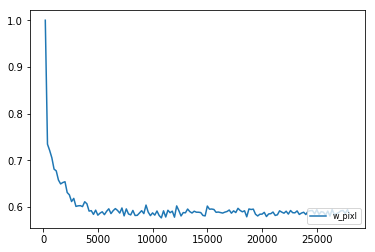

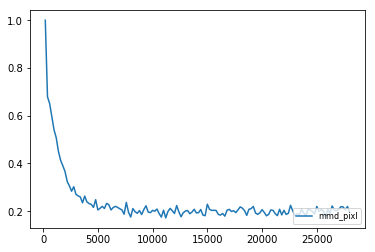

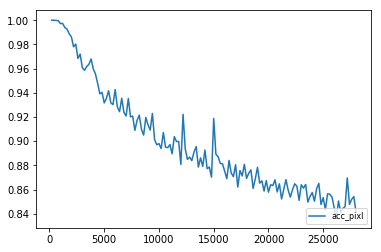

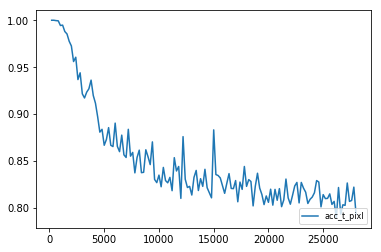

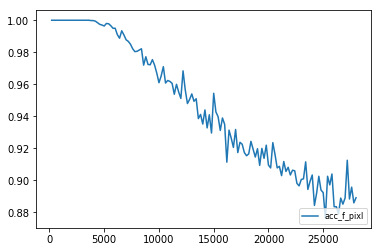

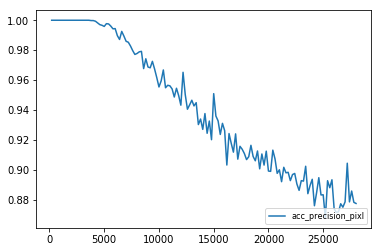

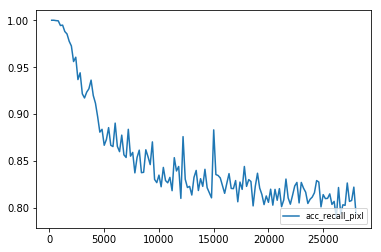

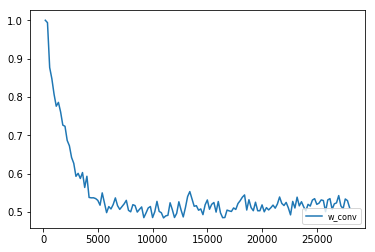

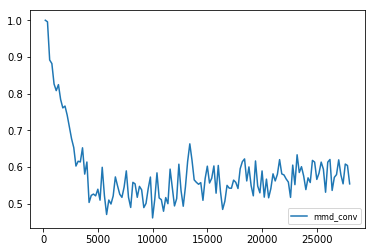

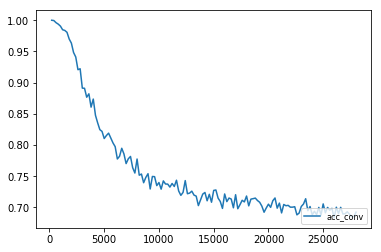

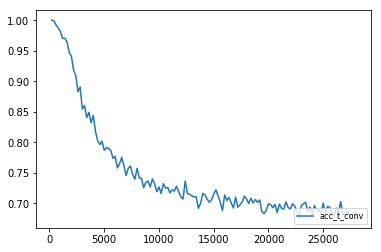

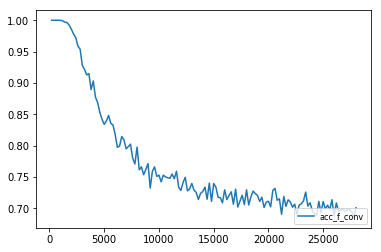

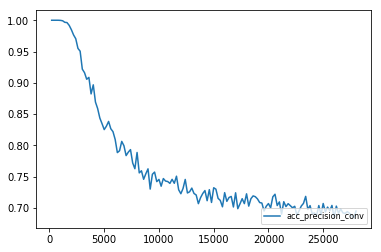

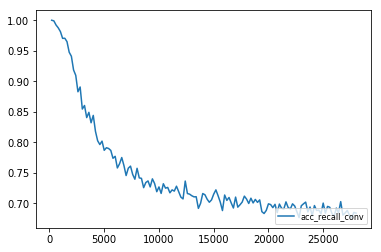

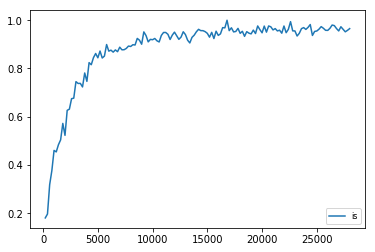

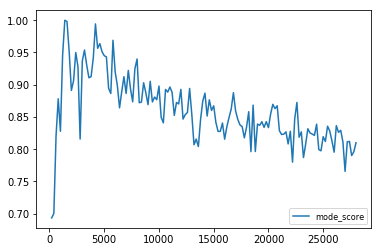

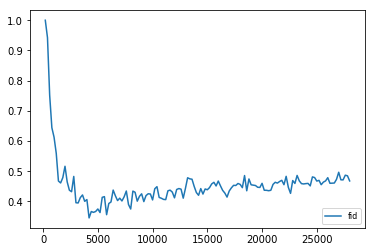

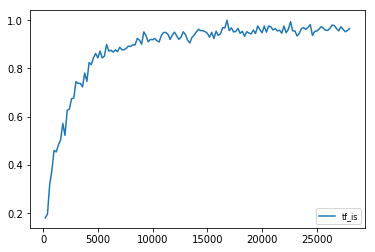

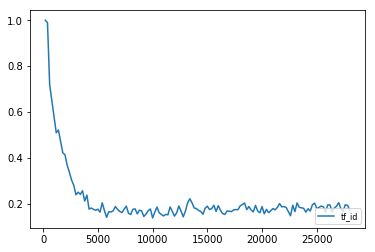

In [2]:

import torch.utils.data as Data

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np
import os
class BGAN():
    """Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/"""
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.x = []
        self.y = np.zeros((31, 1), dtype=np.int)
        self.y = list(self.y)
        for i in range(31):
            self.y[i] = []

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.boundary_loss, optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def boundary_loss(self, y_true, y_pred):
        """
        Boundary seeking loss.
        Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/
        """
        return 0.5 * K.mean((K.log(y_pred) - K.log(1 - y_pred))**2)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (X_test, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
        # X_test = X_test / 127.5 - 1.
        X_test = np.expand_dims(X_test, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        nb_batches = int(X_train.shape[0] / batch_size)
        global_step = 0

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            # idx = np.random.randint(0, X_train.shape[0], batch_size)
            for index in range(nb_batches):
                global_step += 1
                # progress_bar.update(index)

                # get a batch of real images
                image_batch = X_train[index * batch_size:(index + 1) * batch_size]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(image_batch, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print("epoch:%d step:%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,global_step, d_loss[0], 100 * d_loss[1], g_loss))

                # If at save interval => save generated image samples
                sampleSize = 5000
                # If at save interval => save generated image samples
                if global_step % sample_interval == 0:
                    s = self.metrics(global_step, X_test, sampleSize)
        for i in range(len(s)):
            self.y[i] = [float(j) / max(self.y[i]) for j in self.y[i]]#对值进行归一化处理

        for i in range(len(s)):
            font1={'size':8}

            plt.plot(self.x, self.y[i], label=labels_name[i])
            plt.legend(loc='lower right',prop=font1)
            plt.savefig('saved_models_bgan/{}.png'.format(labels_name[i]))
            plt.show()
            plt.close()

    def metrics(self, epoch, X_test, sampleSize):
        self.x.append(epoch)
        r, c = 10, sampleSize // 10
        noise = np.random.normal(0, 1, (r * c, 100))
#         sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise])
        x_dataset = MyDataset(X_test[:sampleSize])
        # print(x_dataset[0].shape)
        x_real_loader = Data.DataLoader(dataset=x_dataset, batch_size=sampleSize, shuffle=True)
        x_fake_dataset = MyDataset(gen_imgs)
        x_fake_loader = Data.DataLoader(dataset=x_fake_dataset, batch_size=sampleSize, shuffle=True)
        s = compute_score_raw(x_real_loader, x_fake_loader, 256, '/real/', './fake', conv_model='tfgan',
                              workers=int(1))
        real_images = tf.convert_to_tensor(X_test)  # real images
#         # MNIST_CLASSIFIER_FROZEN_GRAPH = '.\classify_mnist_graph_def.pb'
        gen_imgs = np.array(gen_imgs)
        eval_images = tf.convert_to_tensor(gen_imgs)
        eval_score = utils.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)  # IS score
        frechet_distance = utils.mnist_frechet_distance(real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)
        mnist_score, f_distance = sess.run([eval_score, frechet_distance])
#         print(mnist_score)
#         print(f_distance)
# #         s[14]=mnist_score
# #         s[16]=f_distance
        s[17] = mnist_score
        s[18] = f_distance
        print('IS socre: %f' % mnist_score)
        print('FID: %f' % f_distance)

        for i in range(len(s)):
            print(i, "=", s[i])
        for i in range(len(s)):
            self.y[i].append(s[i])
        f.writelines('\n')
        f.writelines('epoch:' + str(epoch))
        f.writelines('\n')
        f.writelines('%.8f' % (i) for i in s)
        f.writelines('\n')
        return s


if __name__ == '__main__':
    bgan = BGAN()
    bgan.train(epochs=30, batch_size=64, sample_interval=200)
